# Bayesian Inference and the Blue Wave

This project uses Bayesian inference to predict the vote share Democratic candidates will receive in the 2018 midterm Senate elections. These midterm elections are of particular interest to Democrats, as they present an opportunity for a "Blue Wave" in the Senate in which Democrats can regain the majority. However, to achieve this, they must keep all of the seats previously held by Democrats and gain 2 additional seats. Previous senate election data served as the prior, recent polling data served as the likelihood, and Markov chain Monte Carlo simulations created the posterior distribution. An estimated 26 seats will go to Democrats in this election, resulting in a 49% minority which means a Senate Blue Wave is unlikely. On an optimistic note, forecasts are favorable for a Blue Wave in the House of Representatives.  

## Table of Contents
1. Library Imports
2. Creating the Prior
3. Creating the Likelihood
4. Creating the Posterior
5. Conclusion

## Notes
- There were no polls available on Hawaii and Wyoming's candidates.
- California has a "top two" primary election system where the two candidates with the highest amount of votes in the primary election advance to the general election, regardless of party affiliation. Thus, there are two Democratic candidates. For the purposes of this project, Dianne Feinstein (incumbent) is being treated as the Democratic candidate and her opponent, Kevin de Leon, is being treated as the other candidate.

## Data Sources
- Prior election data comes from the FEC's 2014 and 2016 Official Senate Election Results
- Polling data comes from FiveThirtyEight

## 1. Library Imports

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import pymc3 as pm
import numpy.random as npr
import matplotlib as mpl
from collections import Counter
import seaborn as sns
from random import shuffle
import warnings
warnings.filterwarnings("ignore")

# Set plotting style
plt.style.use('fivethirtyeight')
sns.set_style('white')
sns.set_context('poster')

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Couldn't import dot_parser, loading of dot files will not be possible.


## 2. Creating the Prior

In [2]:
# based on democrat's share of votes in prior elections
# JUST % out of dem + rep
# Democratic candidate (or the Dem that won if two Democrats ran against each other) / Democrat + Republican
az_goal = 1031245 / (1031245 + 1359267)
ca_goal = 7542759 / (7542759 + 4701417)
ct_goal = 1008714 / (1008714 + 552621)
de_goal = 130655 / (130655 + 98823)
fl_goal = 4122088 / (4122088 + 4835191)
in_goal = 1158947 / (1158947 + 1423991)
ma_goal = 1289944 / (1289944 + 791950)
md_goal = 1659907 / (1659907 + 972557)
me_goal = 190244 / (190244 + 413495)
mi_goal = 1704936 / (1704936 + 1290199)
mn_goal = 1053205 / (1053205 + 850227)
mn_special_goal = 1053205 / (1053205 + 850227)
mo_goal = 1300200 / (1300200 + 1378458)
ms_goal = 239439 / (239439 + 378481)
ms_special_goal = 239439 / (239439 + 378481)
mt_goal = 148184 / (148184 + 213709)
nd_goal = 58116 / (58116 + 268788)
ne_goal = 170127 / (170127 + 347636)
nj_goal = 1043866 / (1043866 + 791297)
nm_goal = 286409 / (286409 + 229097)
nv_goal = 521994 / (521994 + 495079)
ny_goal = 5221945 / (5221945 + 2009355)
oh_goal = 1996908 / (1996908 + 3118567)
pa_goal = 2865012 / (2865012 + 2951702)
ri_goal = 223675 / (223675 + 92684)
tn_goal = 437848 / (437848 + 850087)
tx_goal = 1597387 / (1597387 + 2861531)
ut_goal = 301860 / (301860 + 760241)
va_goal = 1073667 / (1073667 + 1055940)
vt_goal = 192243 / (192243 + 103637)
wa_goal = 1913979 / (1913979 + 1329338)
wi_goal = 1380335 / (1380335 + 1479471)
wv_goal = 156360 / (156360 + 281820)

goals = [az_goal, ca_goal, ct_goal, de_goal, fl_goal, in_goal, ma_goal, md_goal, 
         me_goal, mi_goal, mn_goal, mn_special_goal, mo_goal, ms_goal, ms_special_goal, mt_goal, 
         nd_goal, ne_goal, nj_goal, nm_goal, nv_goal, ny_goal, oh_goal, pa_goal, ri_goal, tn_goal, 
         tx_goal, ut_goal, va_goal, vt_goal, wa_goal, wi_goal, wv_goal]

In [3]:
## estimate a and b for each state
def optimize(goal, a,b,tol):
    err = 10
    ind = 0
    while err > tol and ind < 100000:
        guess = a/(a+b)
        err = abs(goal-guess)
        if err < tol:
            break
        b += 0.001
        if abs(a/(a+b) - goal) > err:
            b -= 0.002
        ind += 1
    return a,b,guess,err

In [4]:
states = ['AZ','CA','CT','DE','FL','IN','MA','MD','ME','MI','MN','MN_special','MO',
         'MS','MS_special','MT','ND','NE','NJ','NM','NV','NY','OH','PA','RI','TN','TX','UT',
         'VA','VT','WA','WI','WV']
# initial guess
state_priors_i = [(3,2.5)] * len(goals)

In [5]:
state_priors = []
for ind,state in enumerate(states):
    a = state_priors_i[ind][0]
    b = state_priors_i[ind][1]
    tol = 0.000001
    print("\n\tSTATE:",state)
    print("Goal:\t\t",goals[ind],"\nInitial a, b:\t",a,",",b,"\nInitial guess:\t",a/(a+b))
    a,b,guess,err = optimize(goals[ind],a,b,tol)
    if b > a and goals[ind] > 0.5:
        c = b
        b = a
        a = c
    print("\nFinal a, b:\t",a,",",b,"\nFinal guess:\t",guess,"\nError:\t\t",err)
    state_priors.append((a,b))


	STATE: AZ
Goal:		 0.431390848487688 
Initial a, b:	 3 , 2.5 
Initial guess:	 0.5454545454545454

Final a, b:	 3 , 3.95399999999984 
Final guess:	 0.4314684308931496 
Error:		 7.75824054616292e-05

	STATE: CA
Goal:		 0.6160283060289234 
Initial a, b:	 3 , 2.5 
Initial guess:	 0.5454545454545454

Final a, b:	 3 , 1.8699999999890085 
Final guess:	 0.6161429451646688 
Error:		 0.00011463913574538687

	STATE: CT
Goal:		 0.6460586613378936 
Initial a, b:	 3 , 2.5 
Initial guess:	 0.5454545454545454

Final a, b:	 3 , 1.6439999999890083 
Final guess:	 0.6461339651102955 
Error:		 7.530377240194674e-05

	STATE: DE
Goal:		 0.5693574111679551 
Initial a, b:	 3 , 2.5 
Initial guess:	 0.5454545454545454

Final a, b:	 3 , 2.2680000000000256 
Final guess:	 0.569368001518312 
Error:		 1.0590350356887157e-05

	STATE: FL
Goal:		 0.4601942174626915 
Initial a, b:	 3 , 2.5 
Initial guess:	 0.5454545454545454

Final a, b:	 3 , 3.5189999999998878 
Final guess:	 0.4601932811781027 
Error:		 9.3628458880390

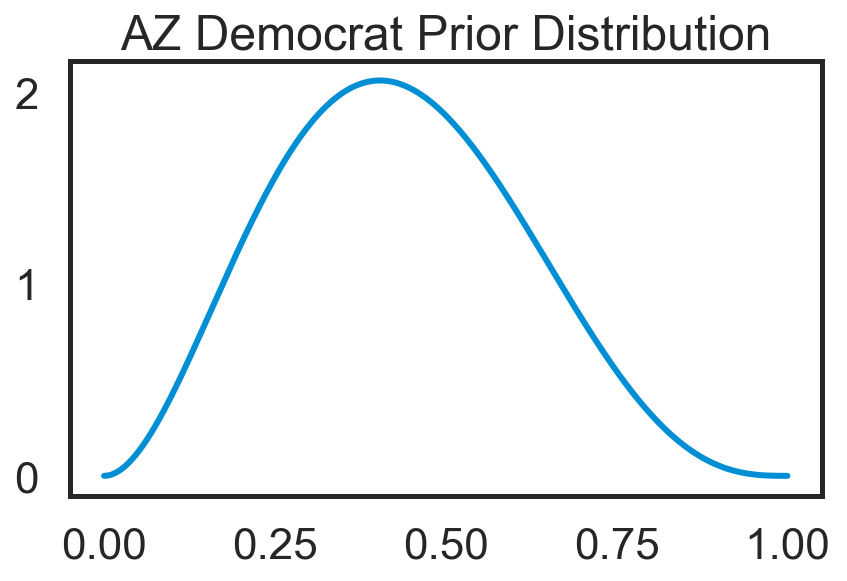

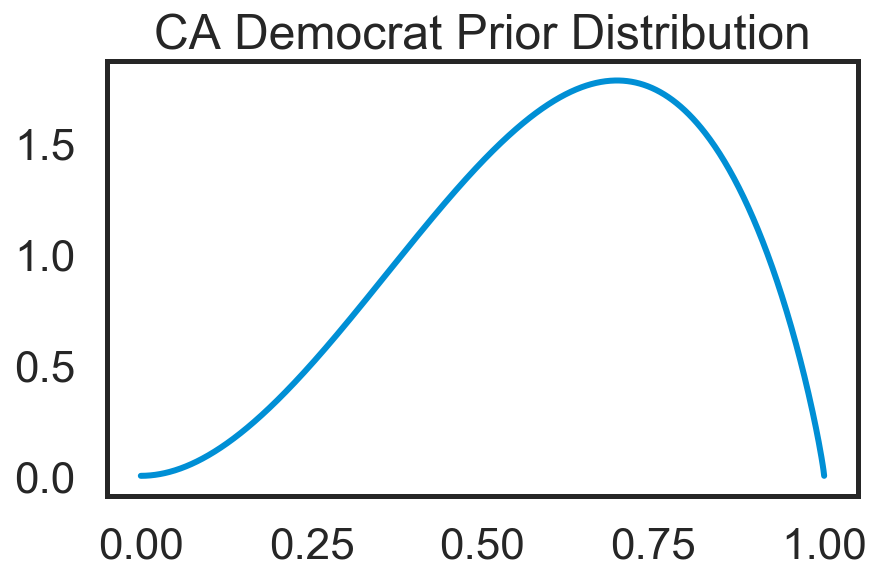

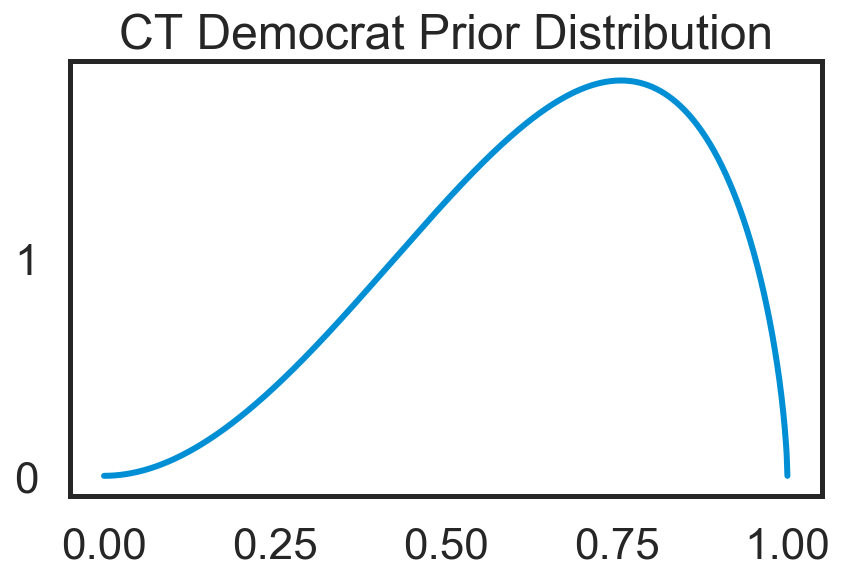

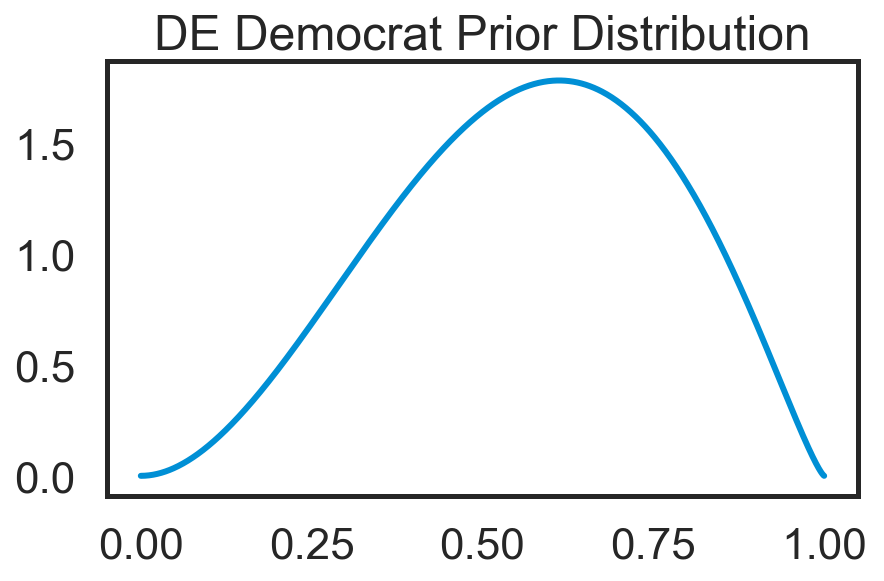

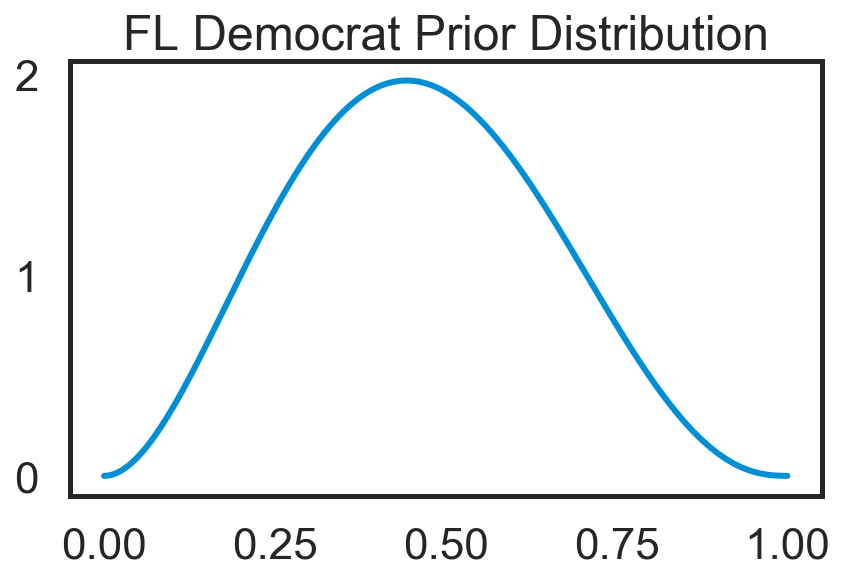

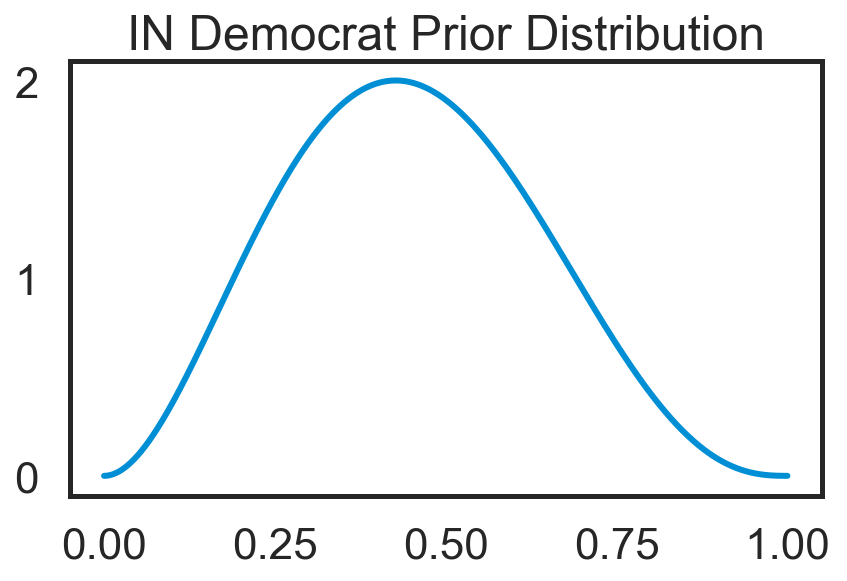

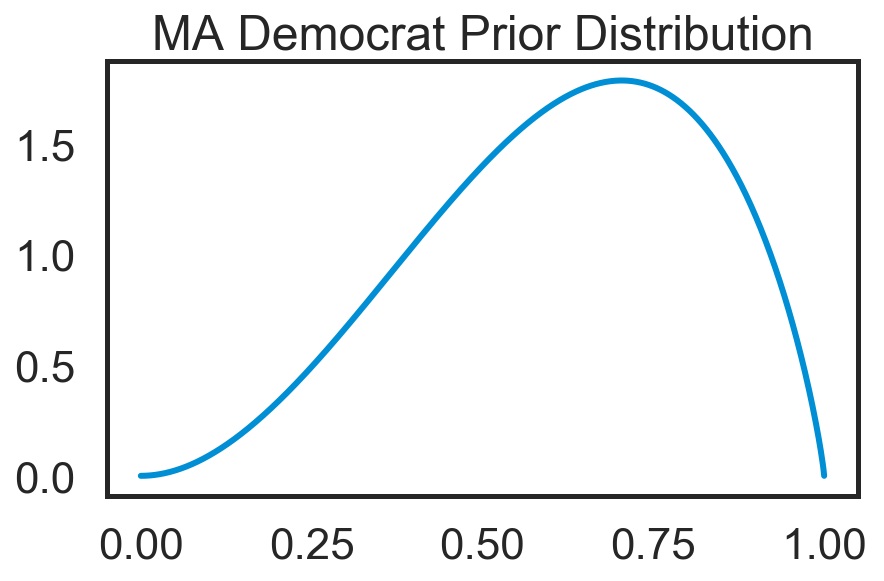

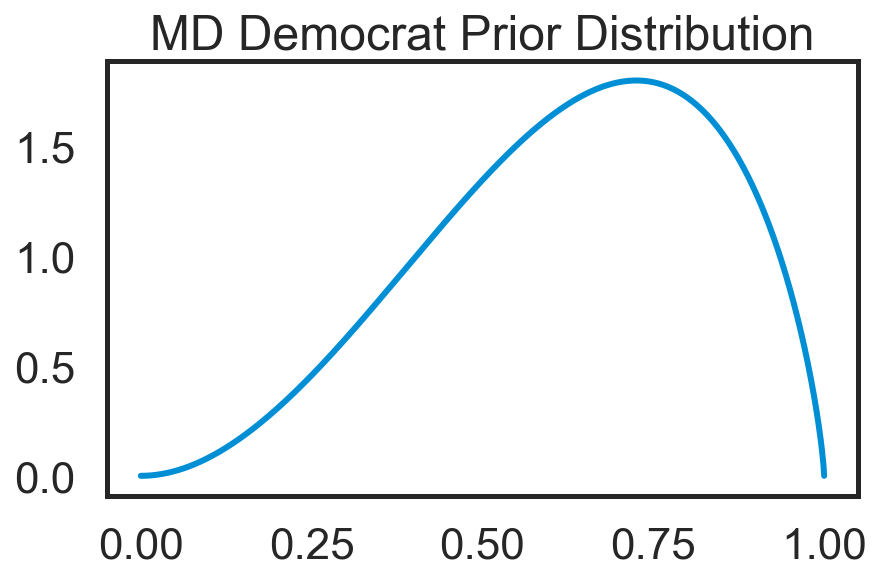

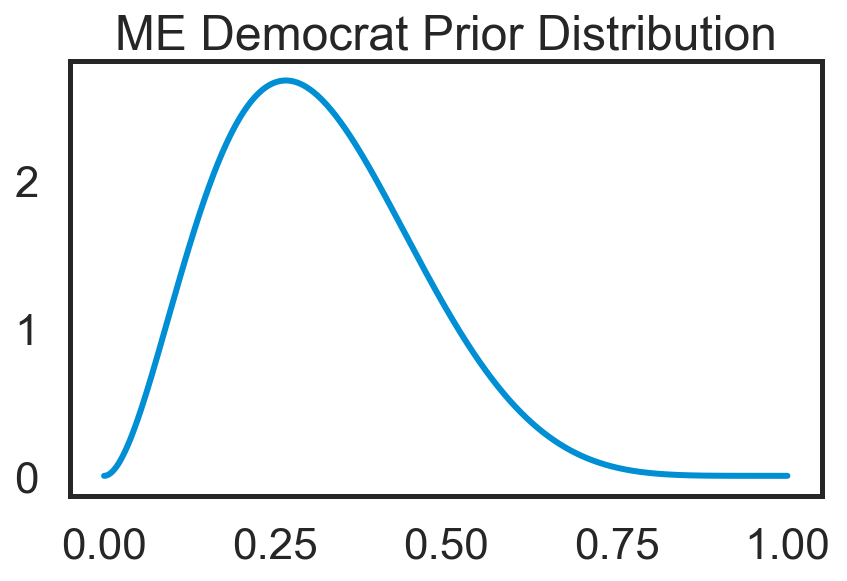

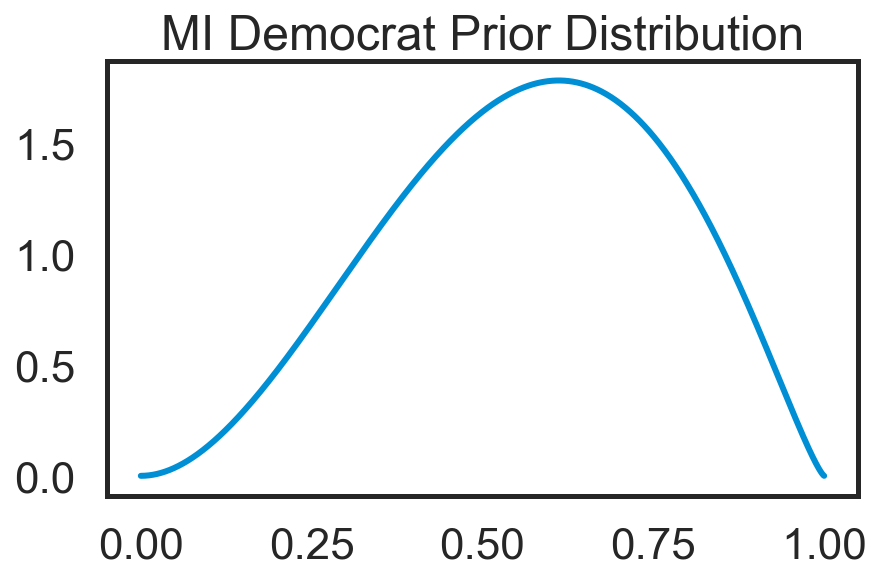

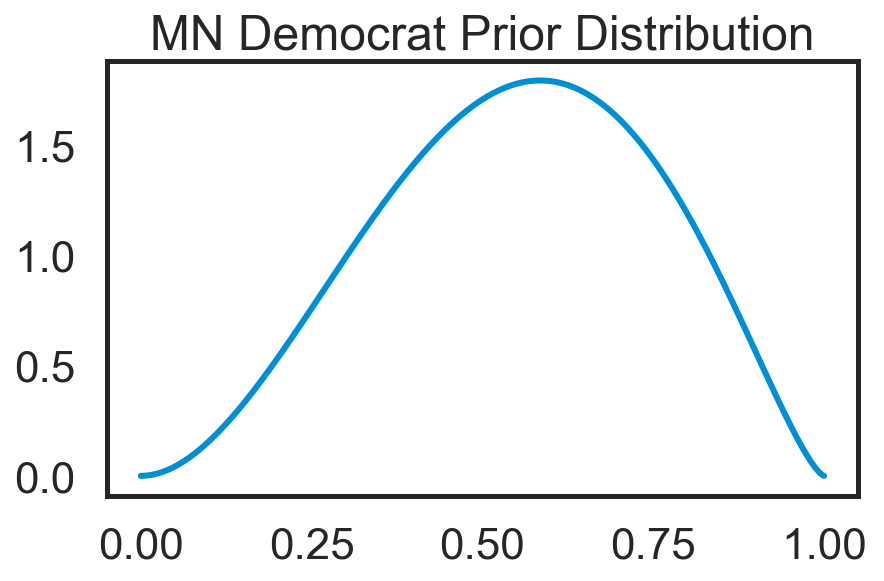

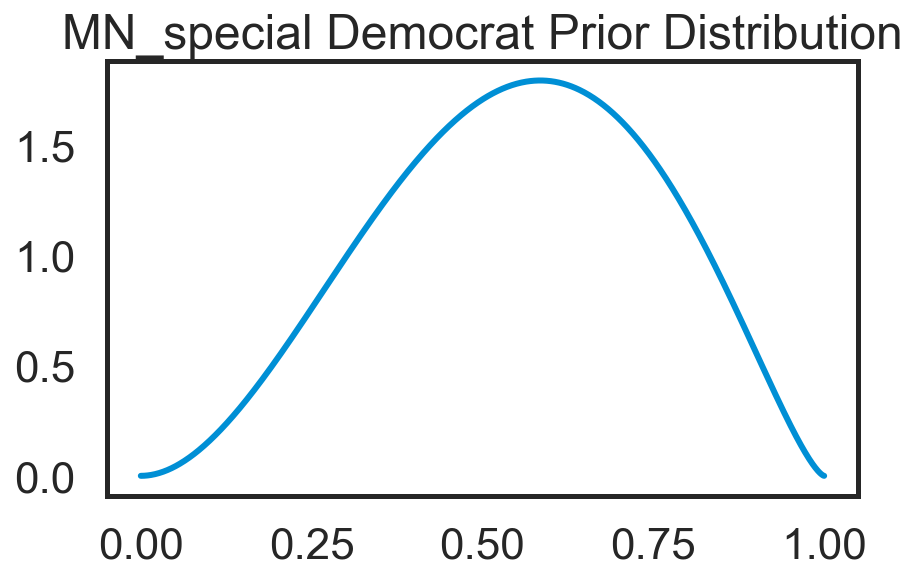

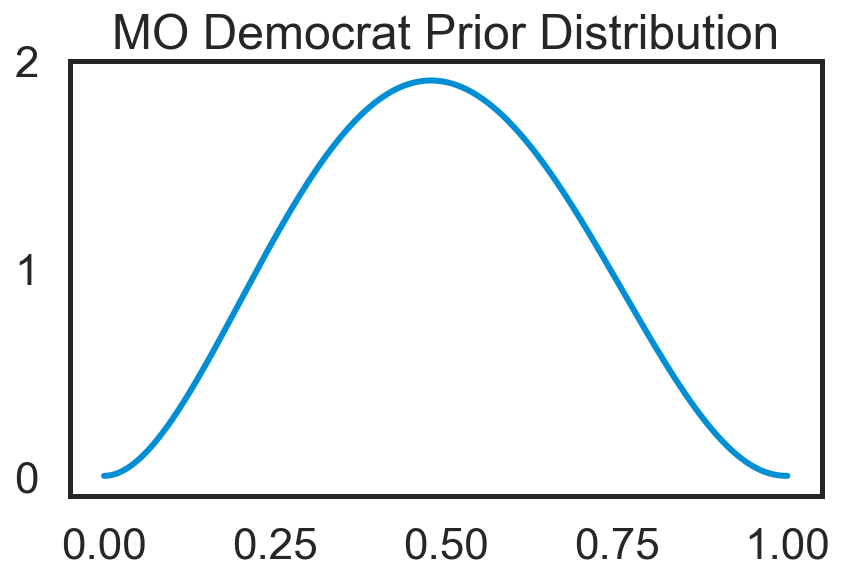

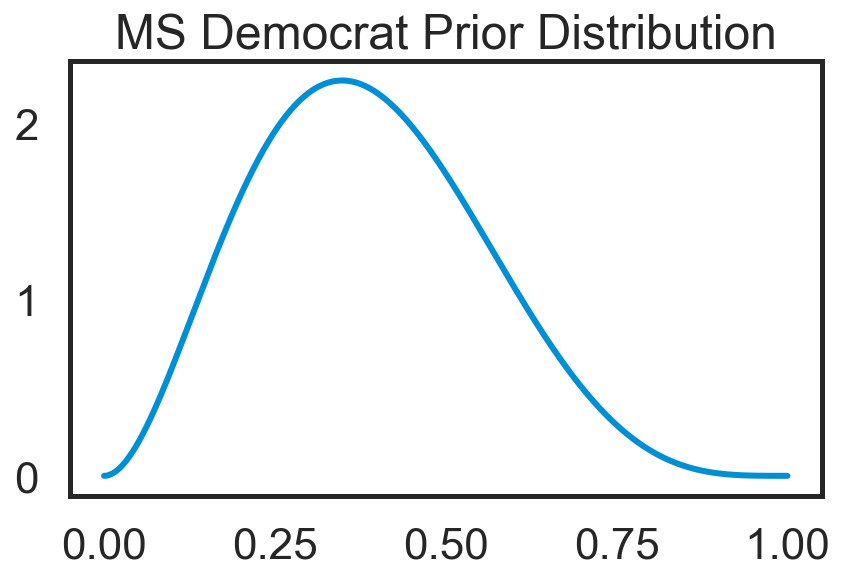

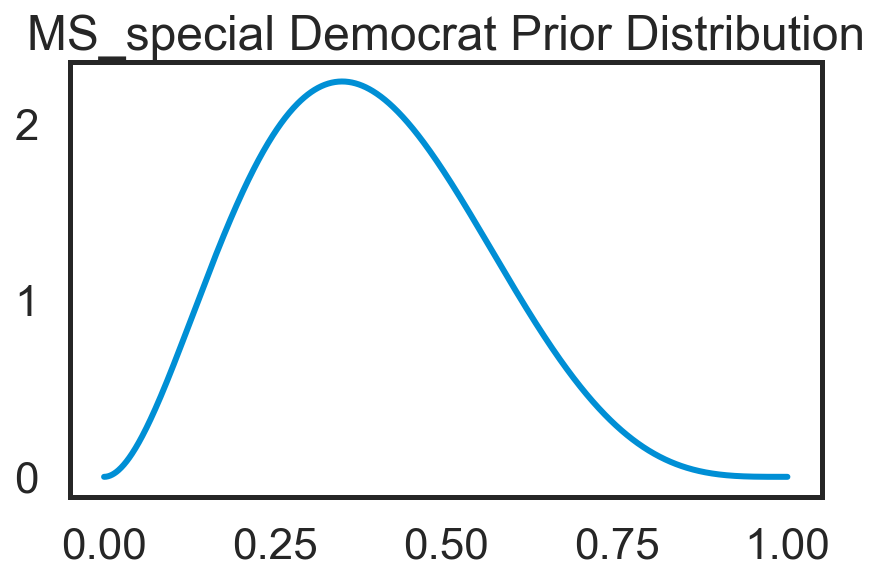

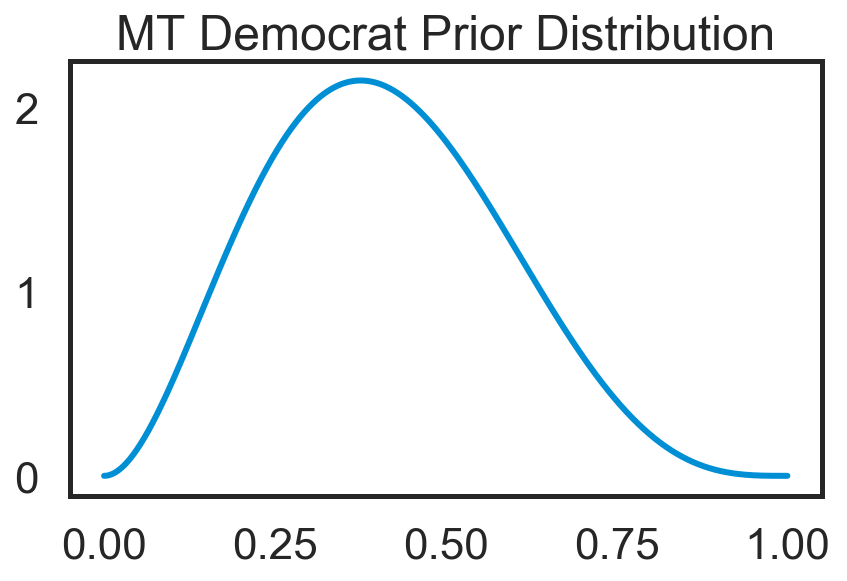

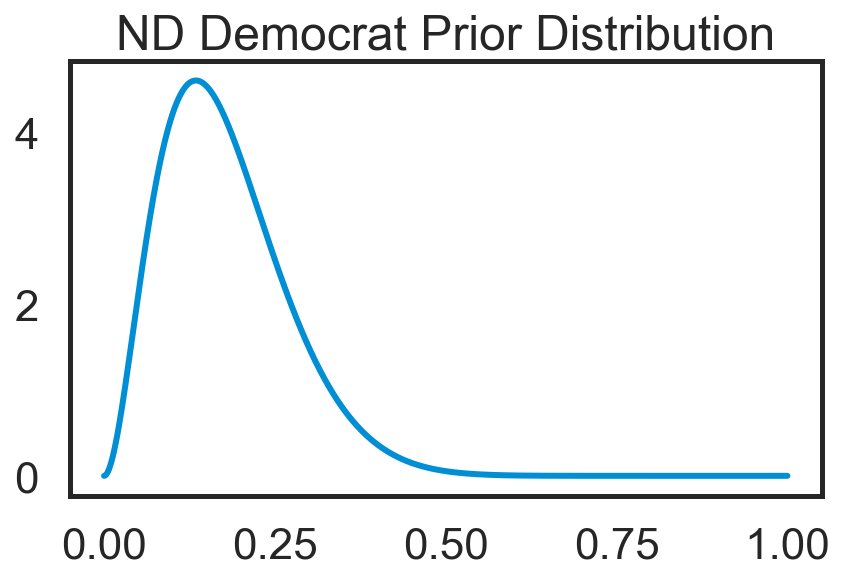

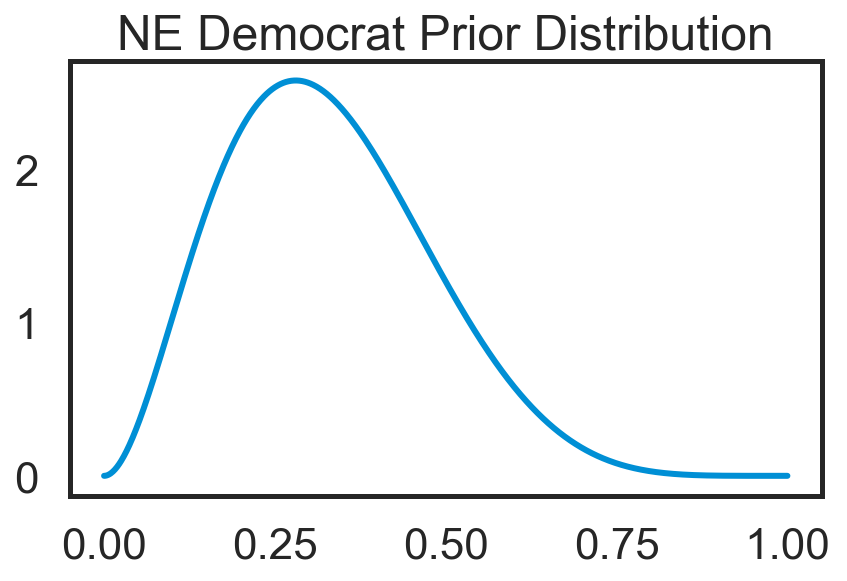

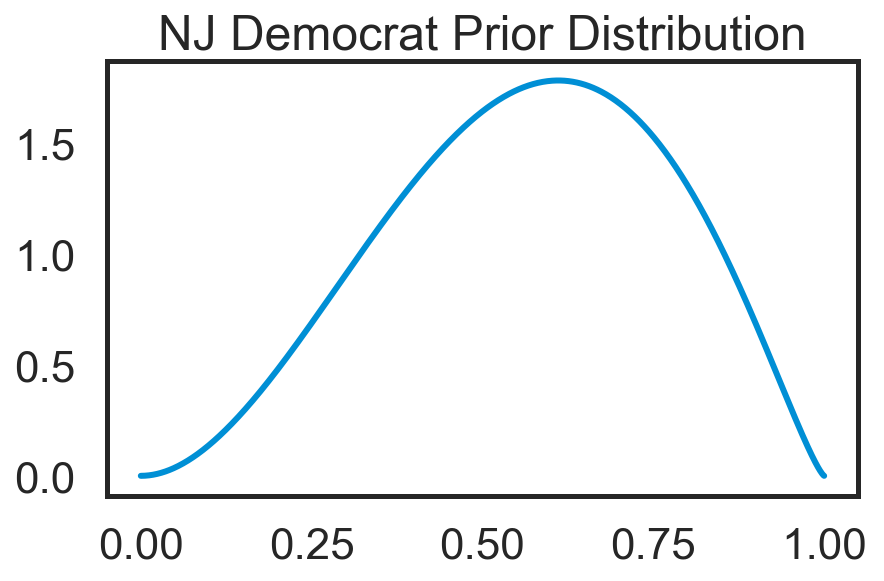

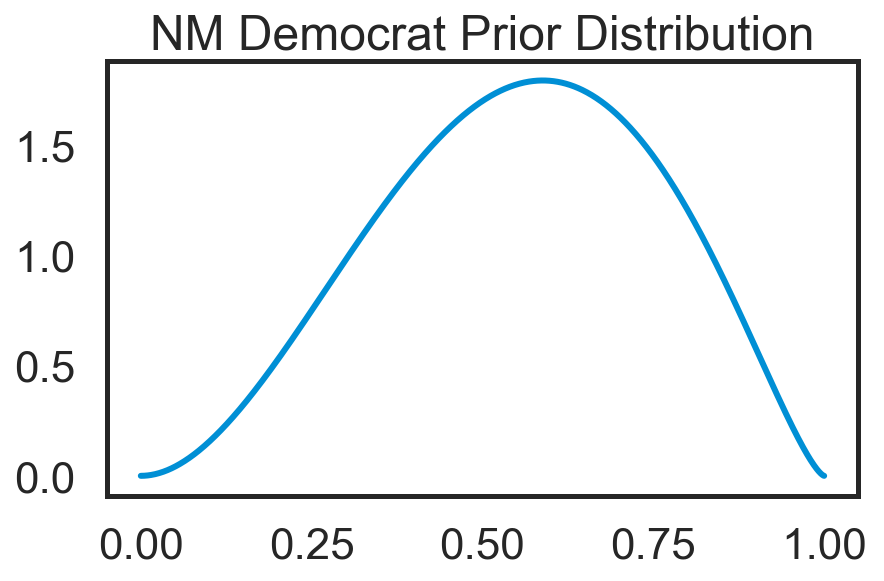

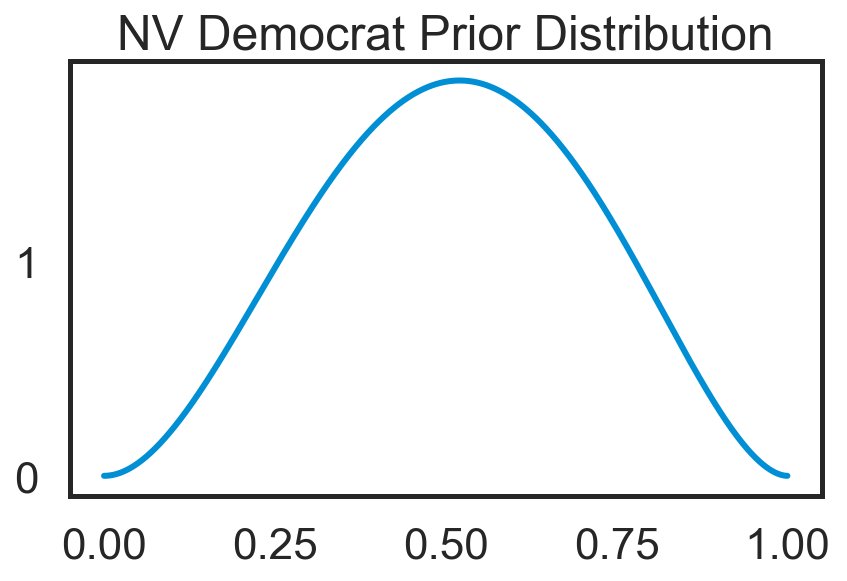

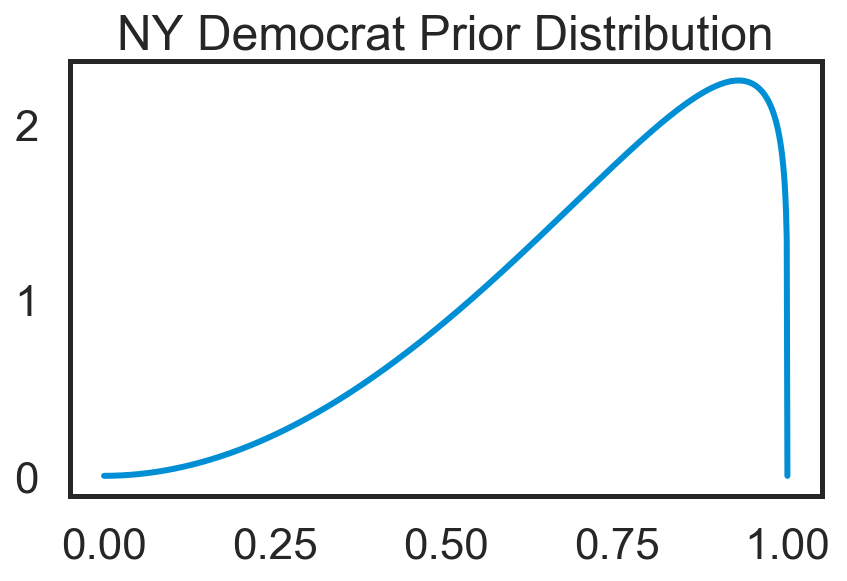

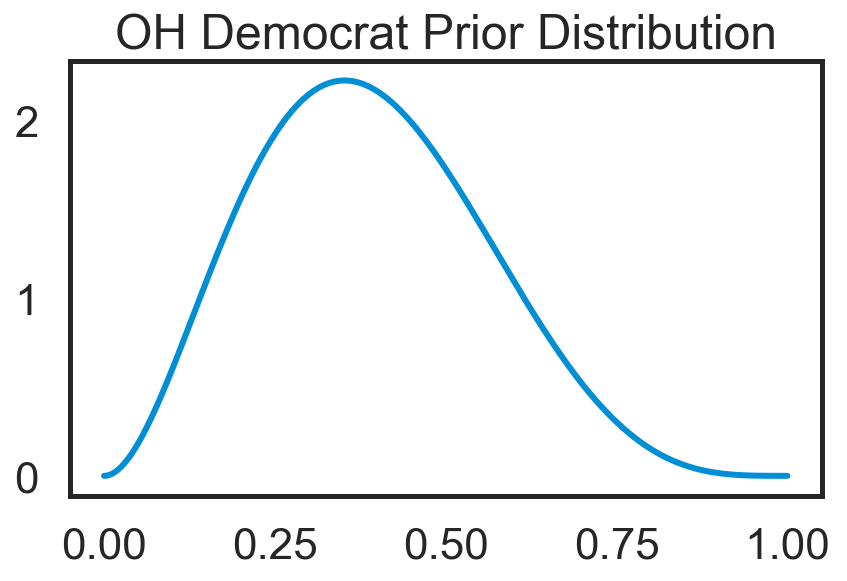

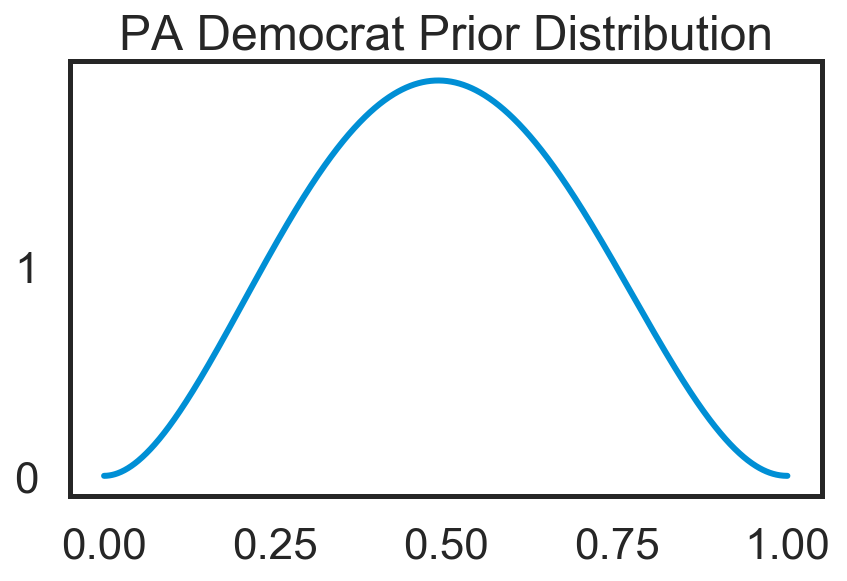

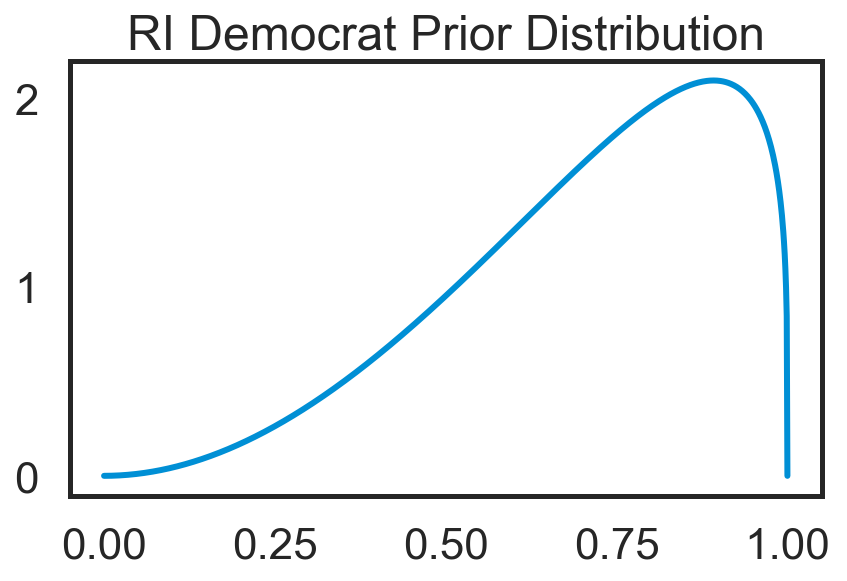

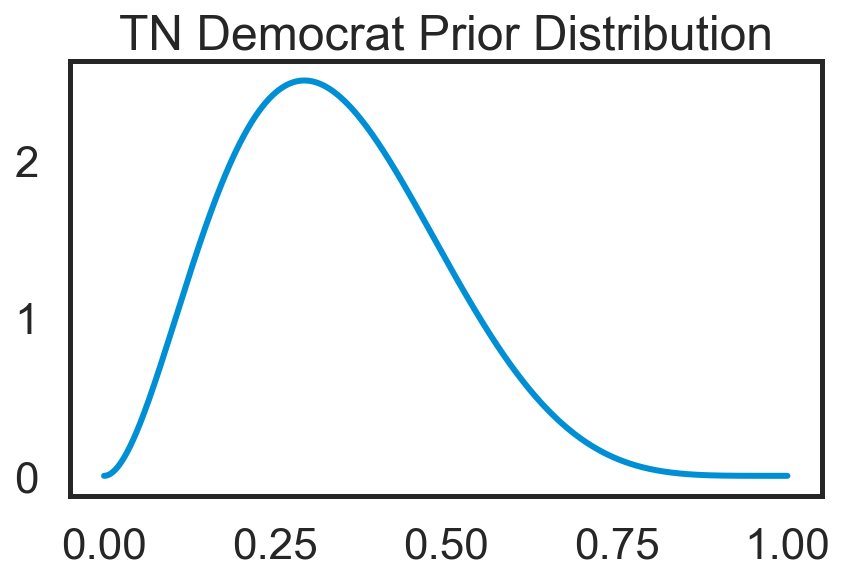

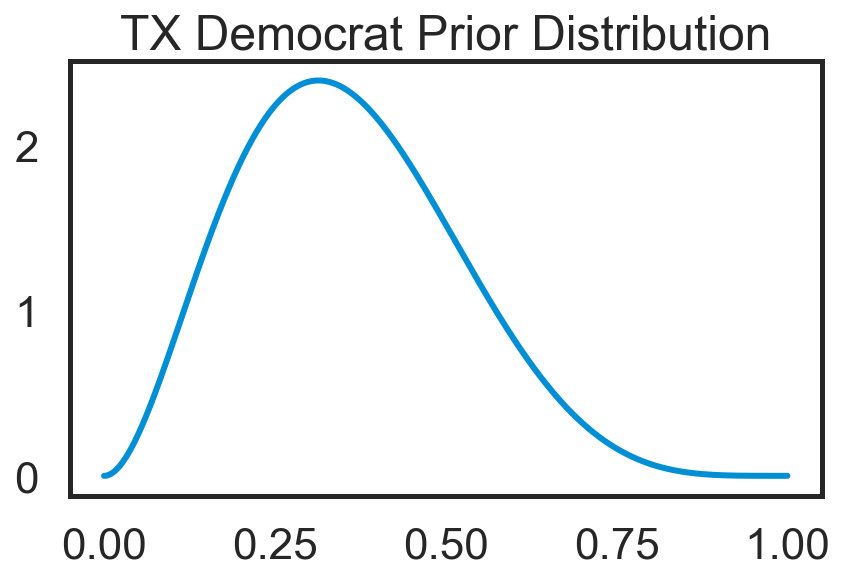

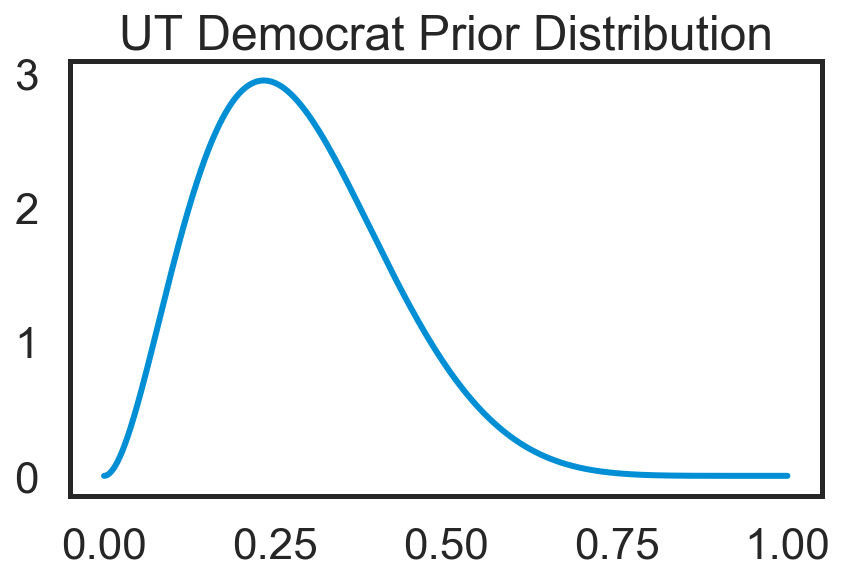

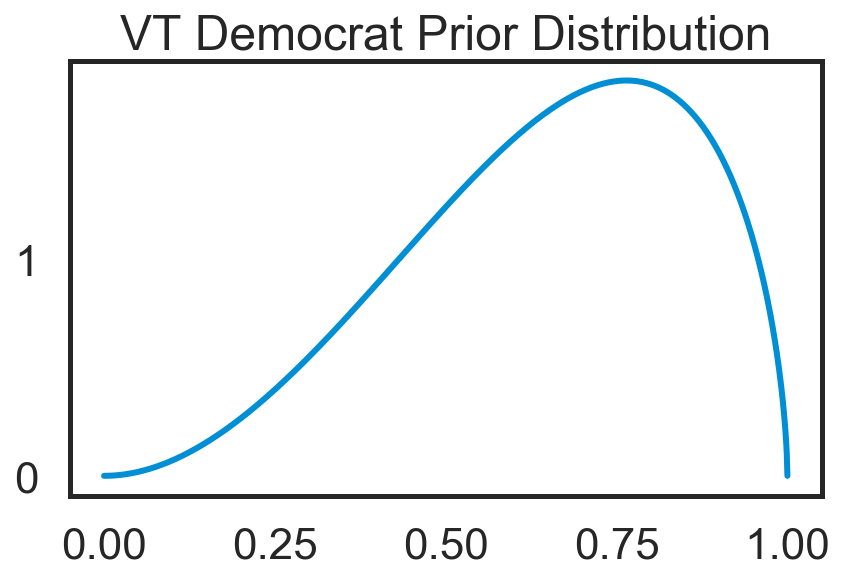

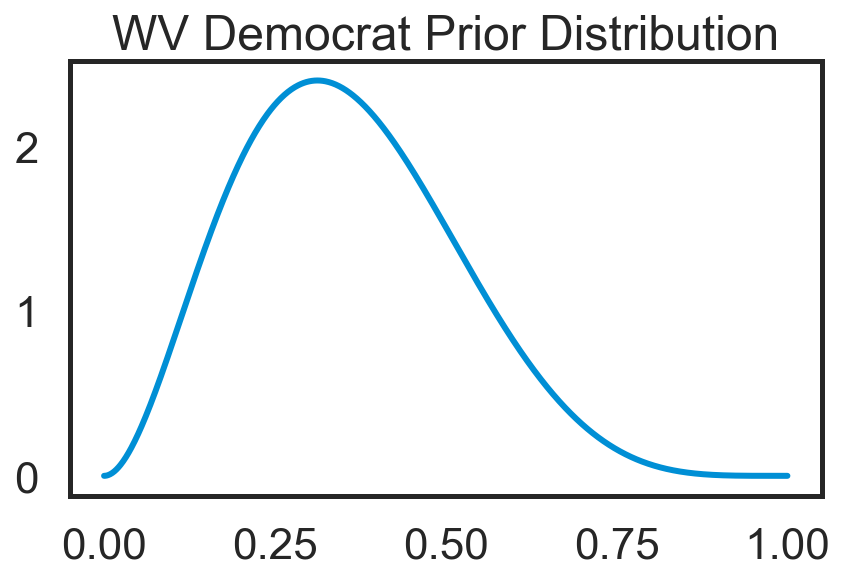

In [6]:
for ind,state in enumerate(states):
    a = state_priors[ind][0]
    b = state_priors[ind][1]
    prior_beta_dist = stats.beta(a,b)
    # Create list of probs for plotting x-axis
    percentages_for_plotting_x_axes = np.linspace(0, 1, 1001)

    # this gives us our y-axis
    prior_pdfs = [prior_beta_dist.pdf(p) for p in percentages_for_plotting_x_axes]

    # plot prior beta distribution
    plt.figure()
    plt.plot(percentages_for_plotting_x_axes, prior_pdfs)
    plt.title(state+' Democrat Prior Distribution')

## 3. Creating the Likelihood 

In [7]:
polls = pd.read_csv('./assets/data/senate-polls.csv')
polls.columns = ['race', 'pollster', 'sample', 'democrat', 'republican', 'republican_two']
print(polls.shape)
polls.head()

(355, 6)


race                               pollster  sample  democrat  republican  \
0   WA                  Public Policy Polling   675.0      0.52        0.36   
1   CA                     Vox Populi Polling   500.0      0.55        0.45   
2   CA  Public Policy Institute of California   964.0      0.40        0.29   
3   CA                                  Ipsos  1021.0      0.44        0.24   
4   CA                     Probolsky Research   900.0      0.37        0.29   

   republican_two  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN

In [8]:
parties = ['democrat', 'republican', 'republican_two']

for p in parties:
    polls[p + '_votes'] = polls['sample'] * polls[p]
    
polls.head()

race                               pollster  sample  democrat  republican  \
0   WA                  Public Policy Polling   675.0      0.52        0.36   
1   CA                     Vox Populi Polling   500.0      0.55        0.45   
2   CA  Public Policy Institute of California   964.0      0.40        0.29   
3   CA                                  Ipsos  1021.0      0.44        0.24   
4   CA                     Probolsky Research   900.0      0.37        0.29   

   republican_two  democrat_votes  republican_votes  republican_two_votes  
0             NaN          351.00            243.00                   NaN  
1             NaN          275.00            225.00                   NaN  
2             NaN          385.60            279.56                   NaN  
3             NaN          449.24            245.04                   NaN  
4             NaN          333.00            261.00                   NaN

In [9]:
# create a separate data frame for each state
az = polls[polls['race'] == 'AZ']
ca = polls[polls['race'] == 'CA']
ct = polls[polls['race'] == 'CT']
de = polls[polls['race'] == 'DE']
fl = polls[polls['race'] == 'FL']
ind = polls[polls['race'] == 'IN']
ma = polls[polls['race'] == 'MA']
md = polls[polls['race'] == 'MD']
me = polls[polls['race'] == 'ME']
mi = polls[polls['race'] == 'MI']
mn = polls[polls['race'] == 'MN']
mn_special = polls[polls['race'] == 'MN_special']
mo = polls[polls['race'] == 'MO']
ms = polls[polls['race'] == 'MS']
ms_special = polls[polls['race'] == 'MS_special']
mt = polls[polls['race'] == 'MT']
nd = polls[polls['race'] == 'ND']
ne = polls[polls['race'] == 'NE']
nj = polls[polls['race'] == 'NJ']
nm = polls[polls['race'] == 'NM']
nv = polls[polls['race'] == 'NV']
ny = polls[polls['race'] == 'NY']
oh = polls[polls['race'] == 'OH']
pa = polls[polls['race'] == 'PA']
ri = polls[polls['race'] == 'RI']
tn = polls[polls['race'] == 'TN']
tx = polls[polls['race'] == 'TX']
ut = polls[polls['race'] == 'UT']
va = polls[polls['race'] == 'VA']
vt = polls[polls['race'] == 'VT']
wa = polls[polls['race'] == 'WA']
wi = polls[polls['race'] == 'WI']
wv = polls[polls['race'] == 'WV']

state = [az, ca, ct, de, fl, ind, ma, md, me, mi, mn, mn_special, mo, ms, ms_special, mt, nd, ne, nj, nm, nv, 
         ny, oh, pa, ri, tn, tx, ut, va, vt, wa, wi, wv]

vote_share = {}
for s in state:
    name = list(s['race'])[0]
    s_dem = round(s['democrat_votes'].sum(), 0)
    s_rep = round(s['republican_votes'].sum(), 0)
    s_total = s_dem + s_rep
    vote_share[name] = {'Democratic Vote Share': s_dem,'Republican Vote Share':s_rep,'Total Vote Share':s_total}
    

In [10]:
vote_share['VA']

{'Democratic Vote Share': 3194.0,
 'Republican Vote Share': 2165.0,
 'Total Vote Share': 5359.0}

## 4. Creating the Posterior

In [11]:
trace_list = []
for ind in range(len(state_priors)):
    s = states[ind]
    model = pm.Model()
    with model:
        p = pm.Beta('p',alpha=state_priors[ind][0],beta=state_priors[ind][1])
        y_obs = pm.Binomial('y_obs',n=vote_share[s]['Total Vote Share'],p=p,observed=vote_share[s]['Democratic Vote Share'])
        step = pm.Metropolis()
        trace = pm.sample(100000, step = step, progressbar = True)
        trace_list.append(trace)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p]
Sampling 4 chains: 100%|██████████| 402000/402000 [00:36<00:00, 10982.06draws/s]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p]
Sampling 4 chains: 100%|██████████| 402000/402000 [00:37<00:00, 10704.76draws/s]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p]
Sampling 4 chains: 100%|██████████| 402000/402000 [00:37<00:00, 10741.28draws/s]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p]
Sampling 4 chains: 100%|██████████| 402000/402000 [00:36<00:00, 10868.12draws/s]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p]
Sampling 4 chains: 100%|██████████| 402000/402000 [00:36<00:00, 10961.31draws/s]
The numb

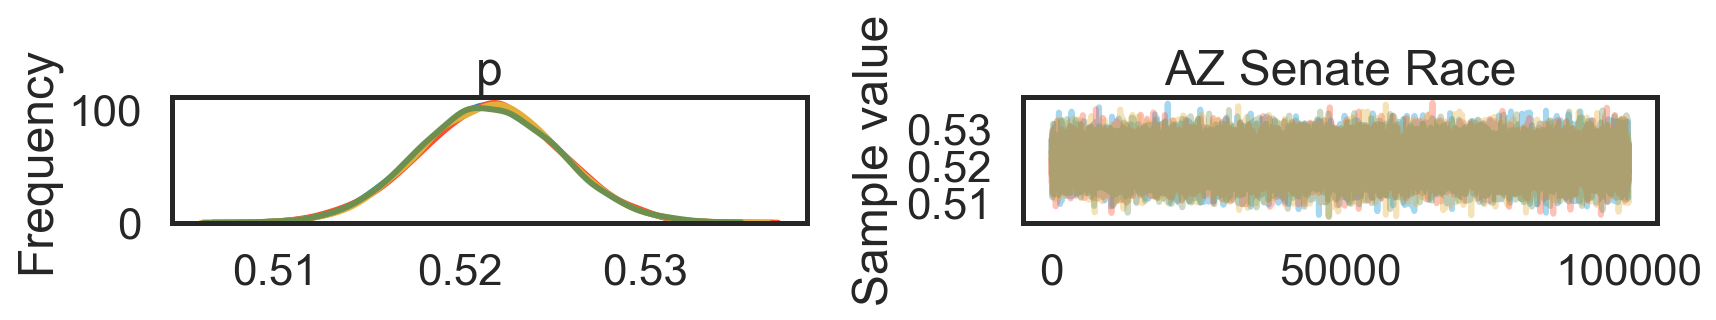

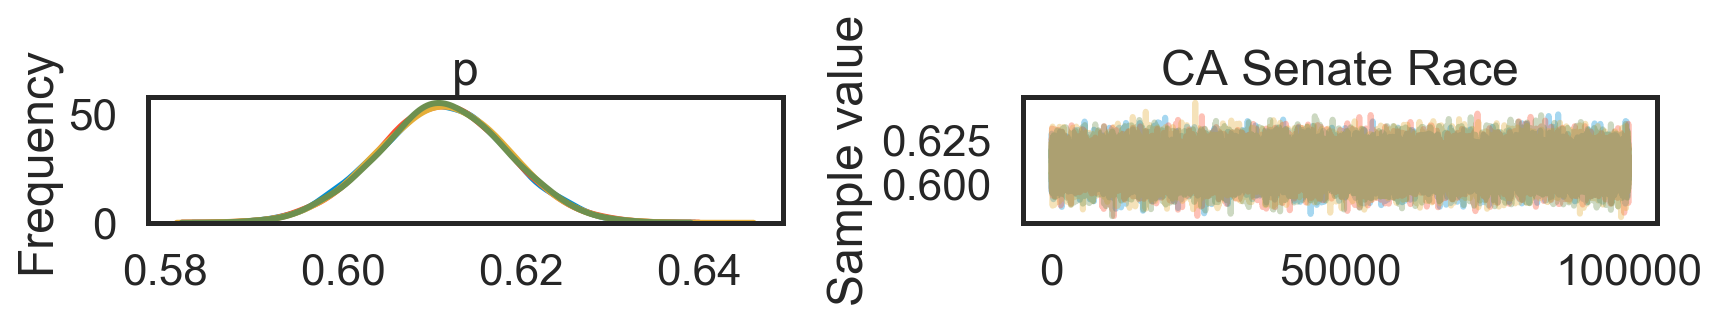

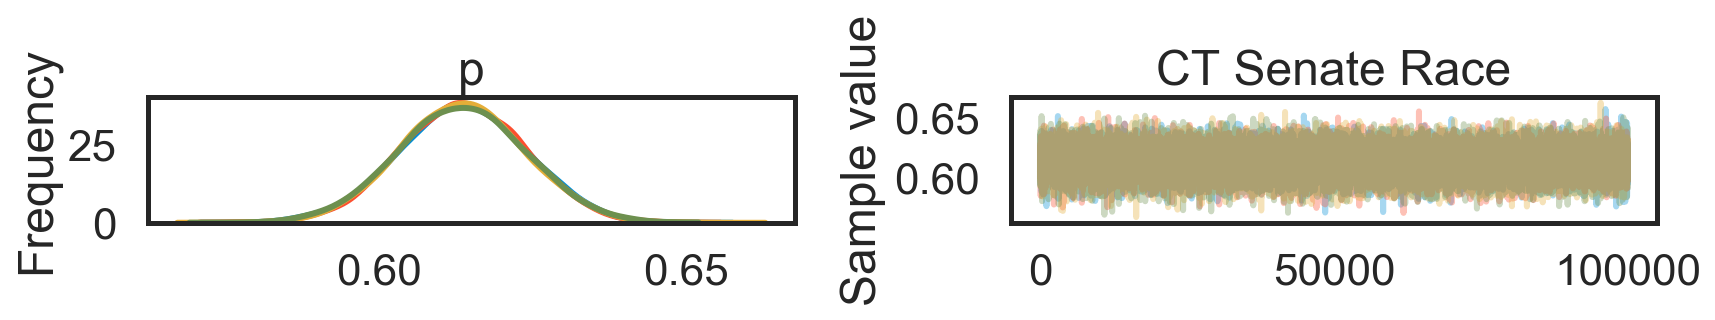

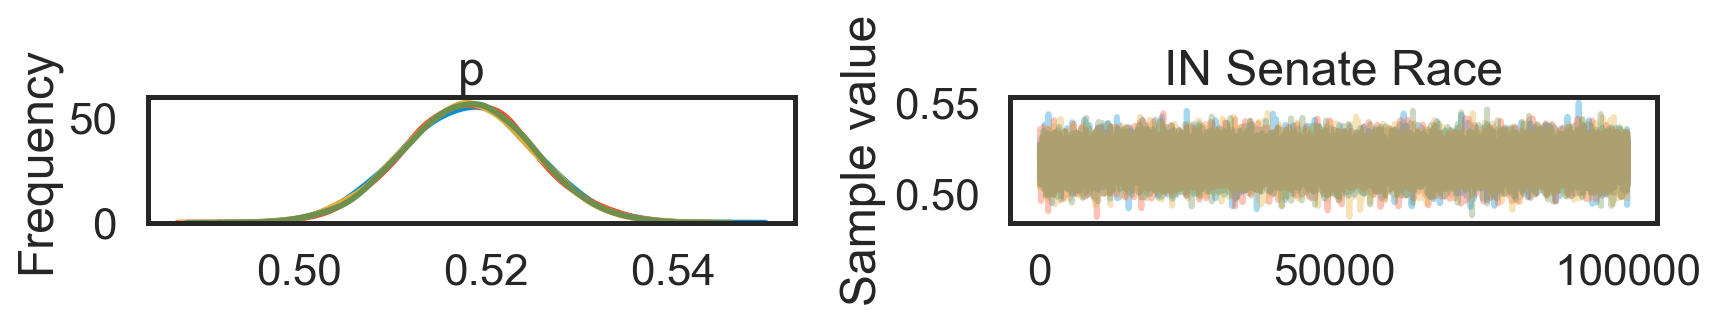

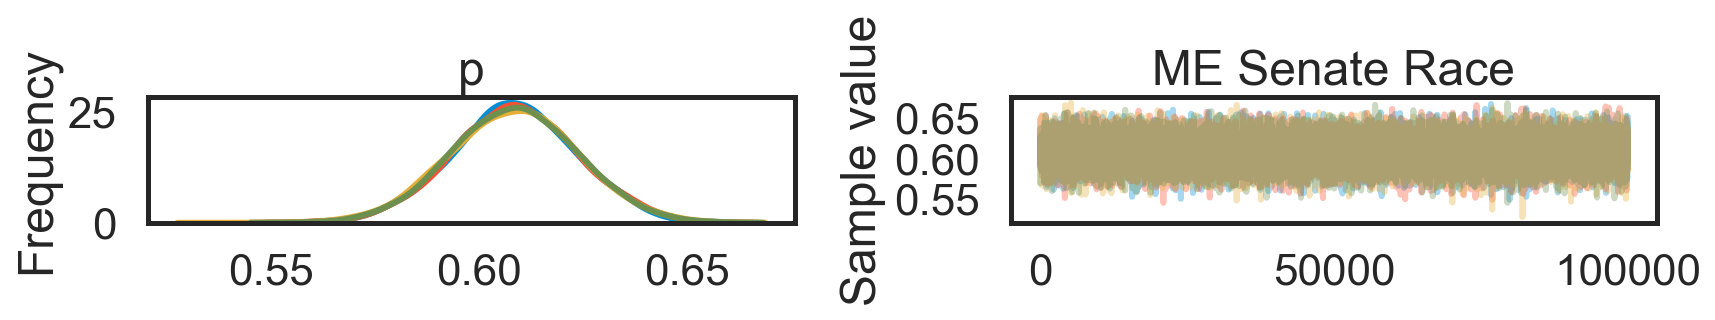

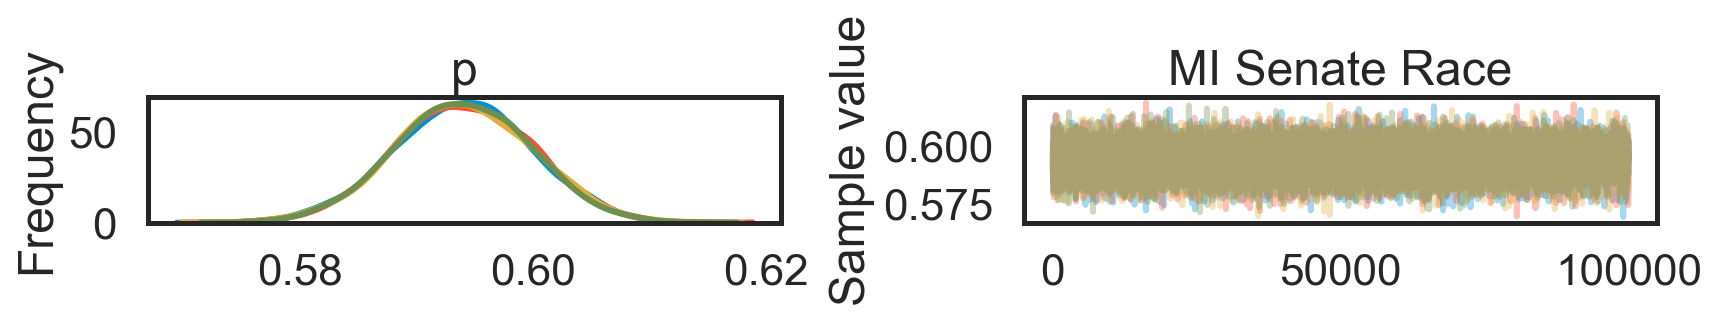

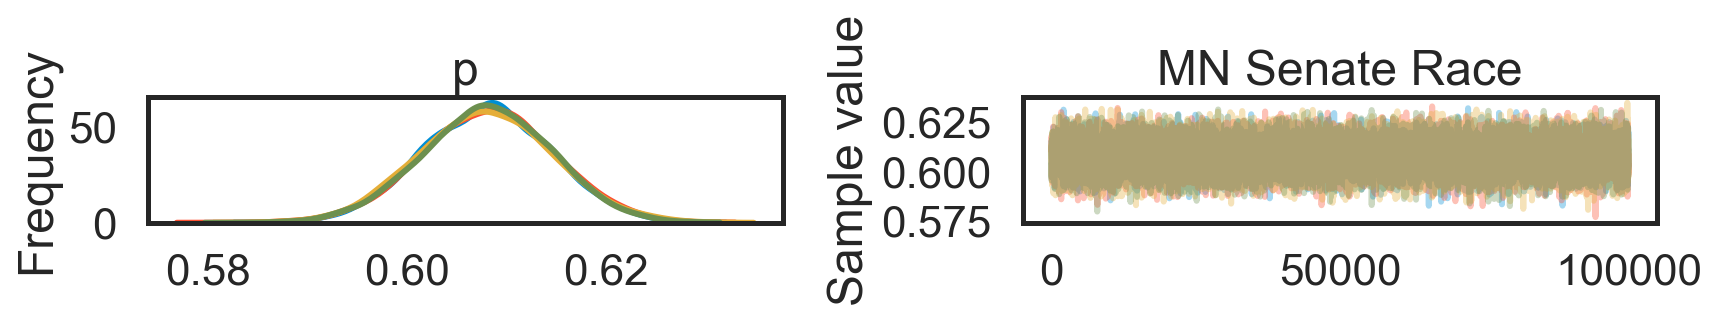

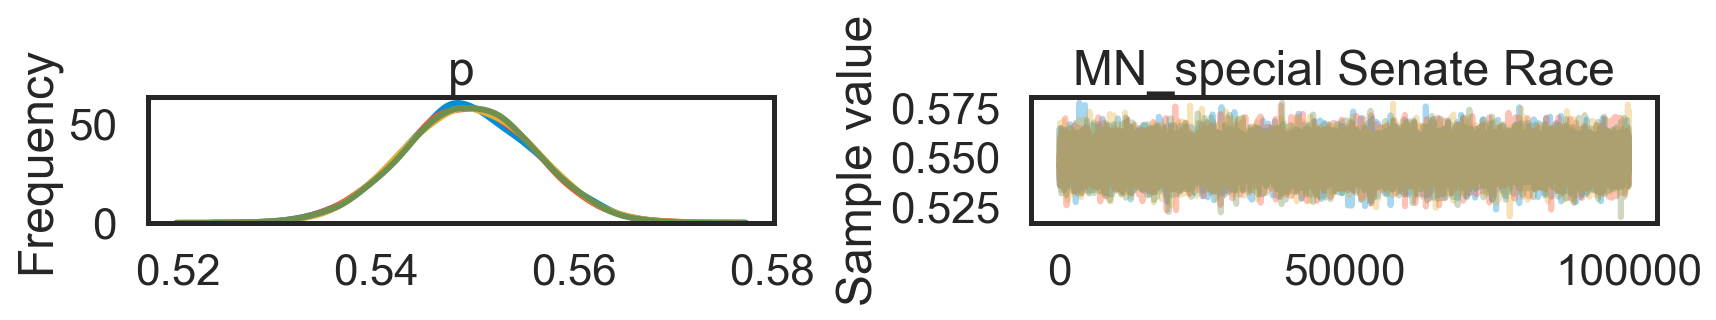

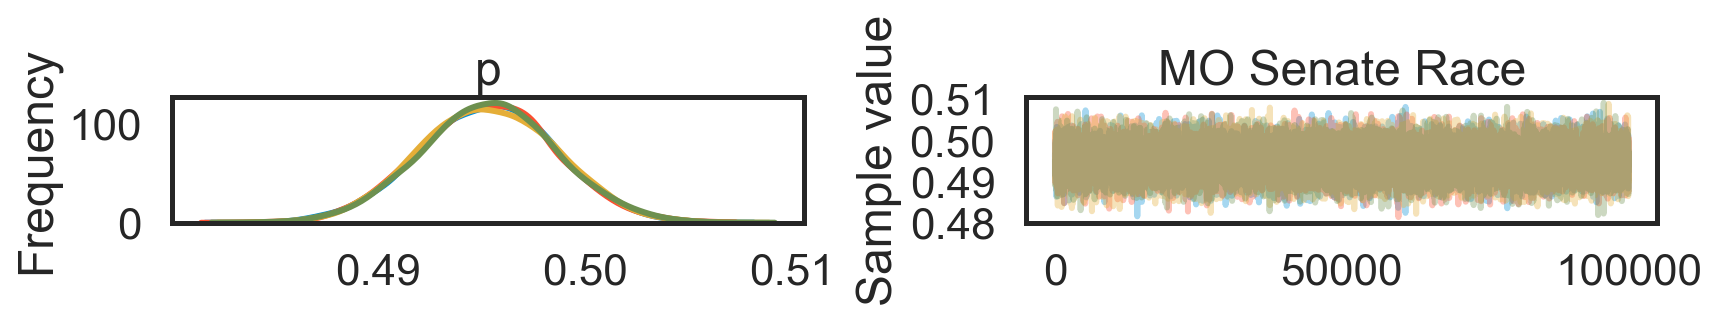

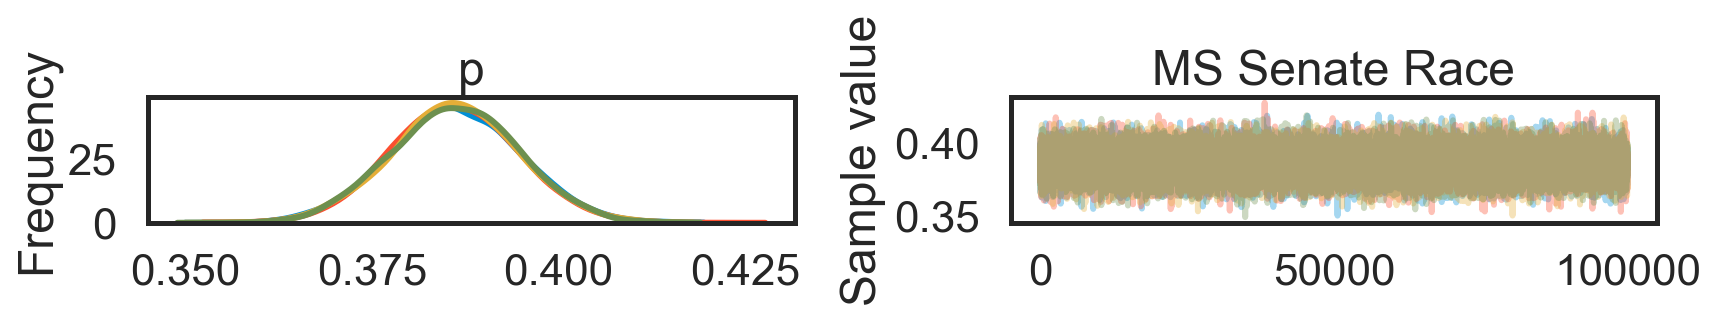

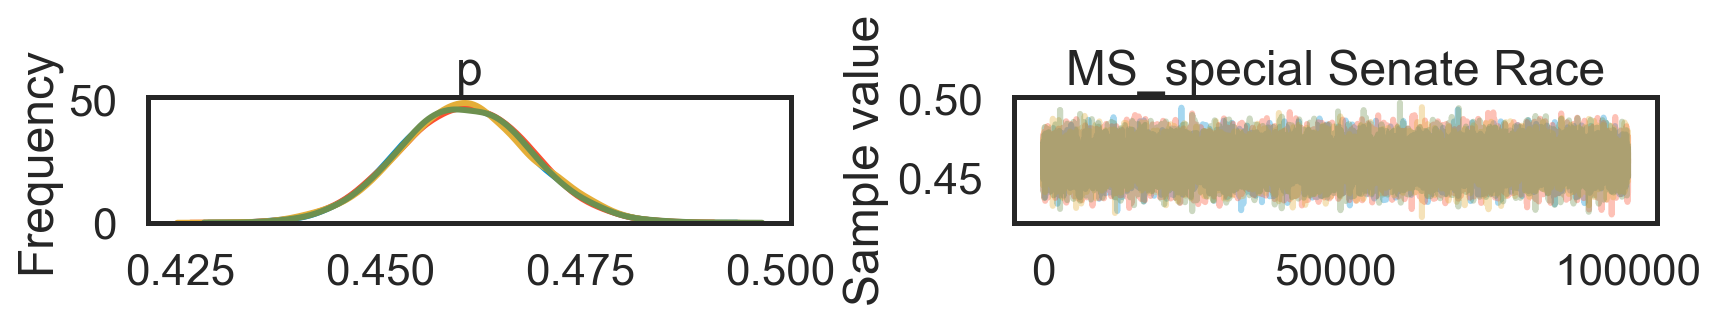

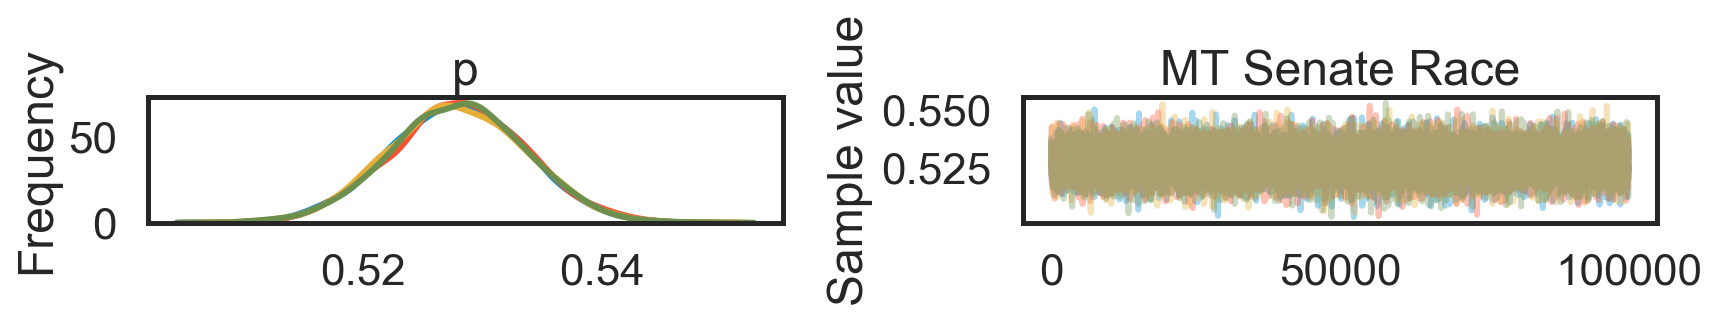

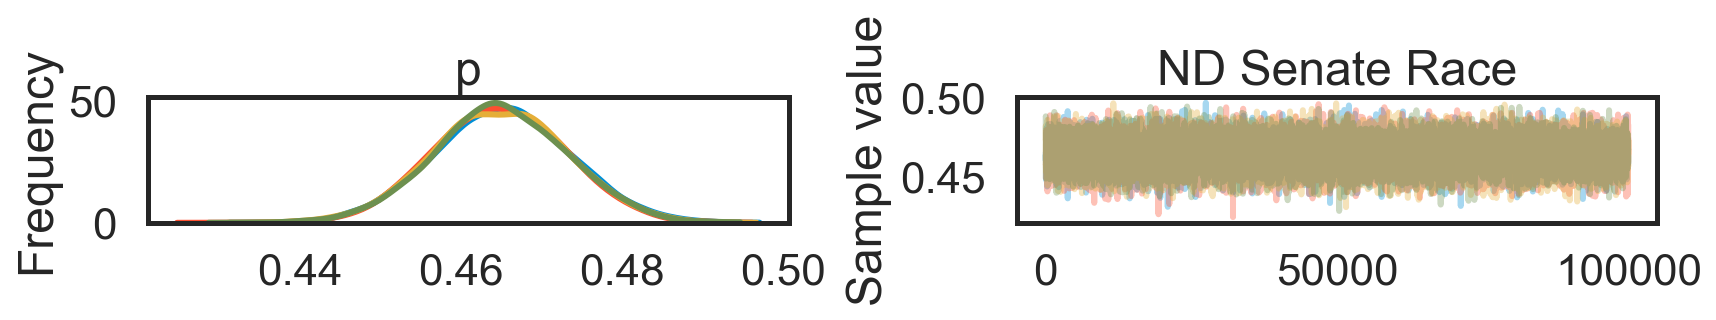

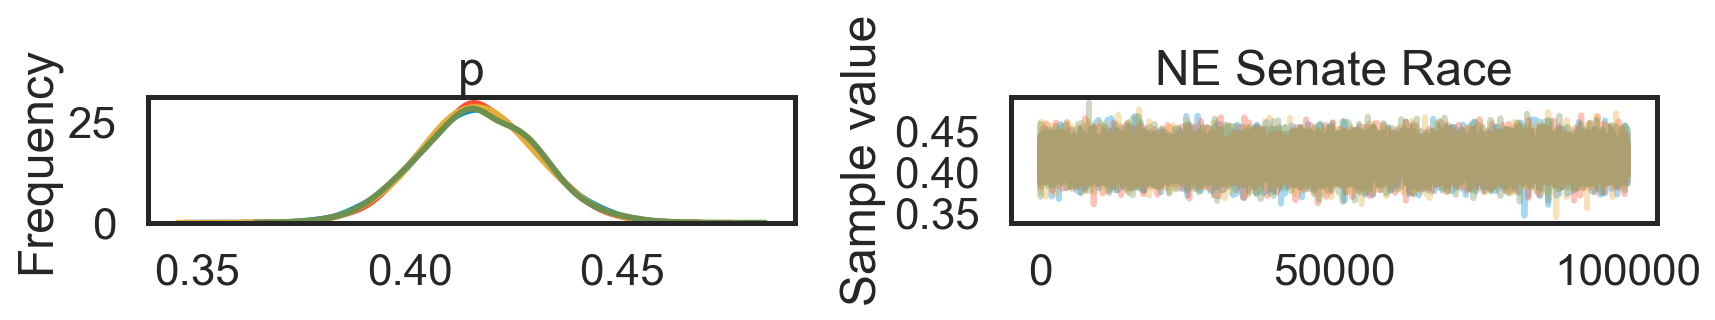

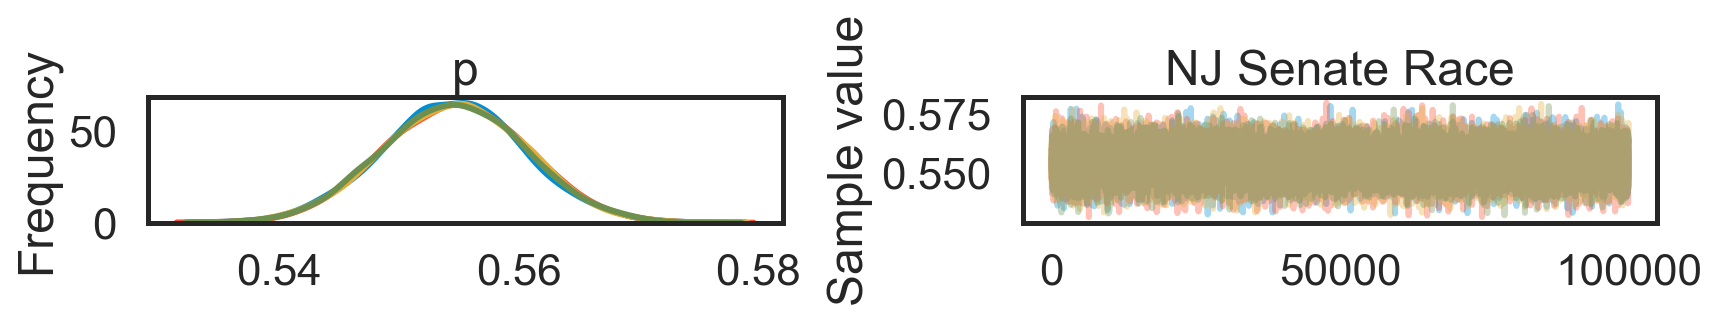

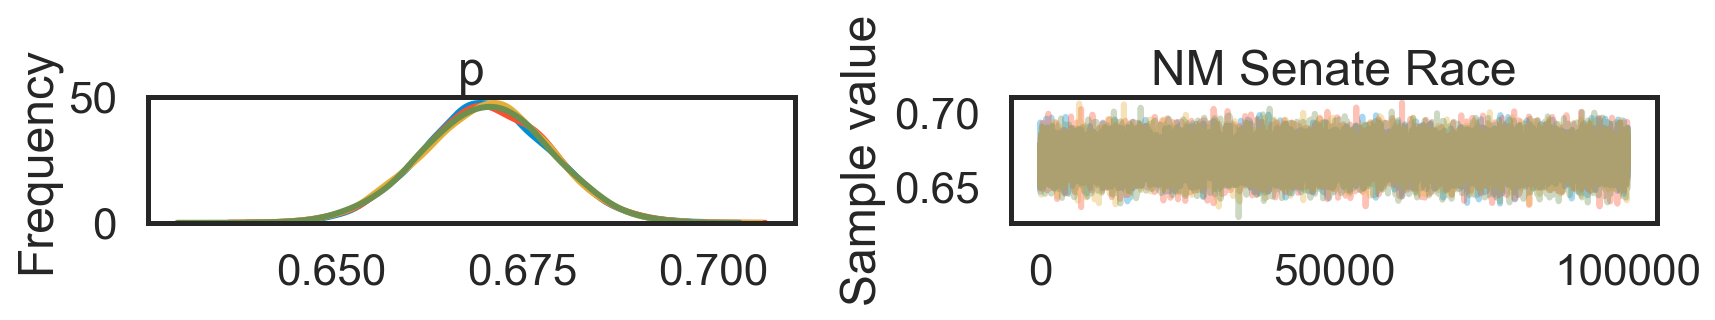

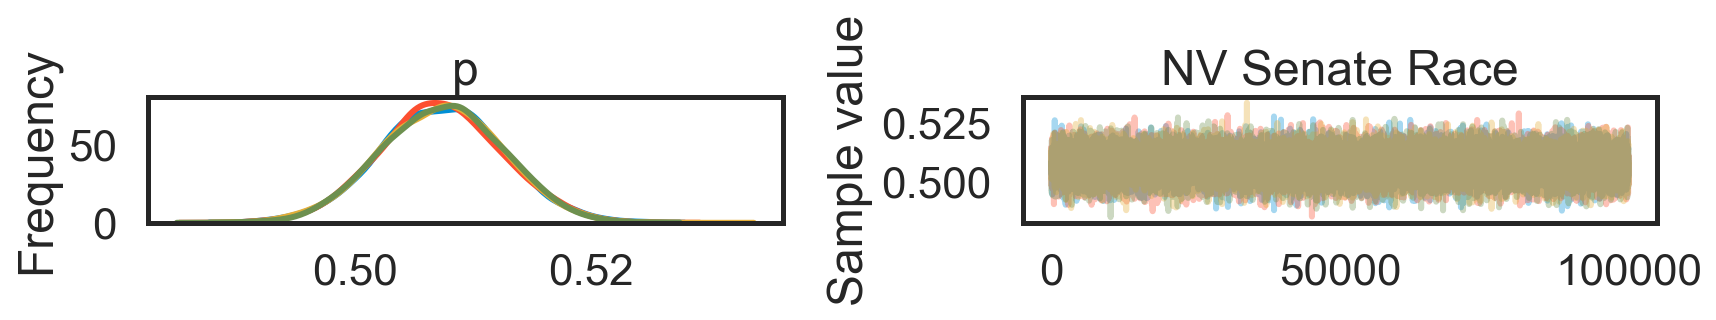

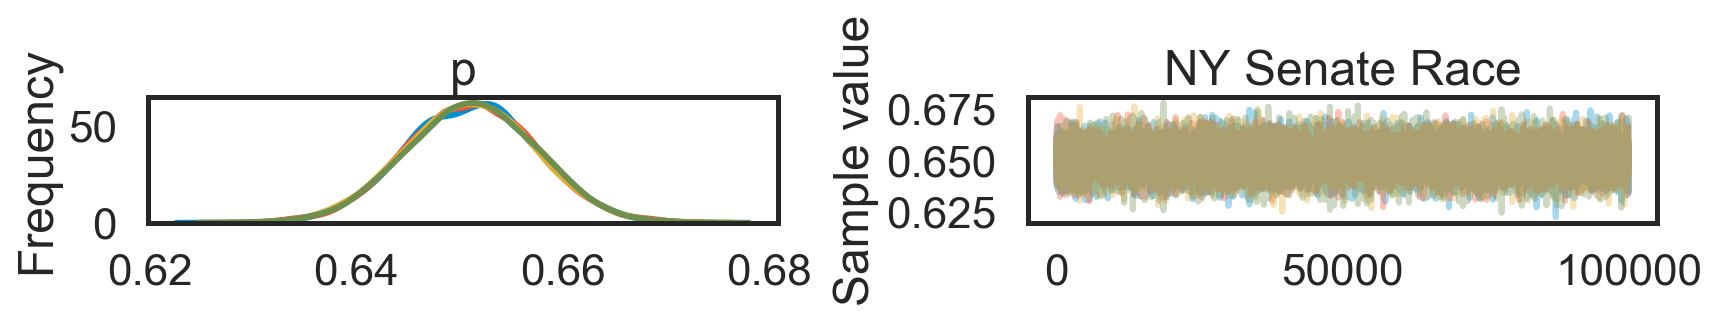

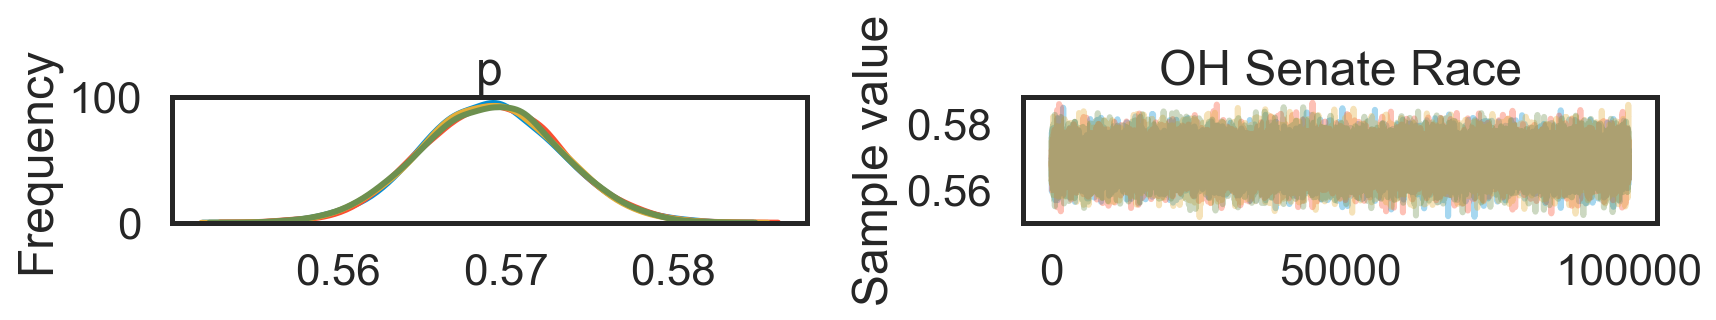

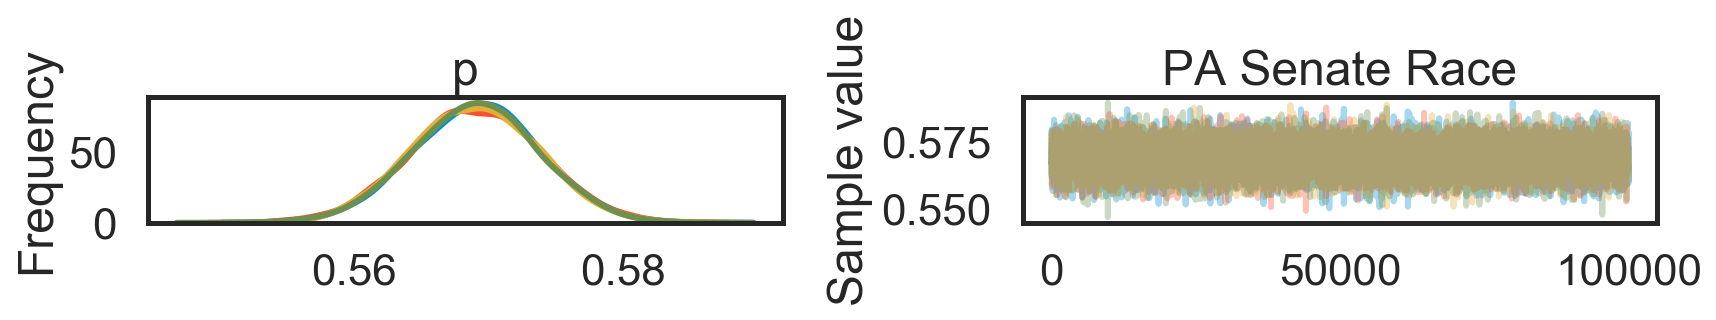

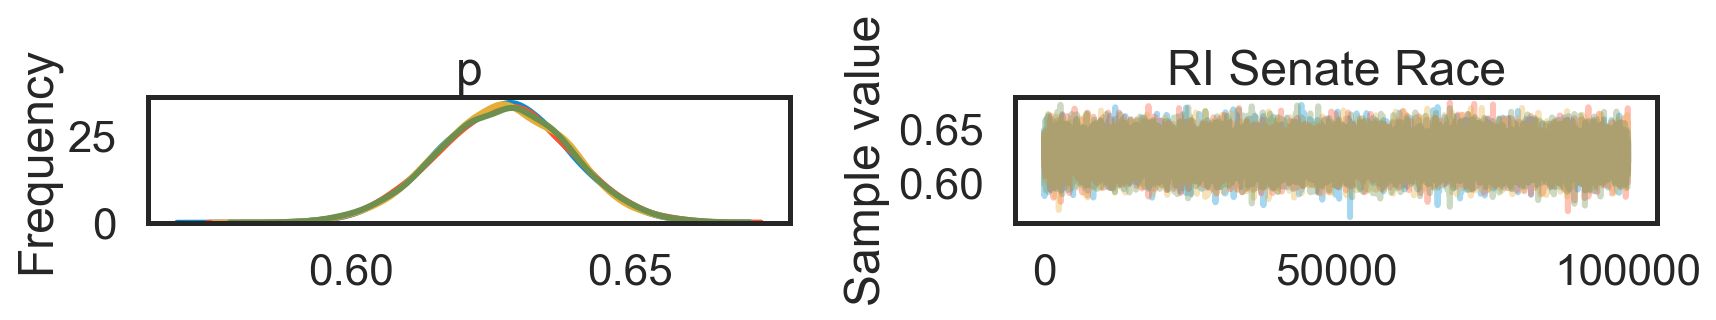

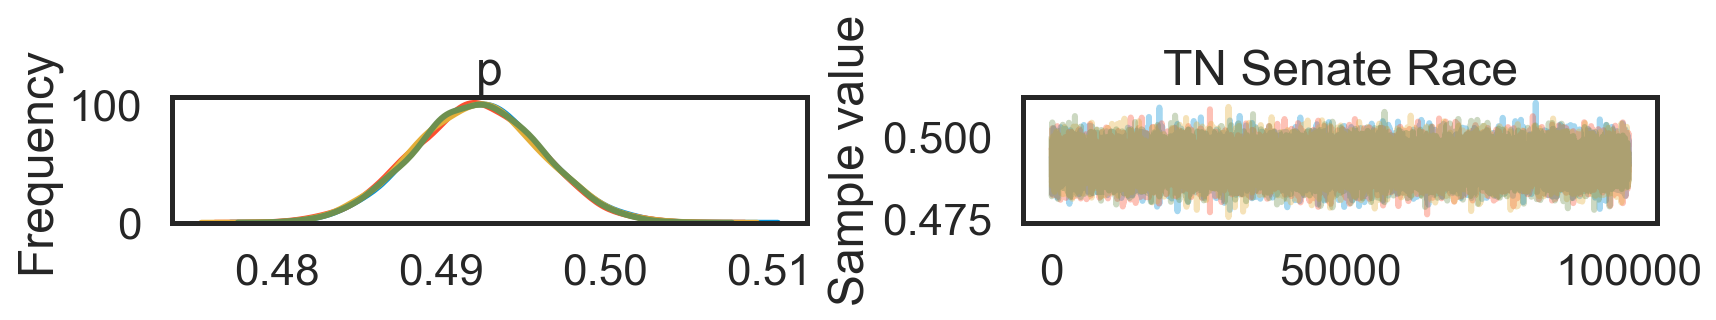

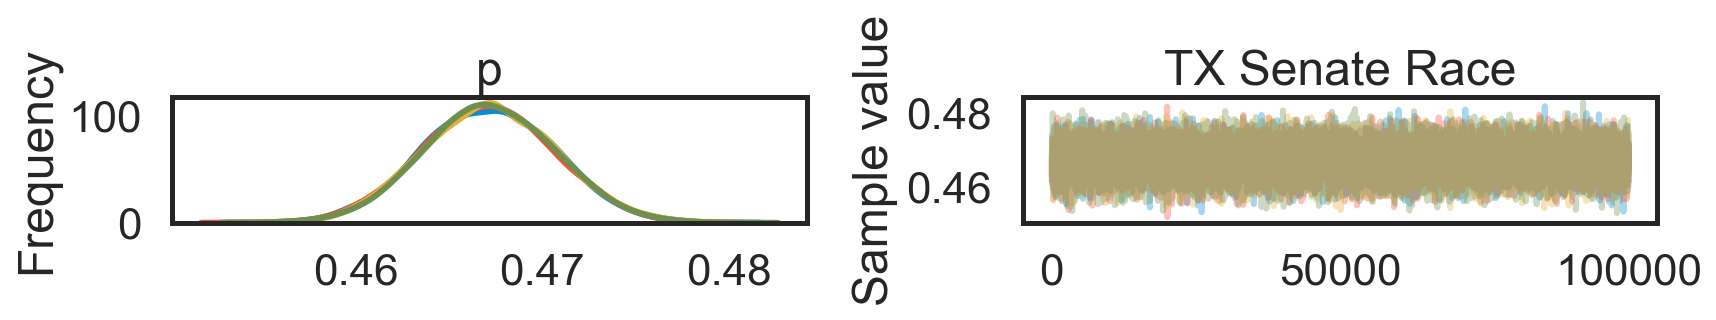

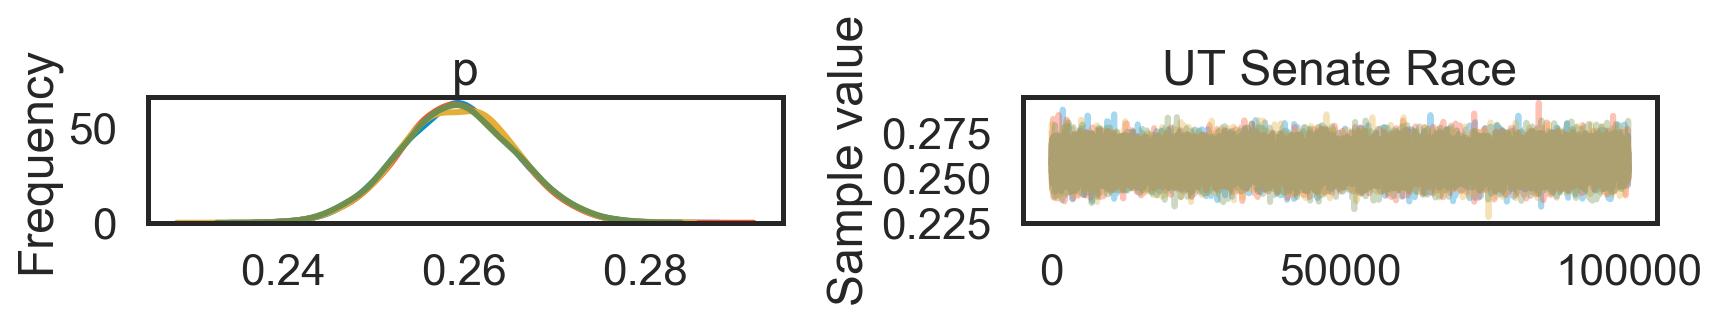

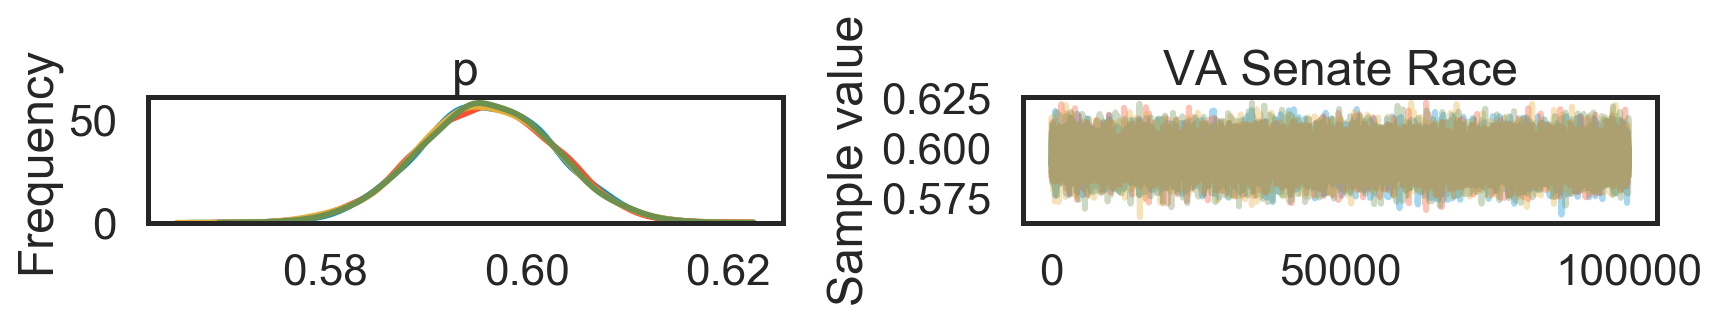

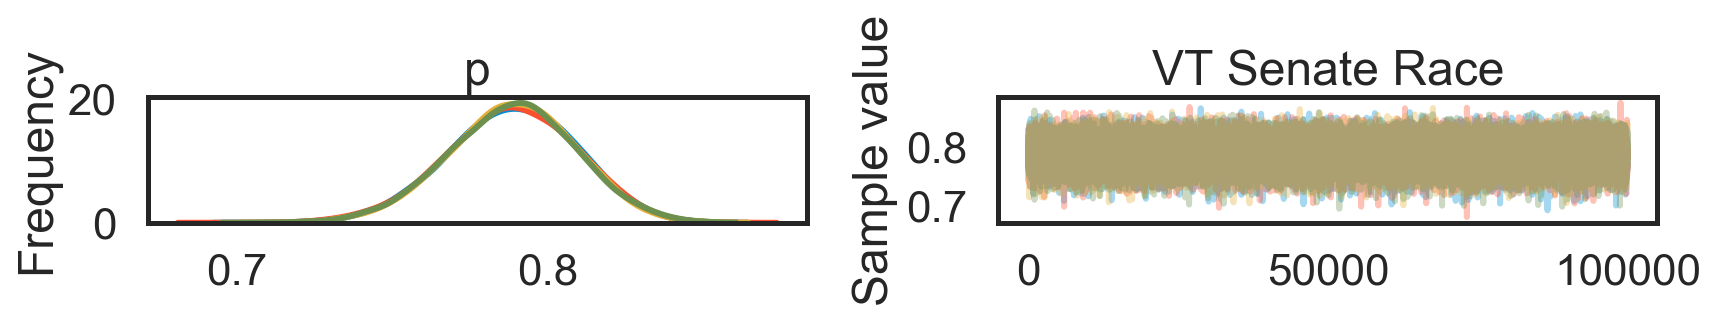

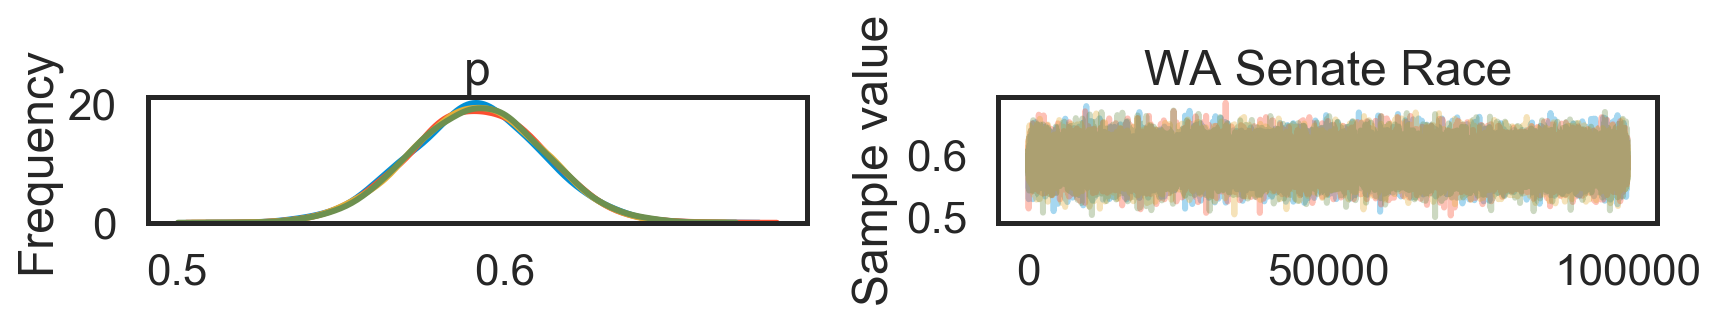

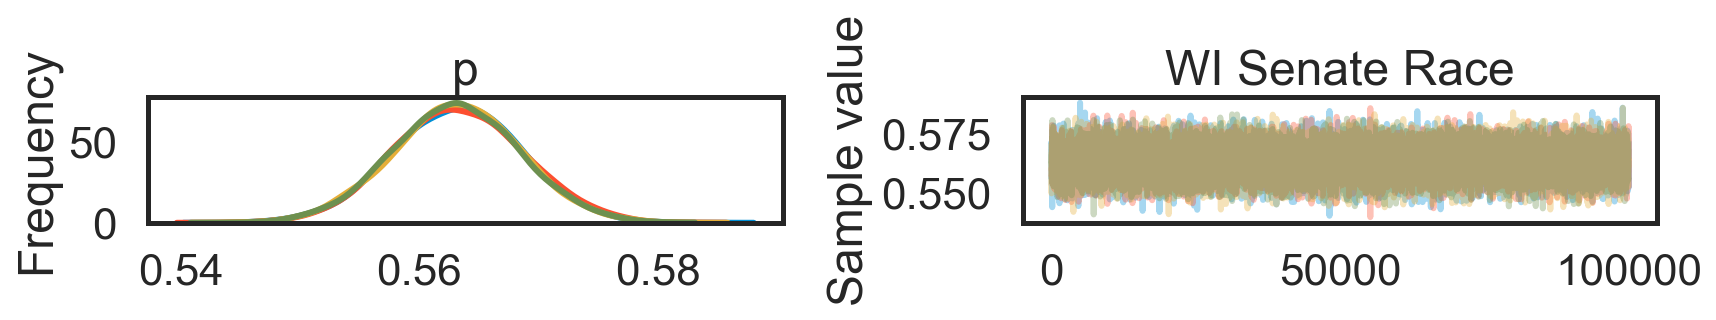

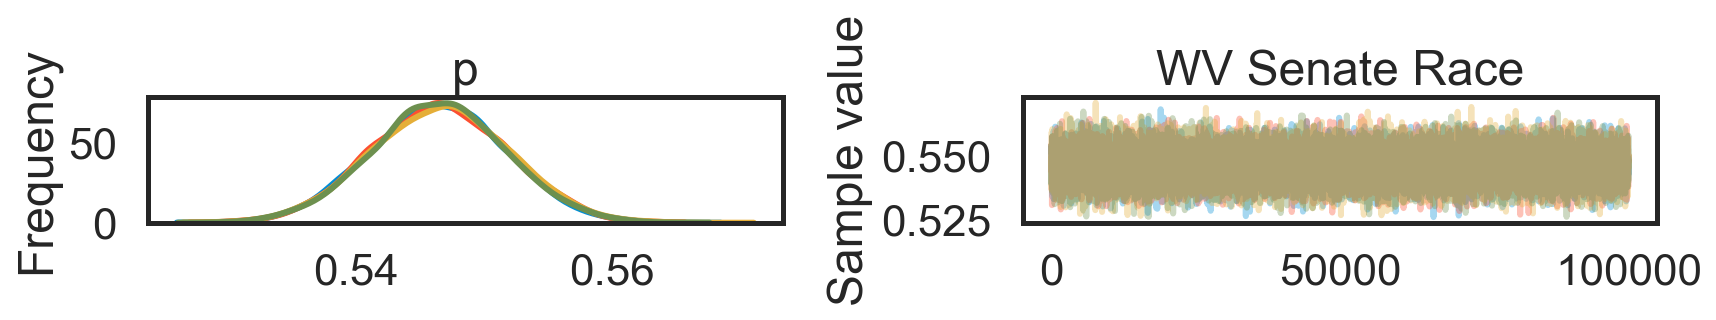

In [12]:
for ind in range(len(state_priors)):
    s = states[ind]
    pm.traceplot(trace_list[ind])
    plt.title(s+' Senate Race')
    plt.show()

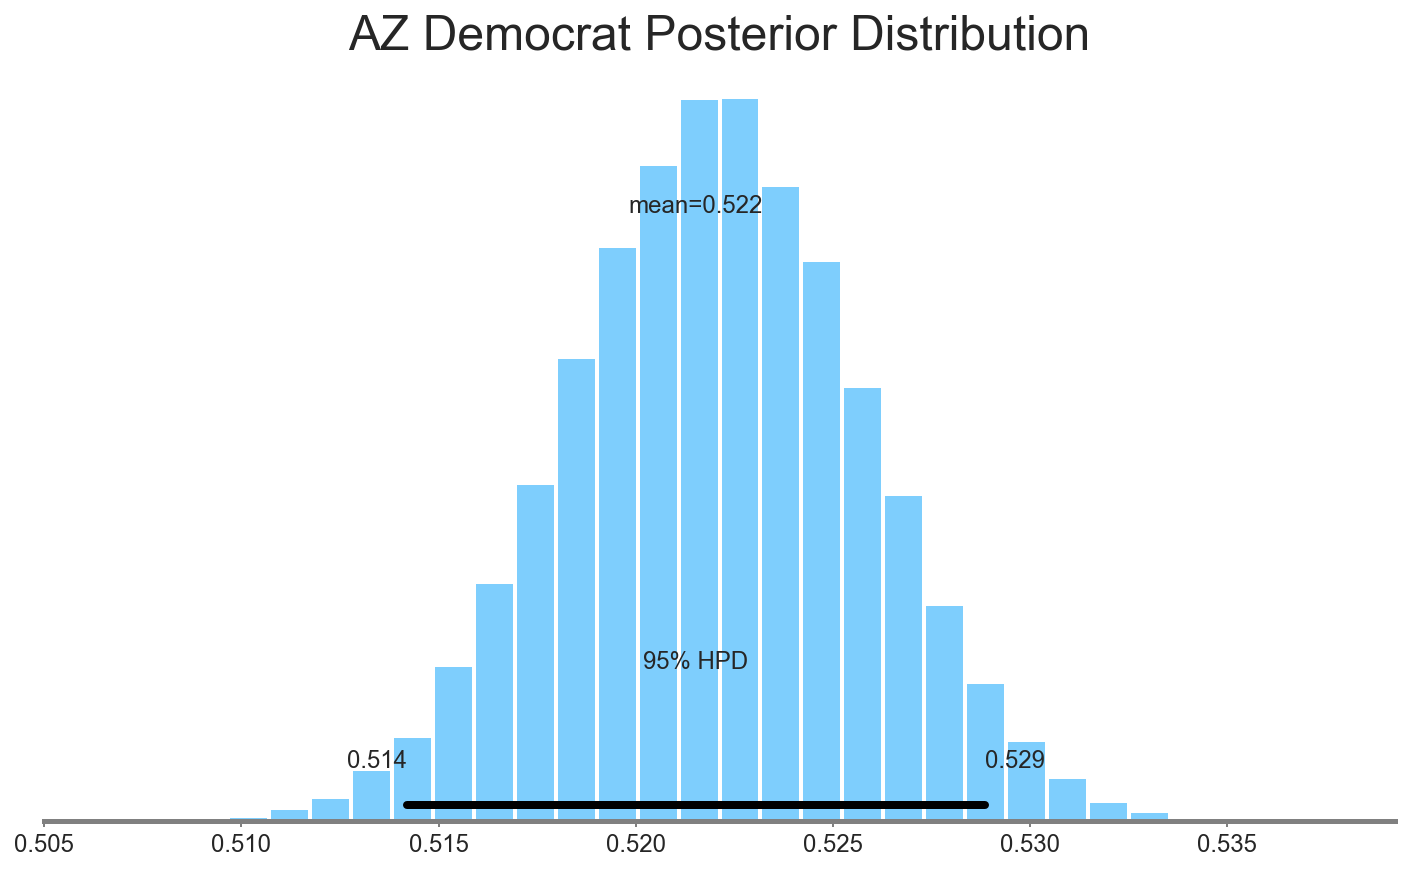

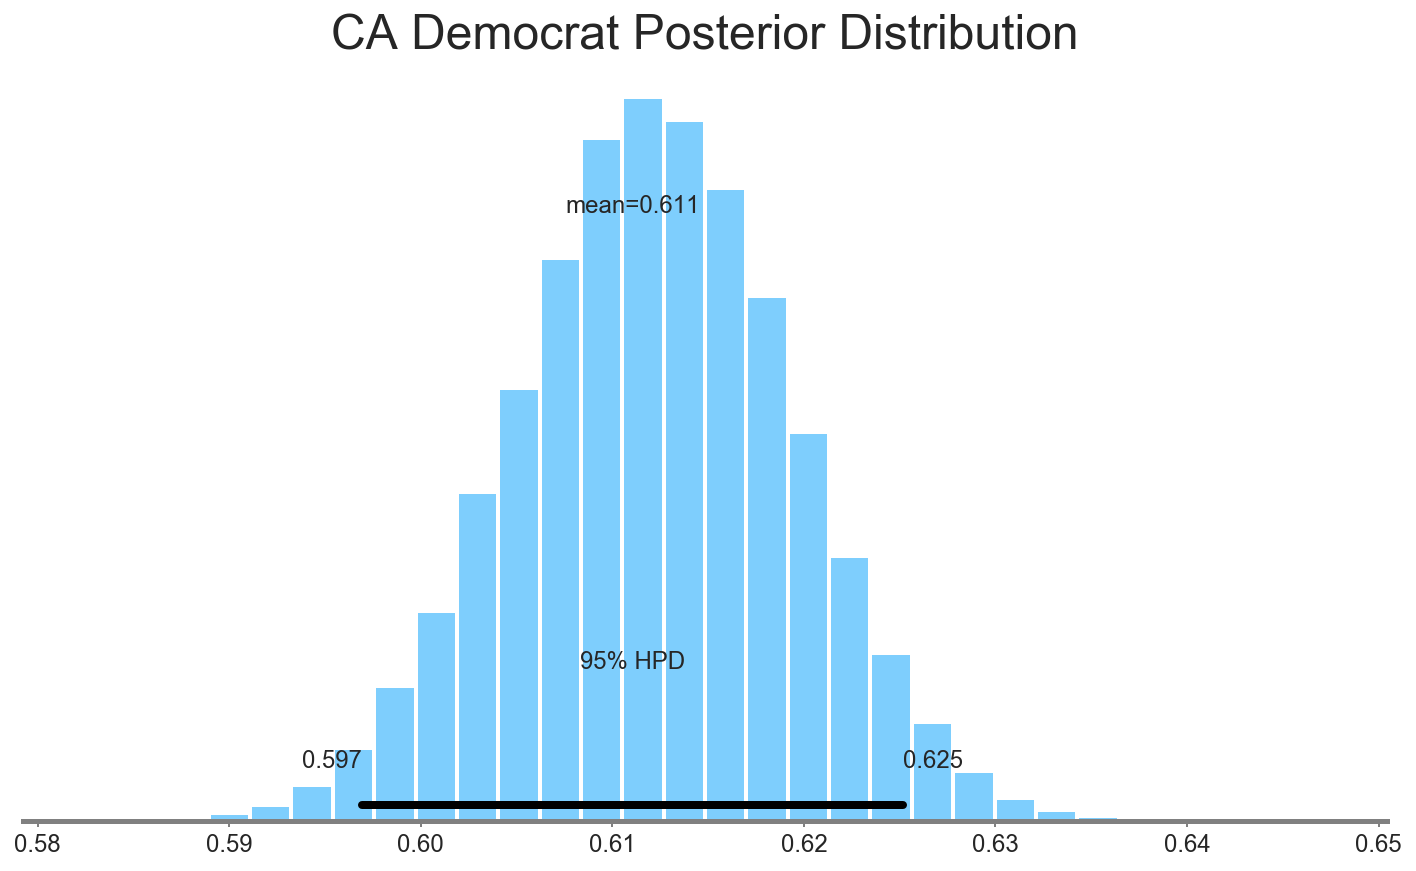

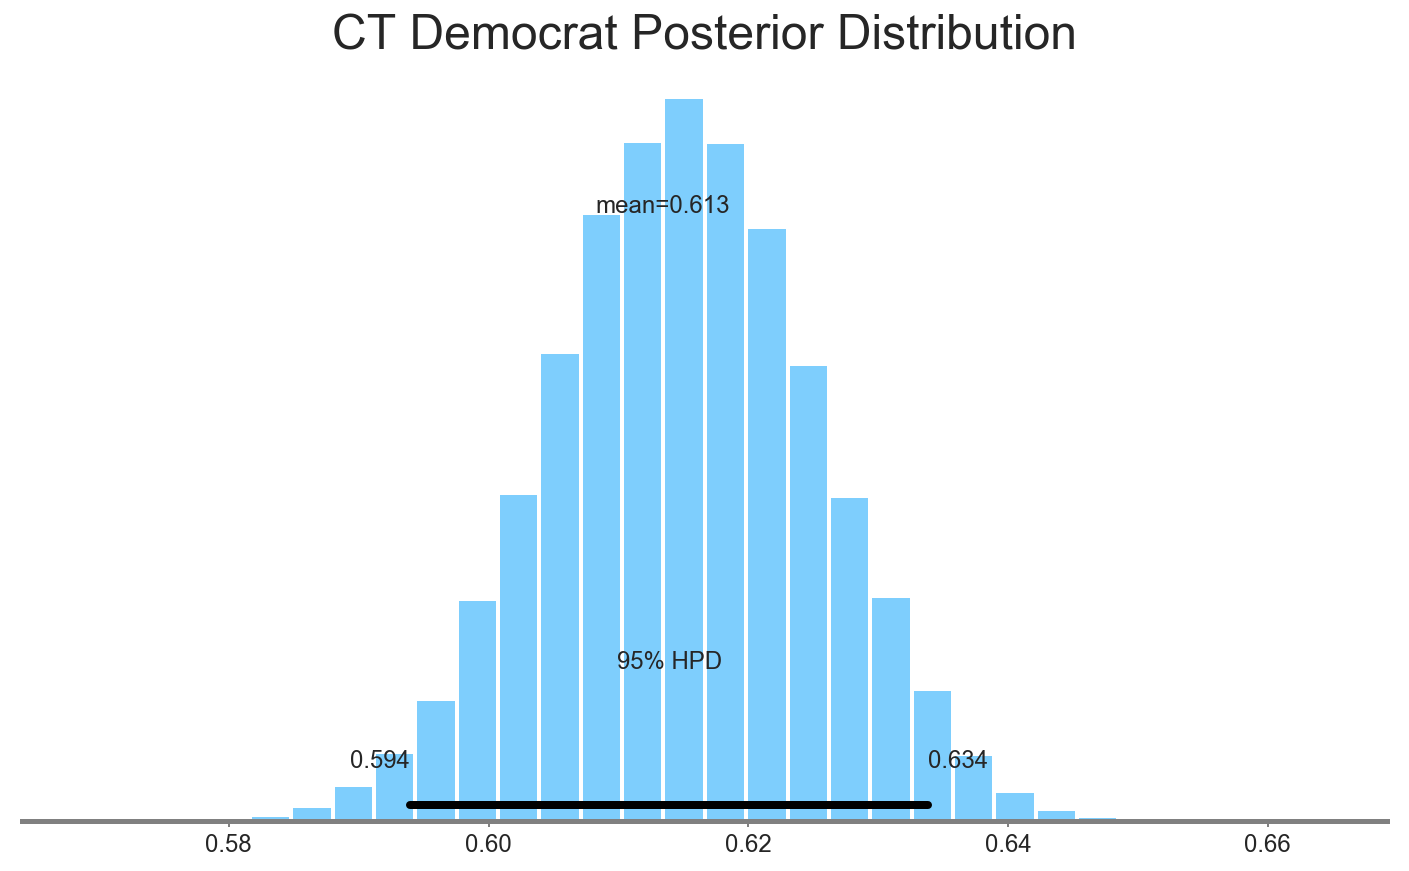

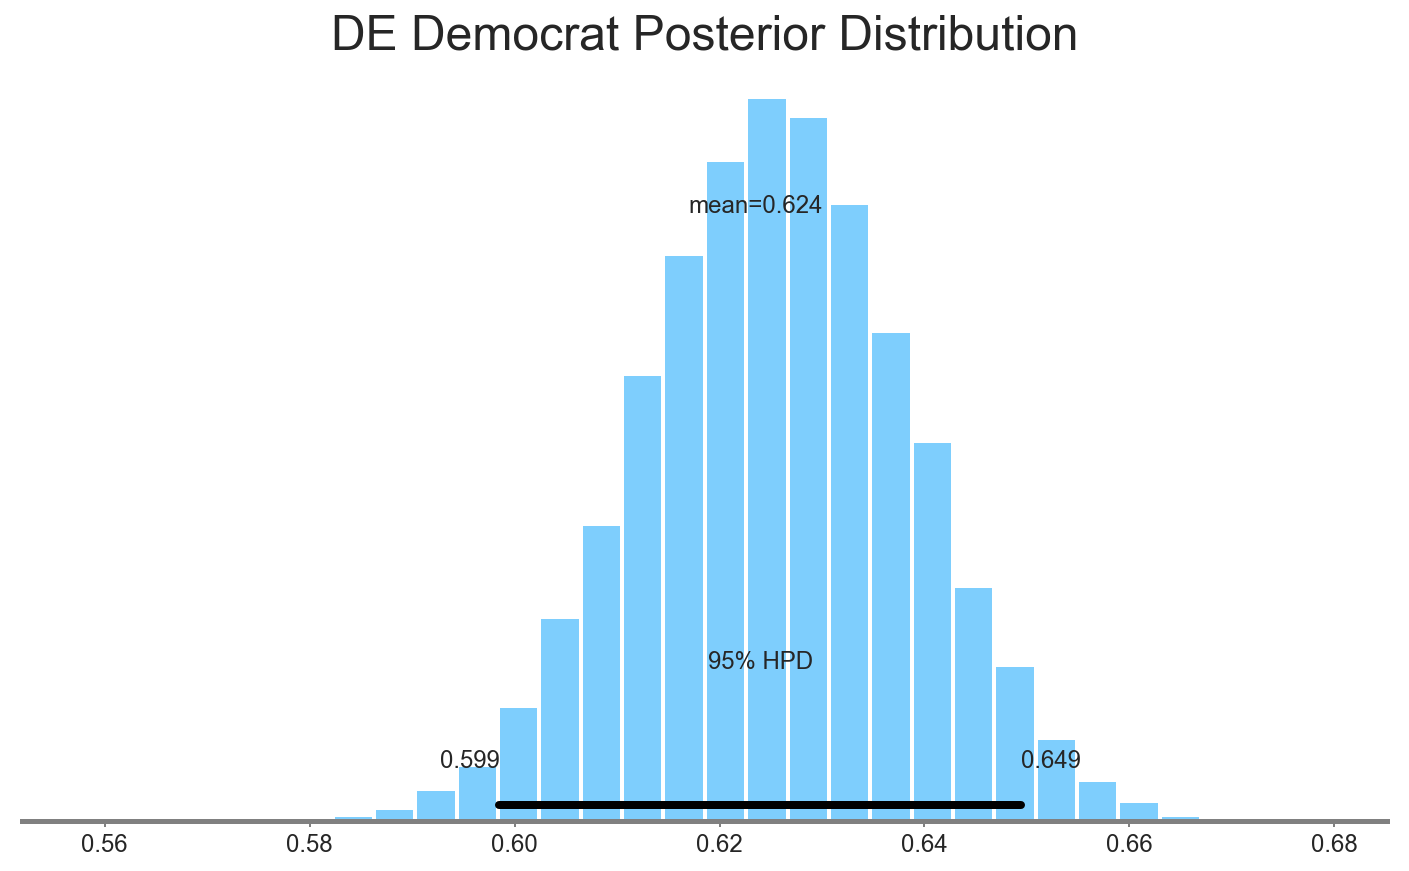

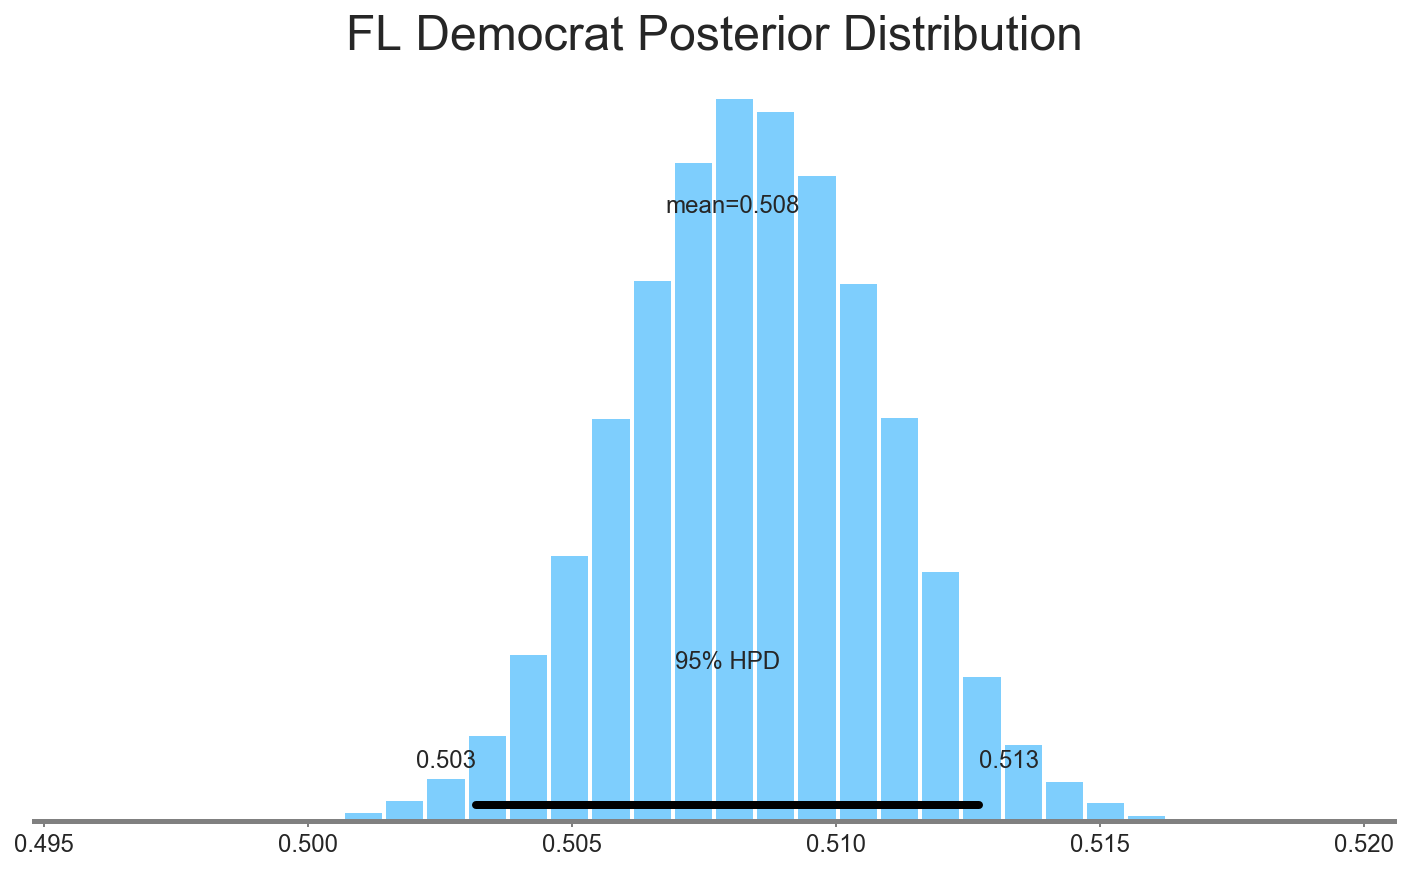

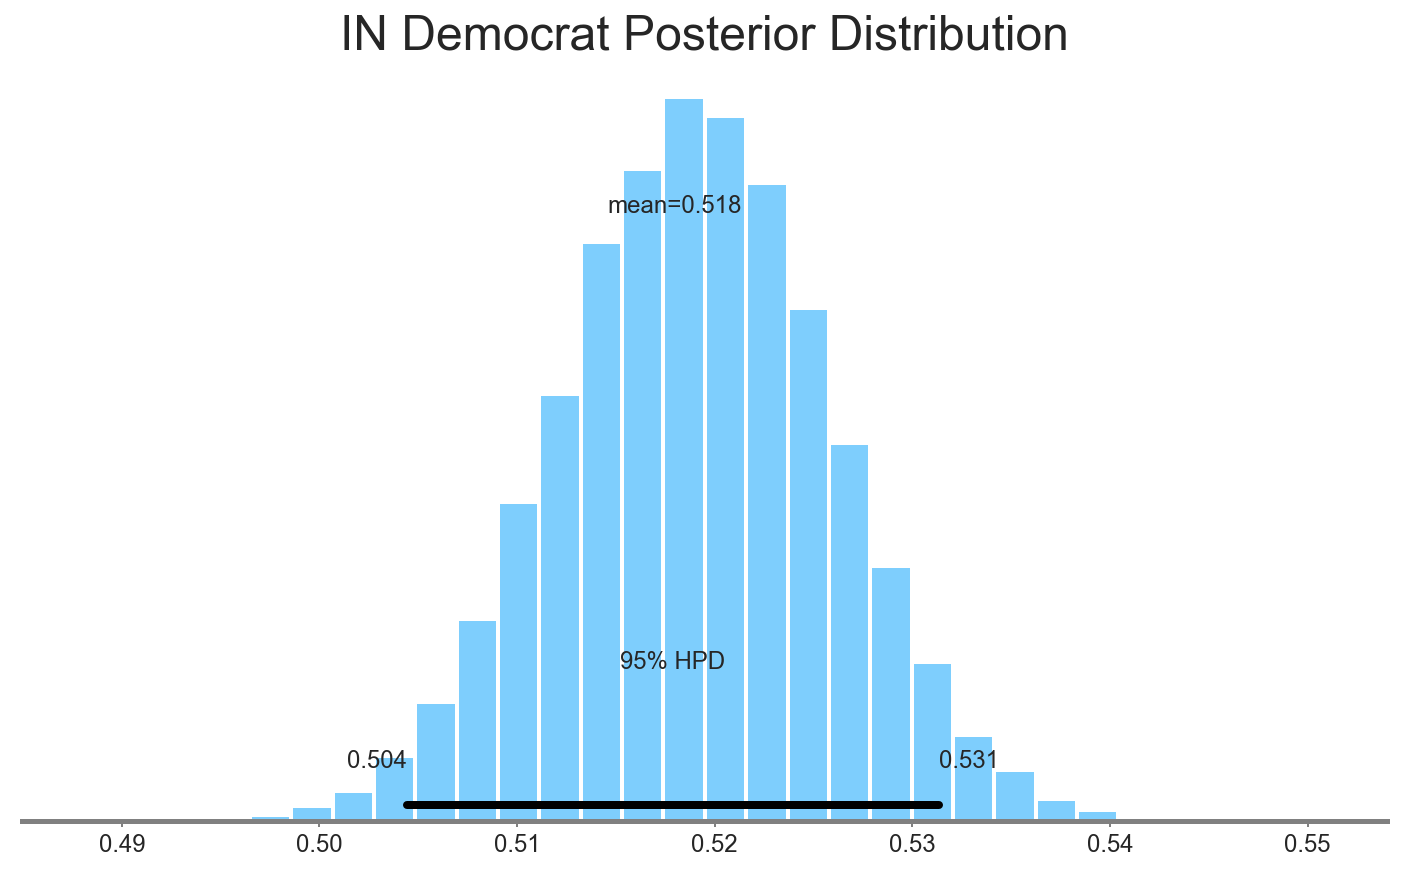

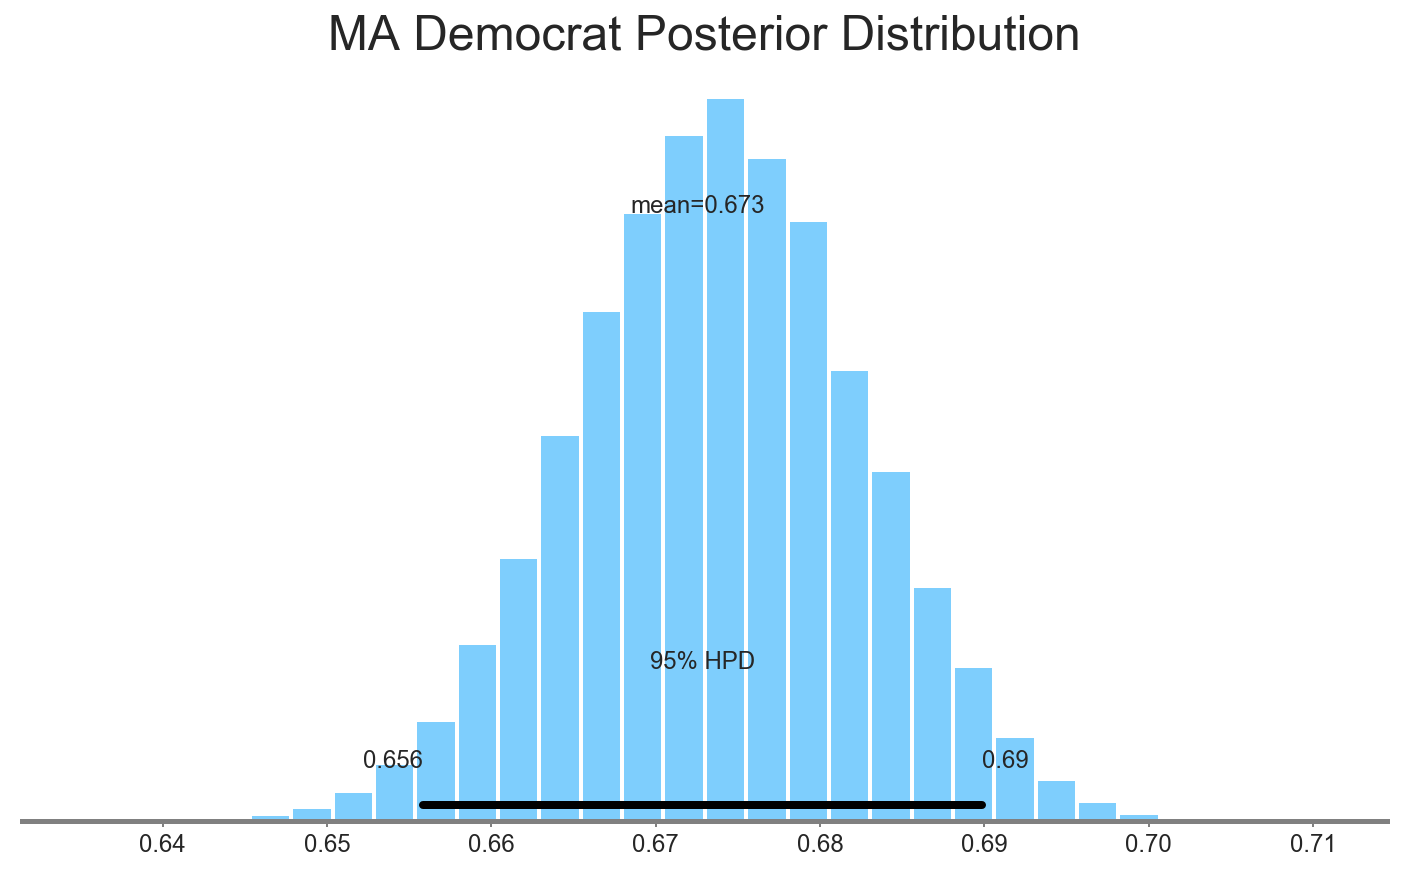

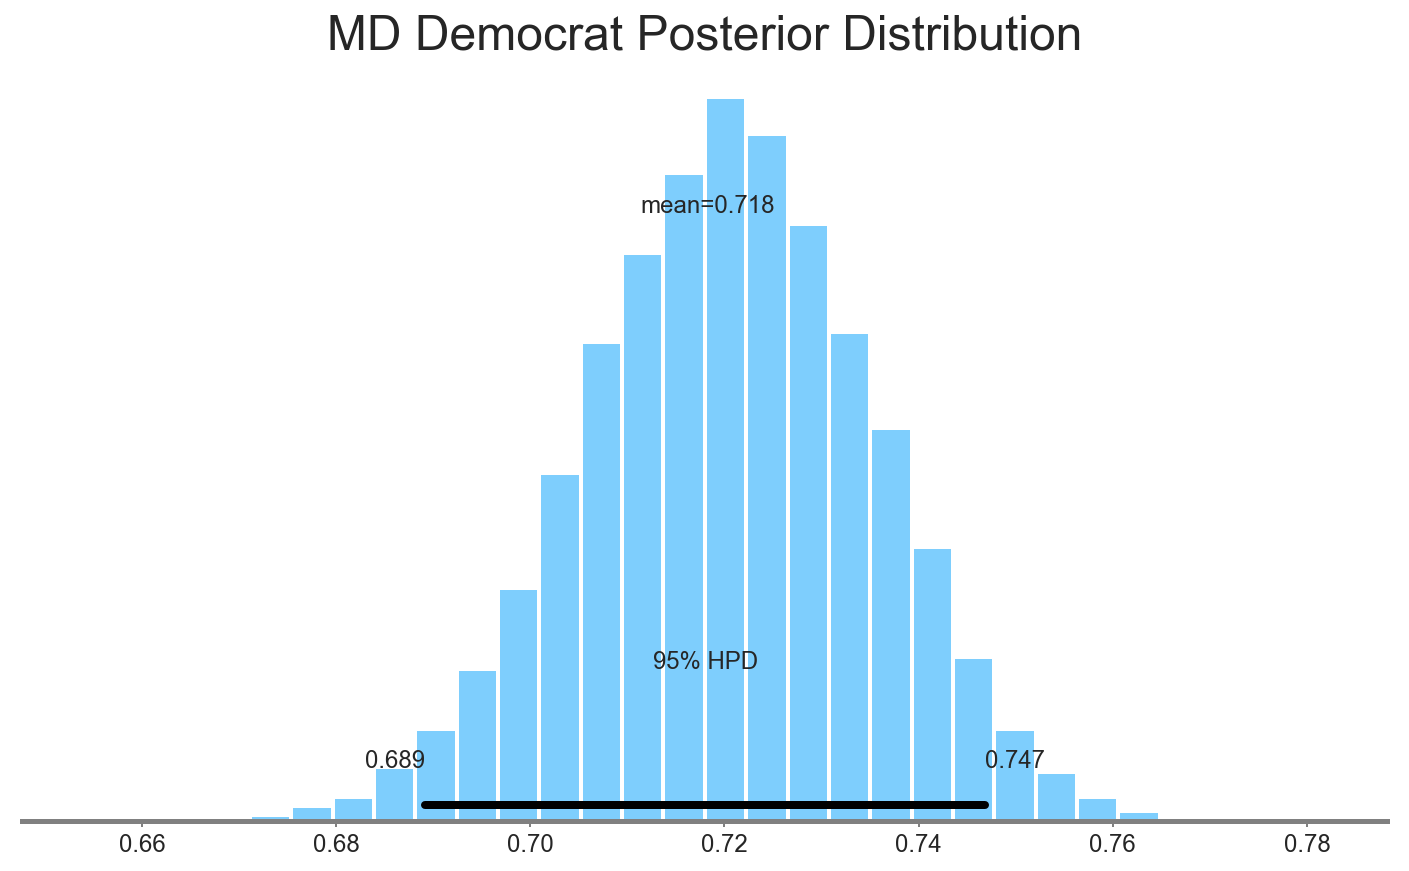

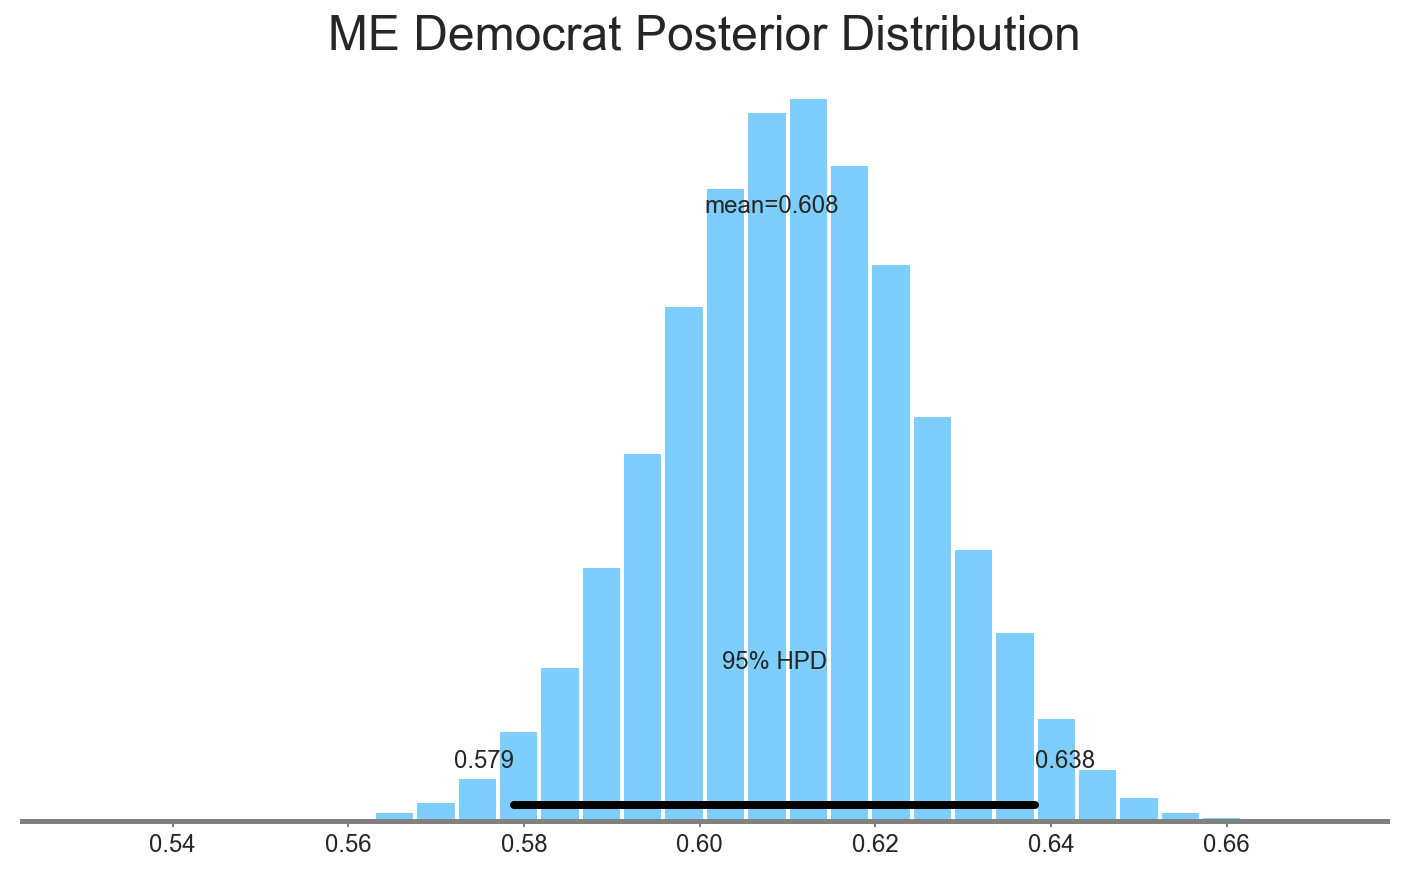

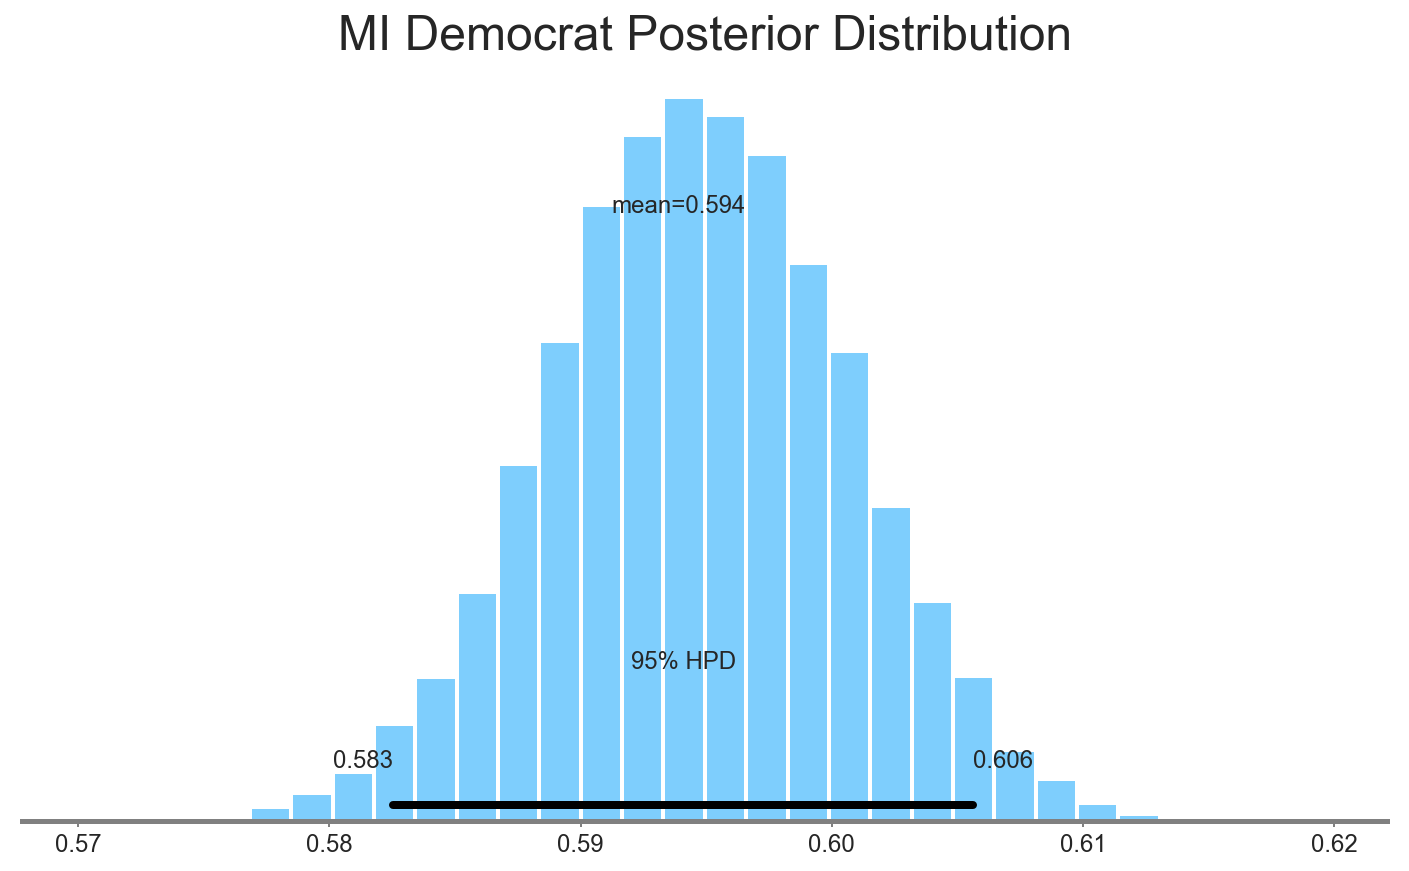

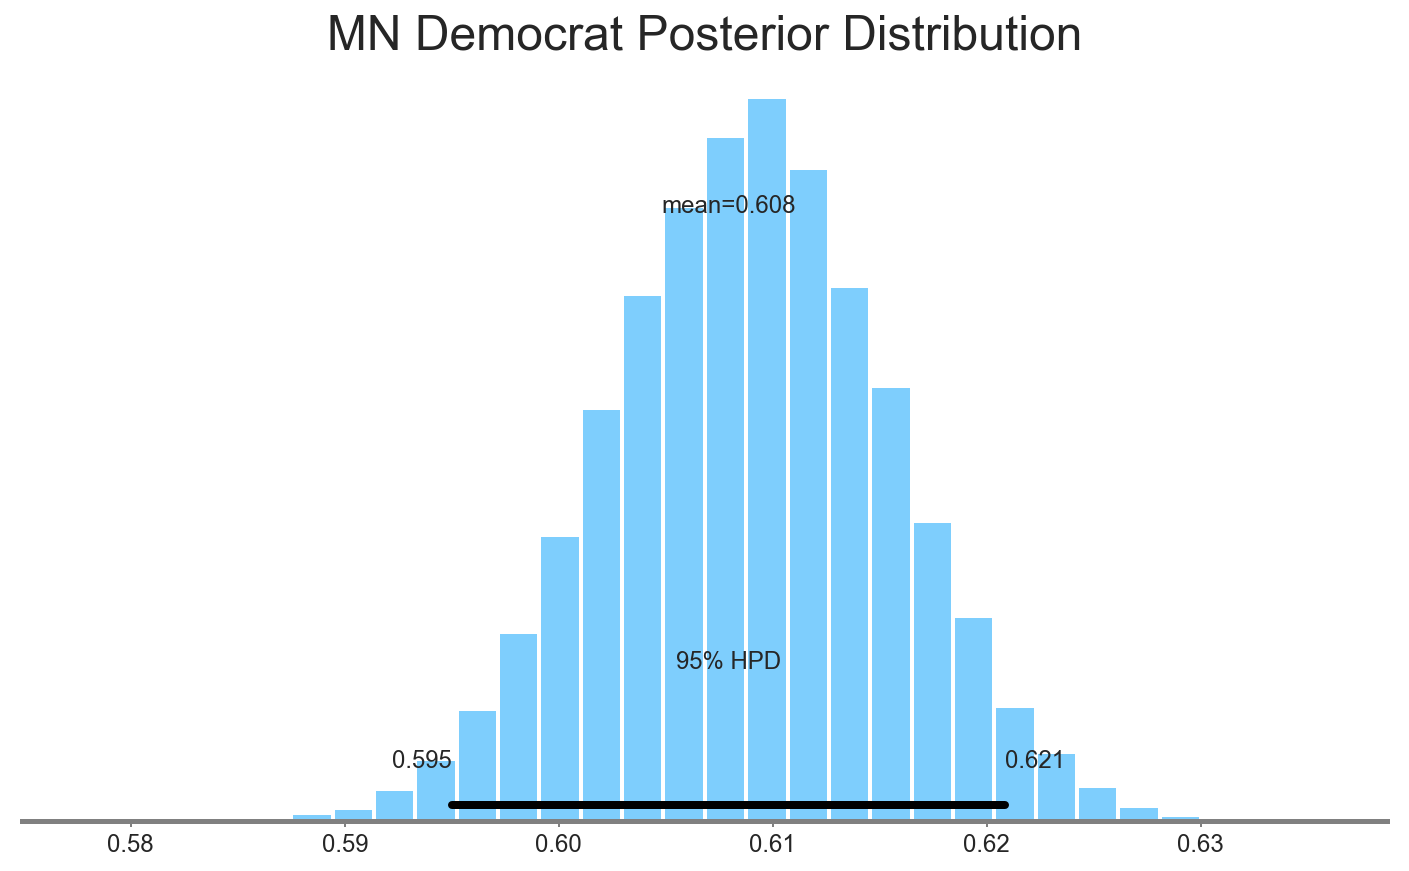

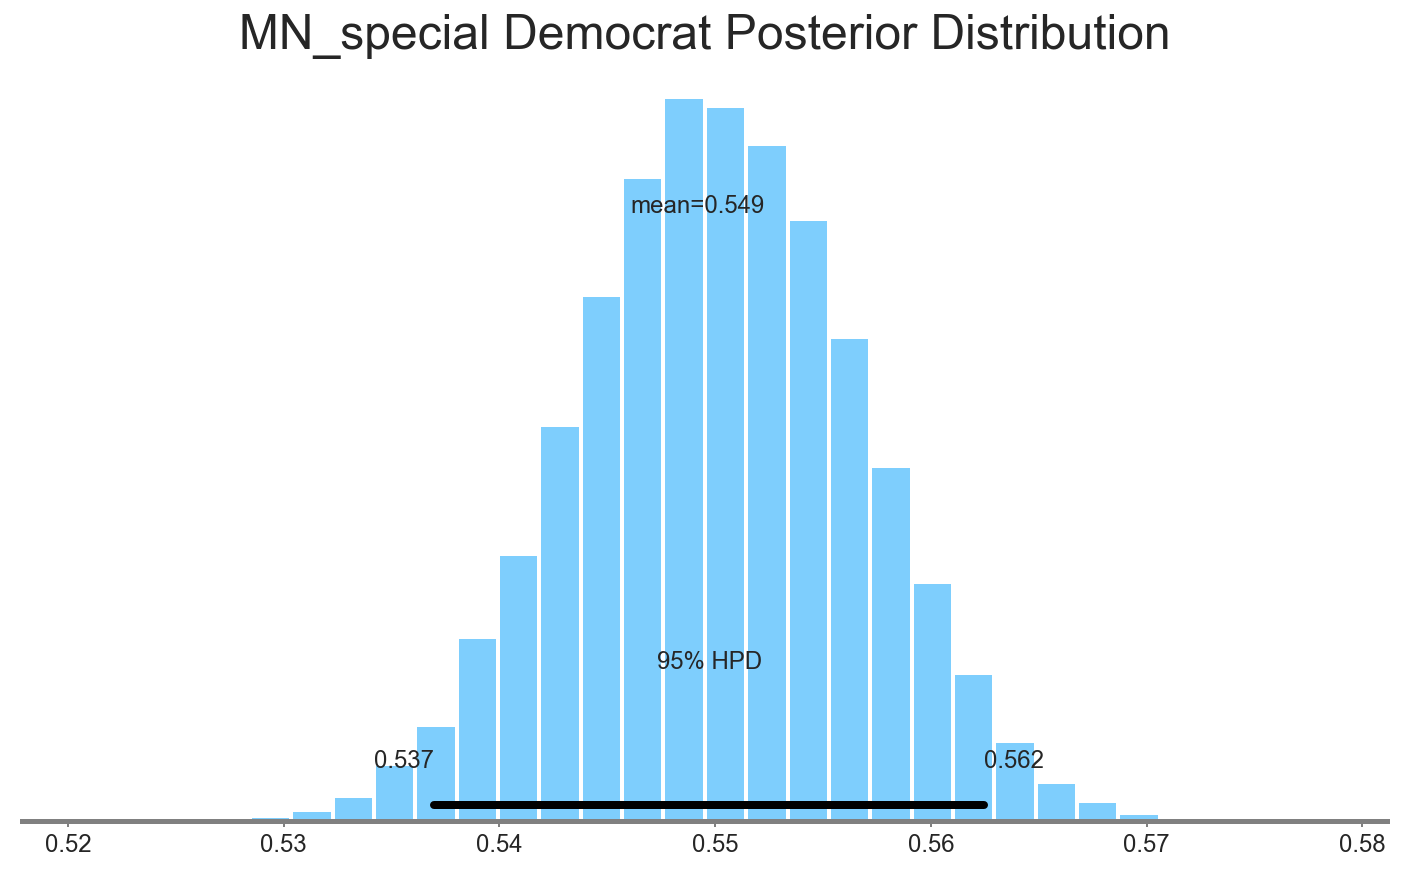

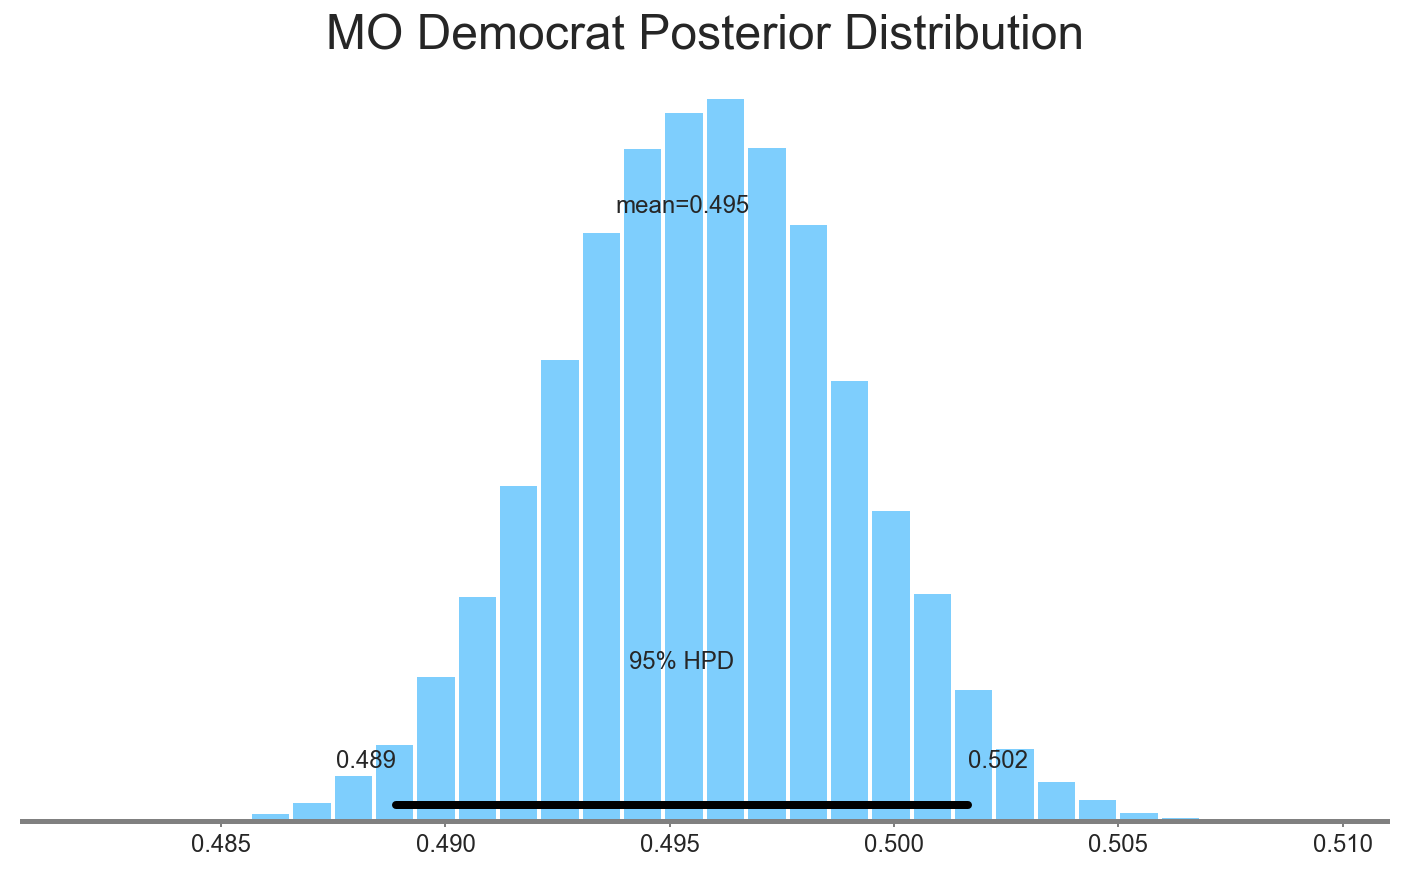

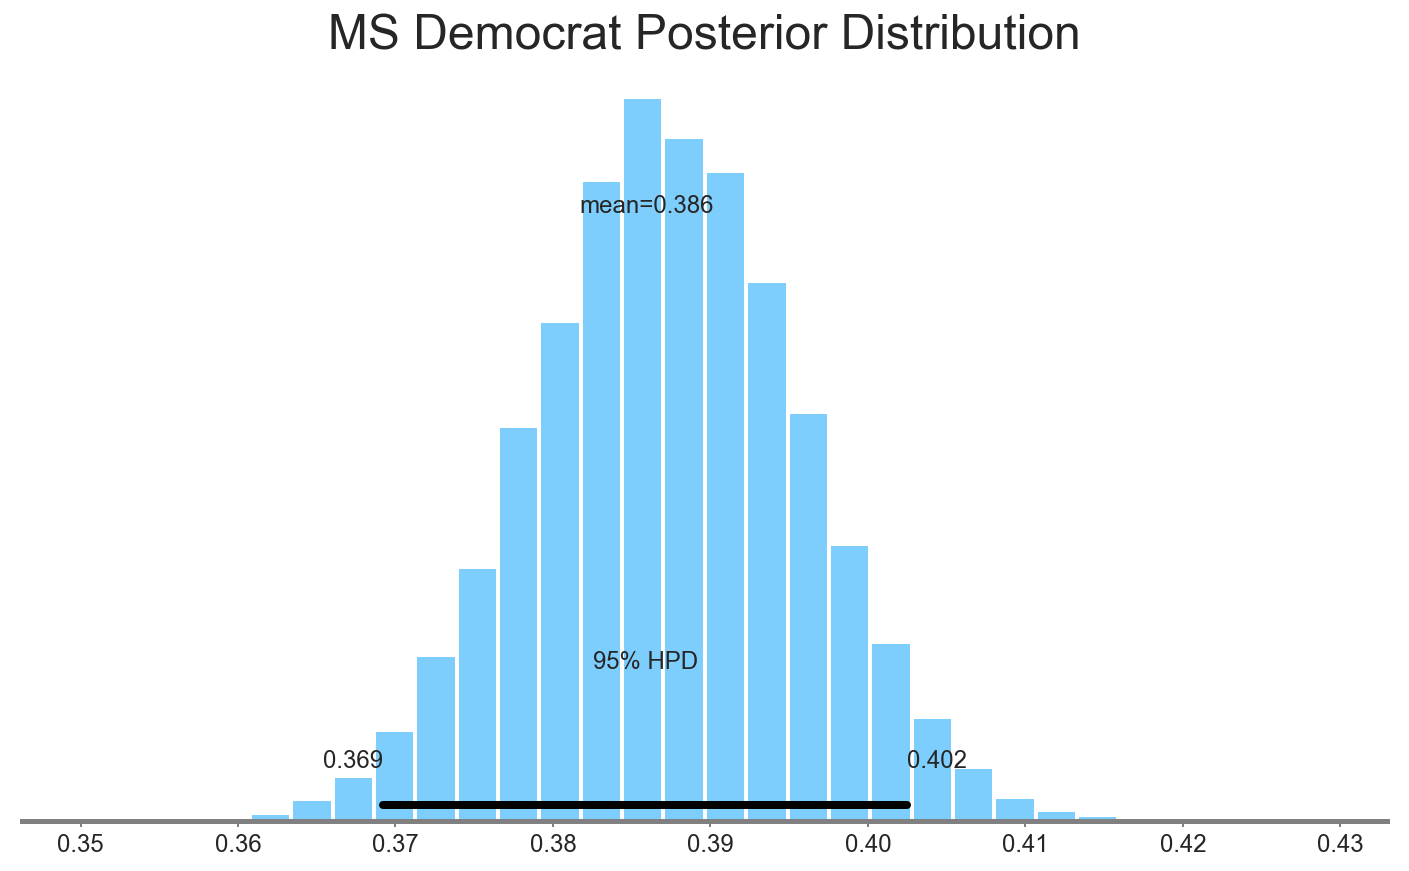

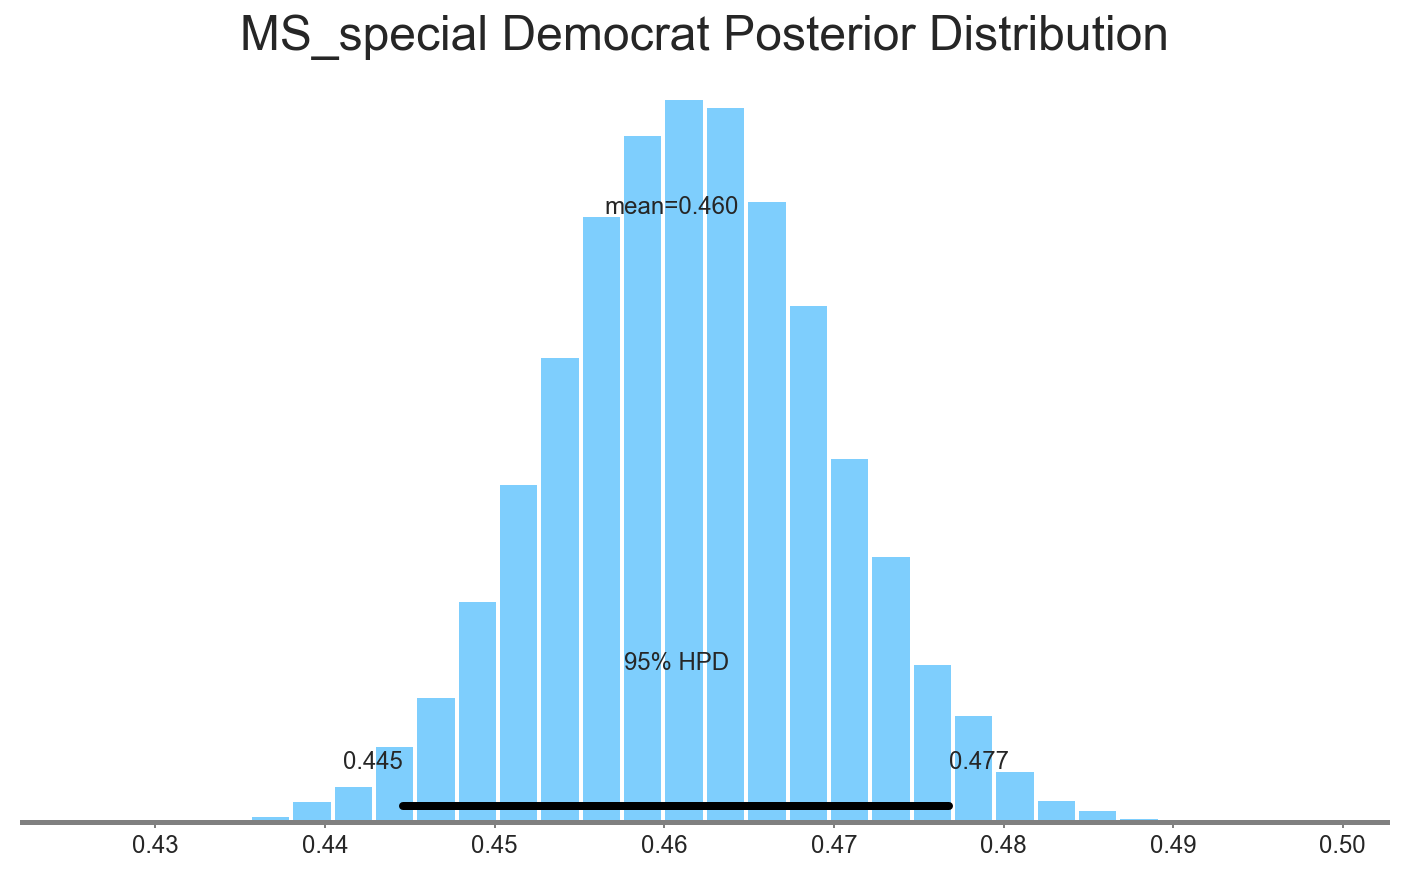

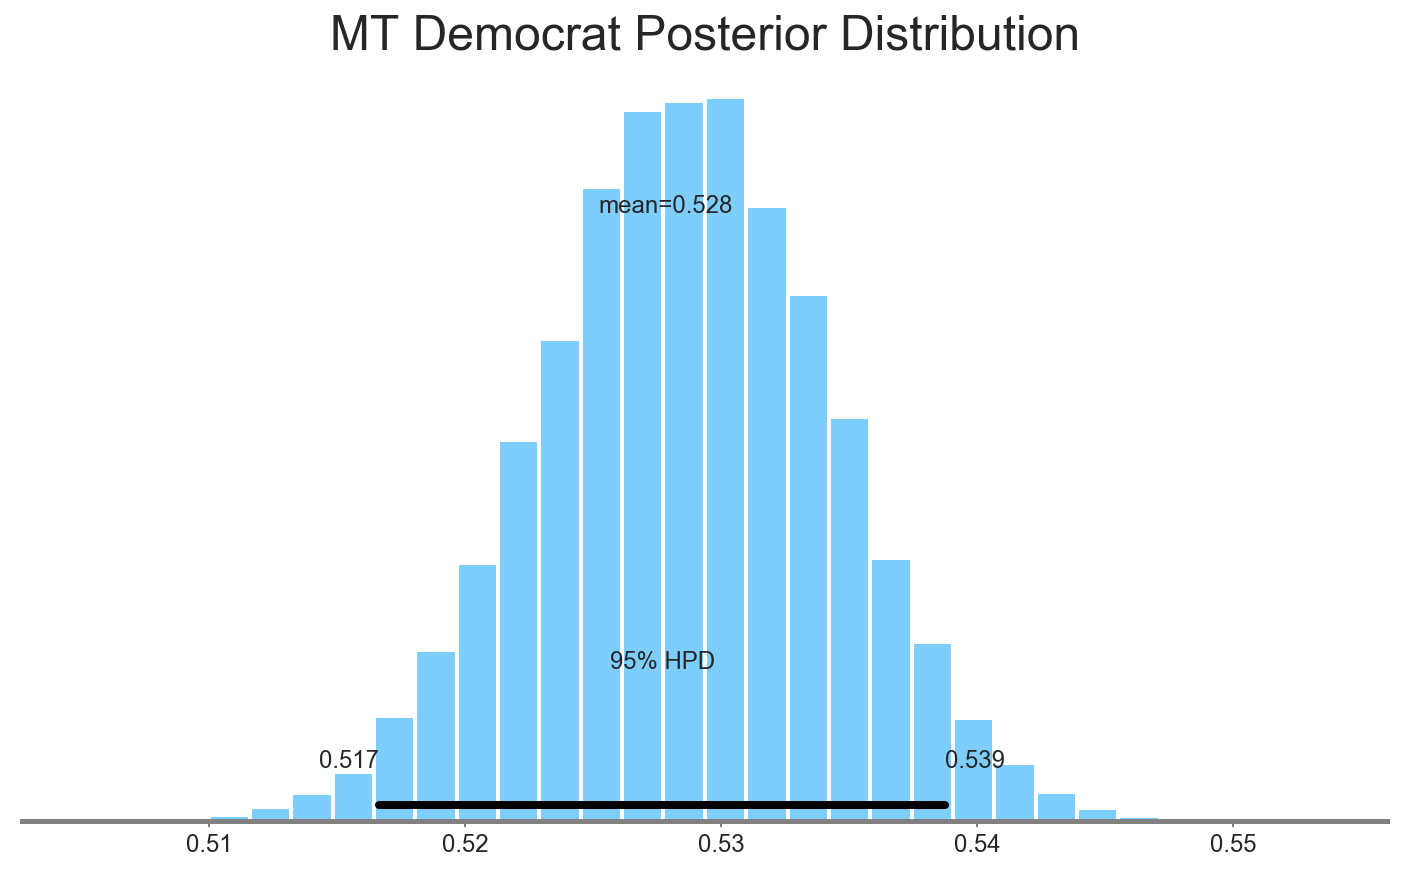

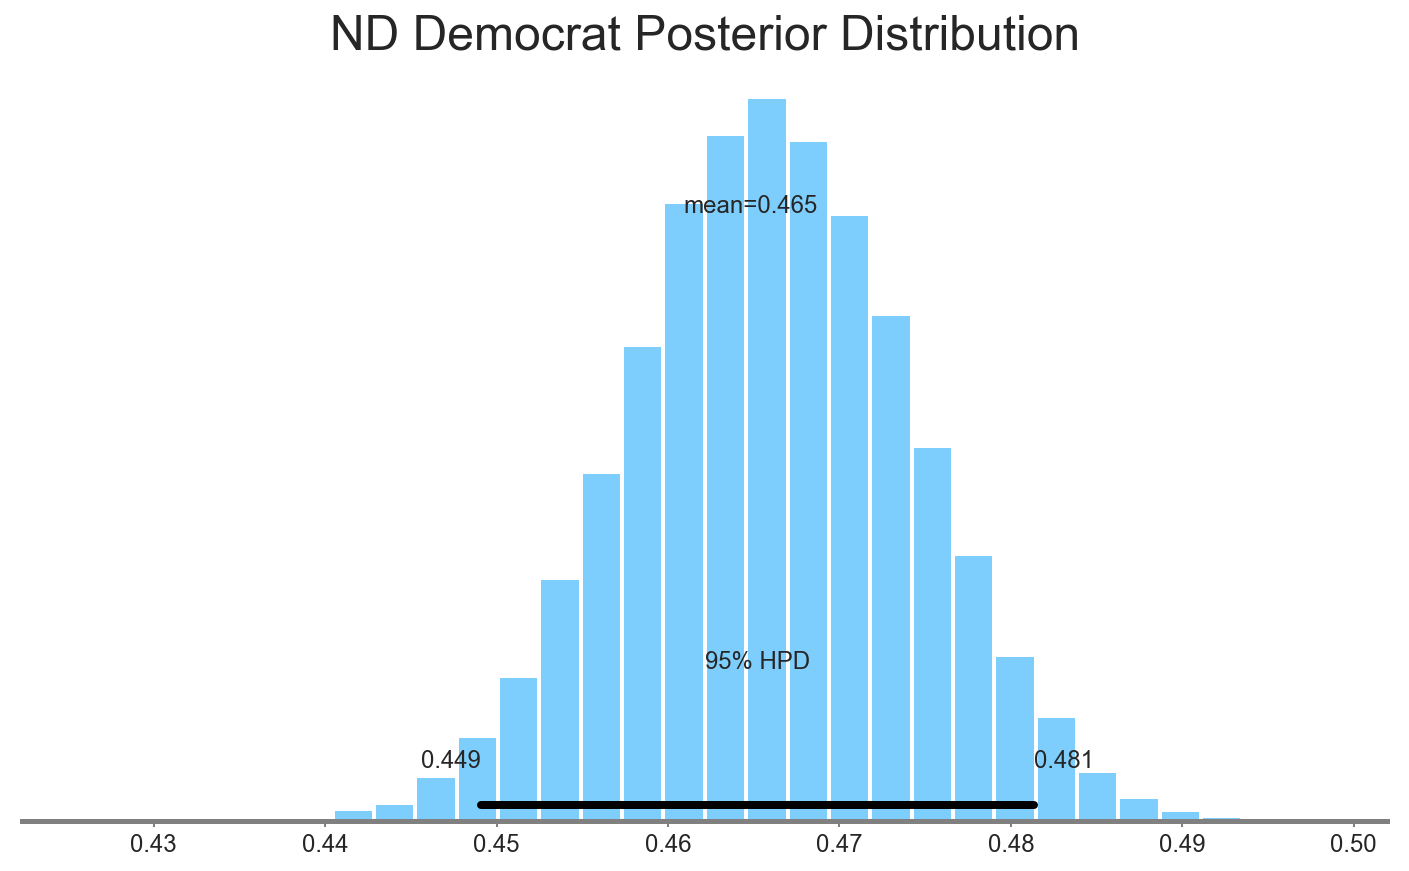

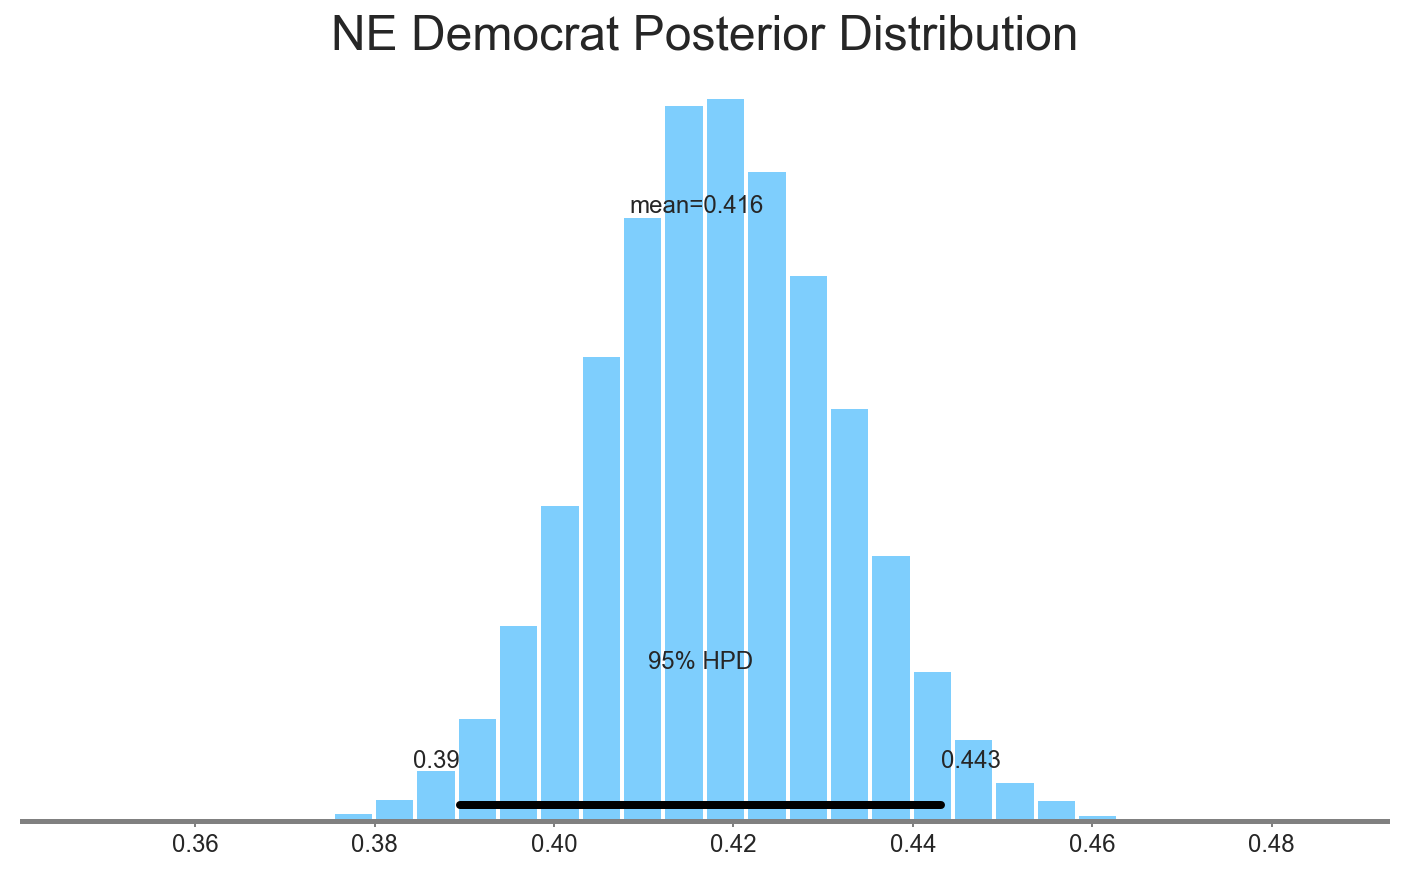

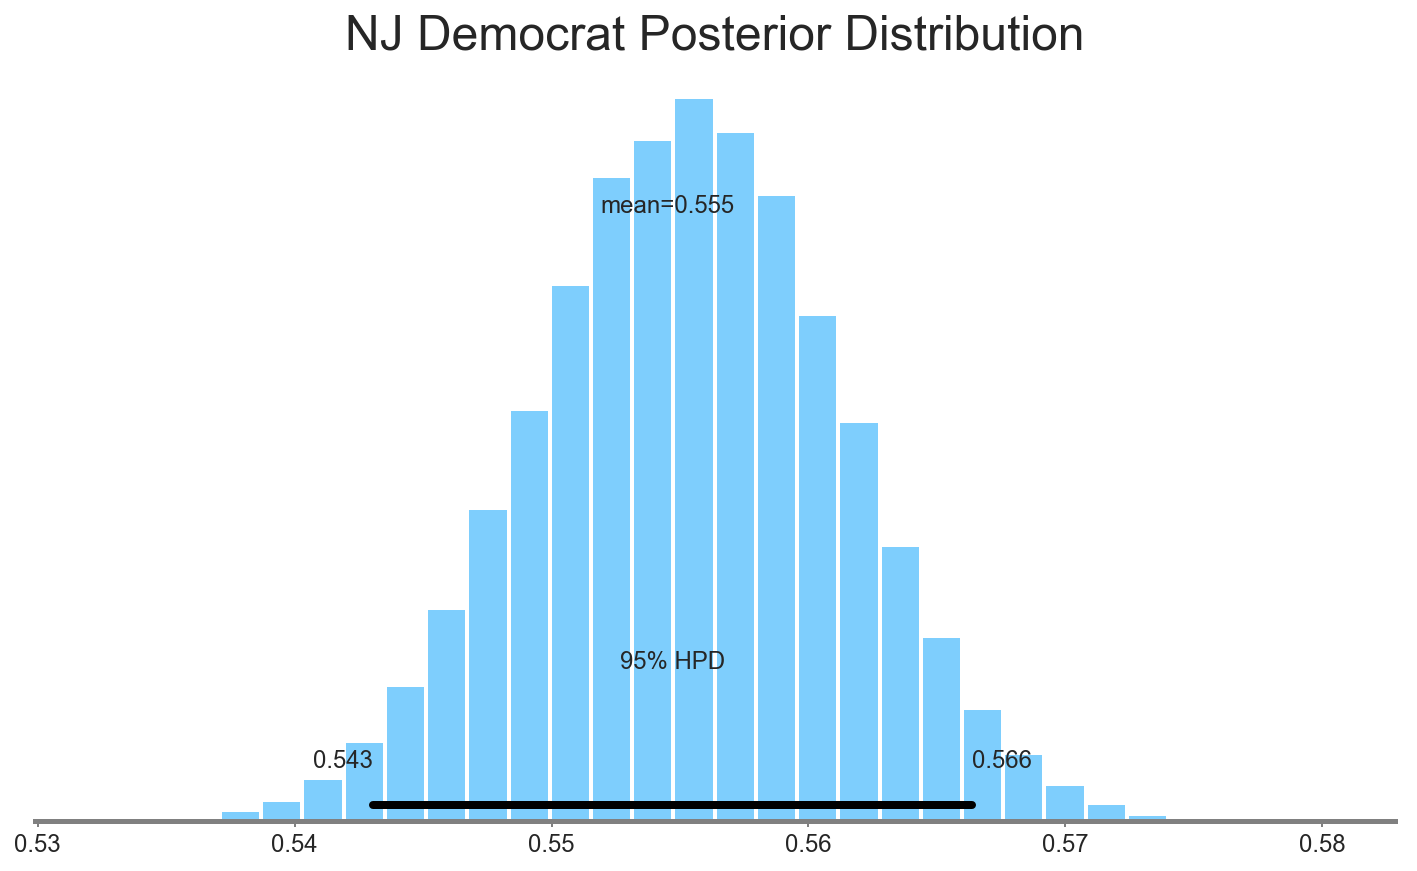

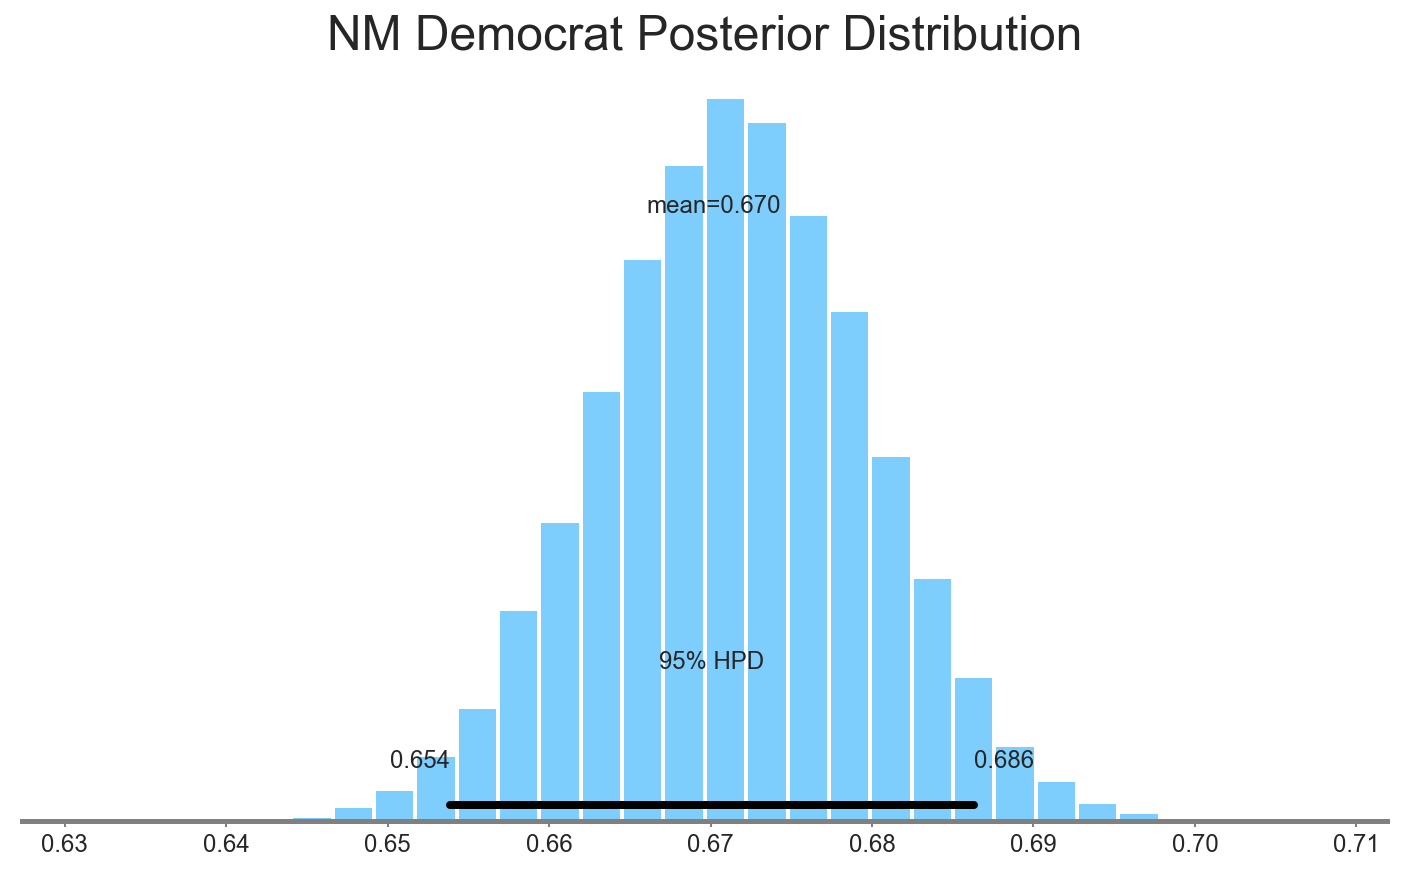

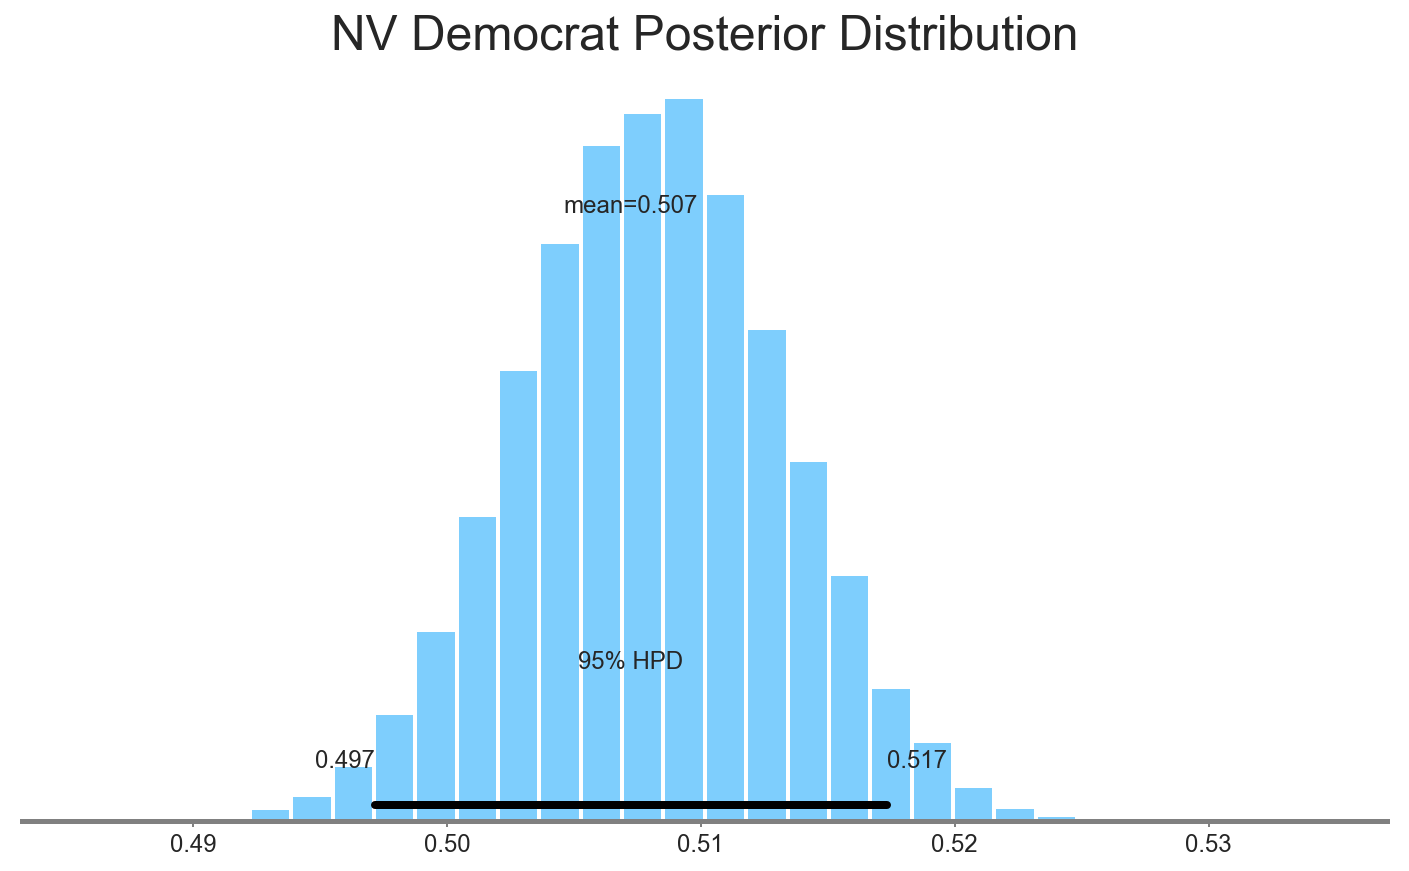

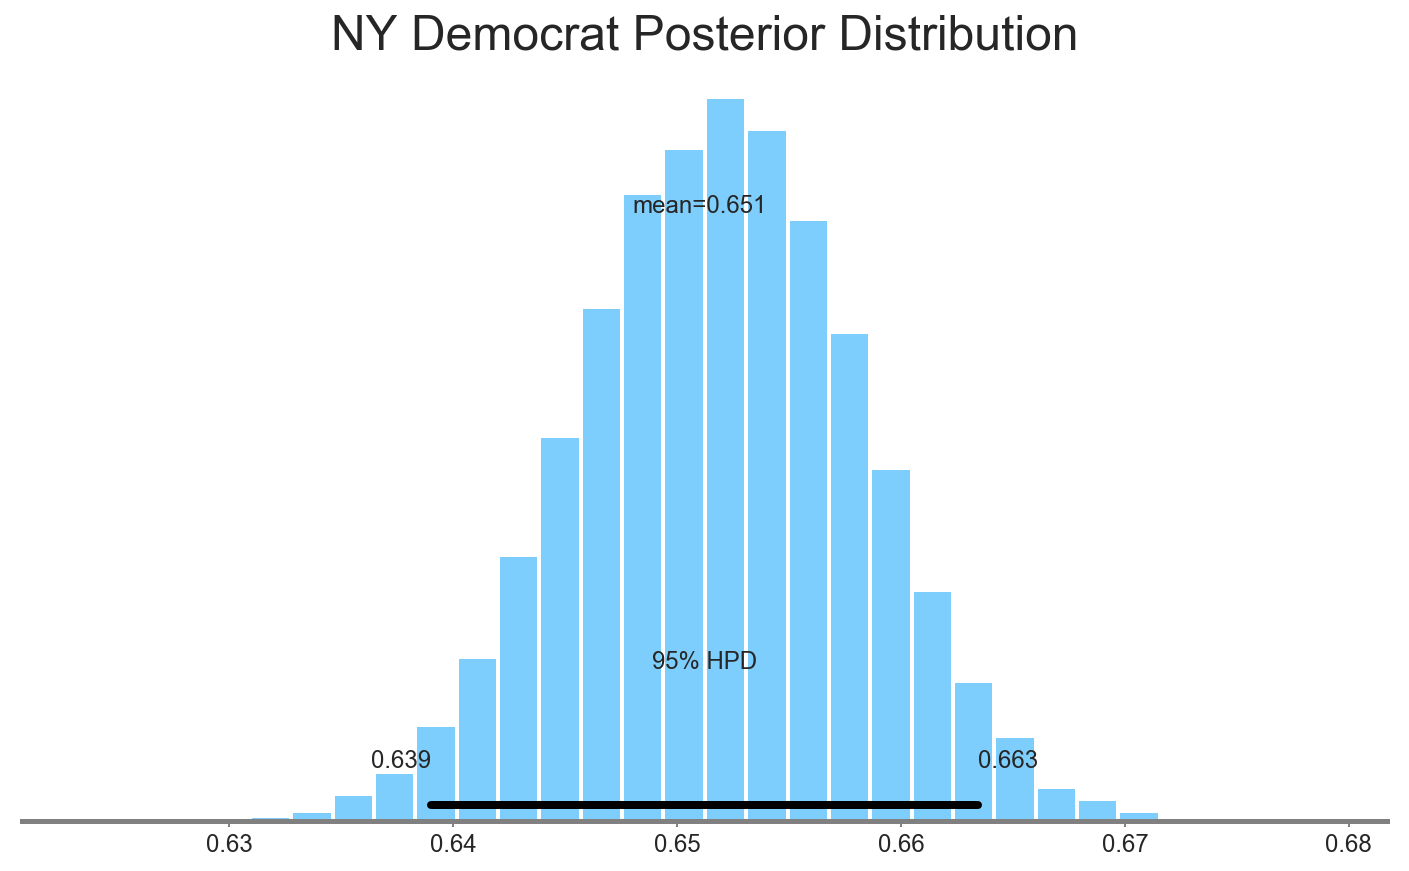

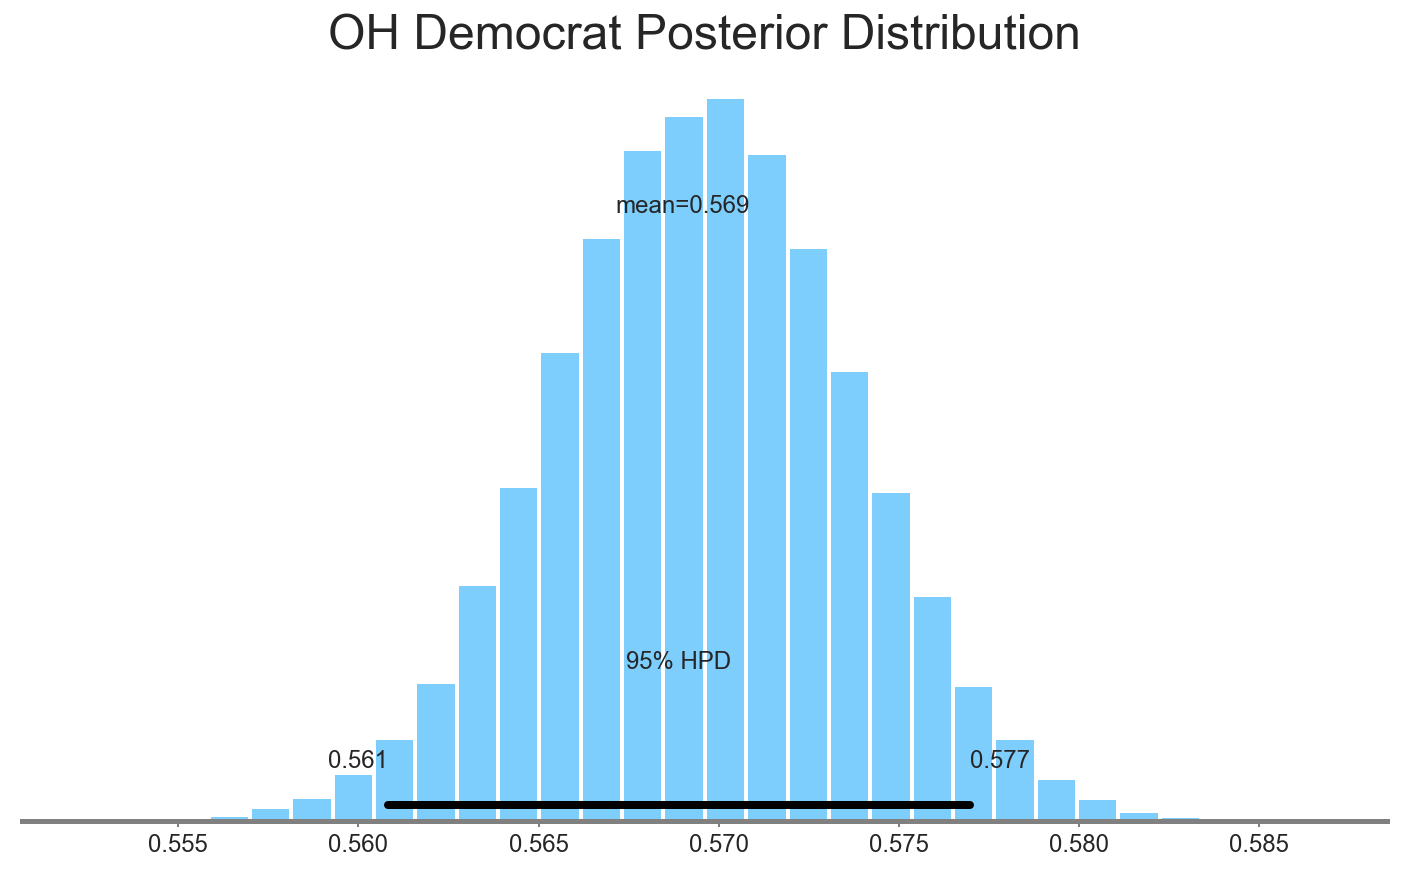

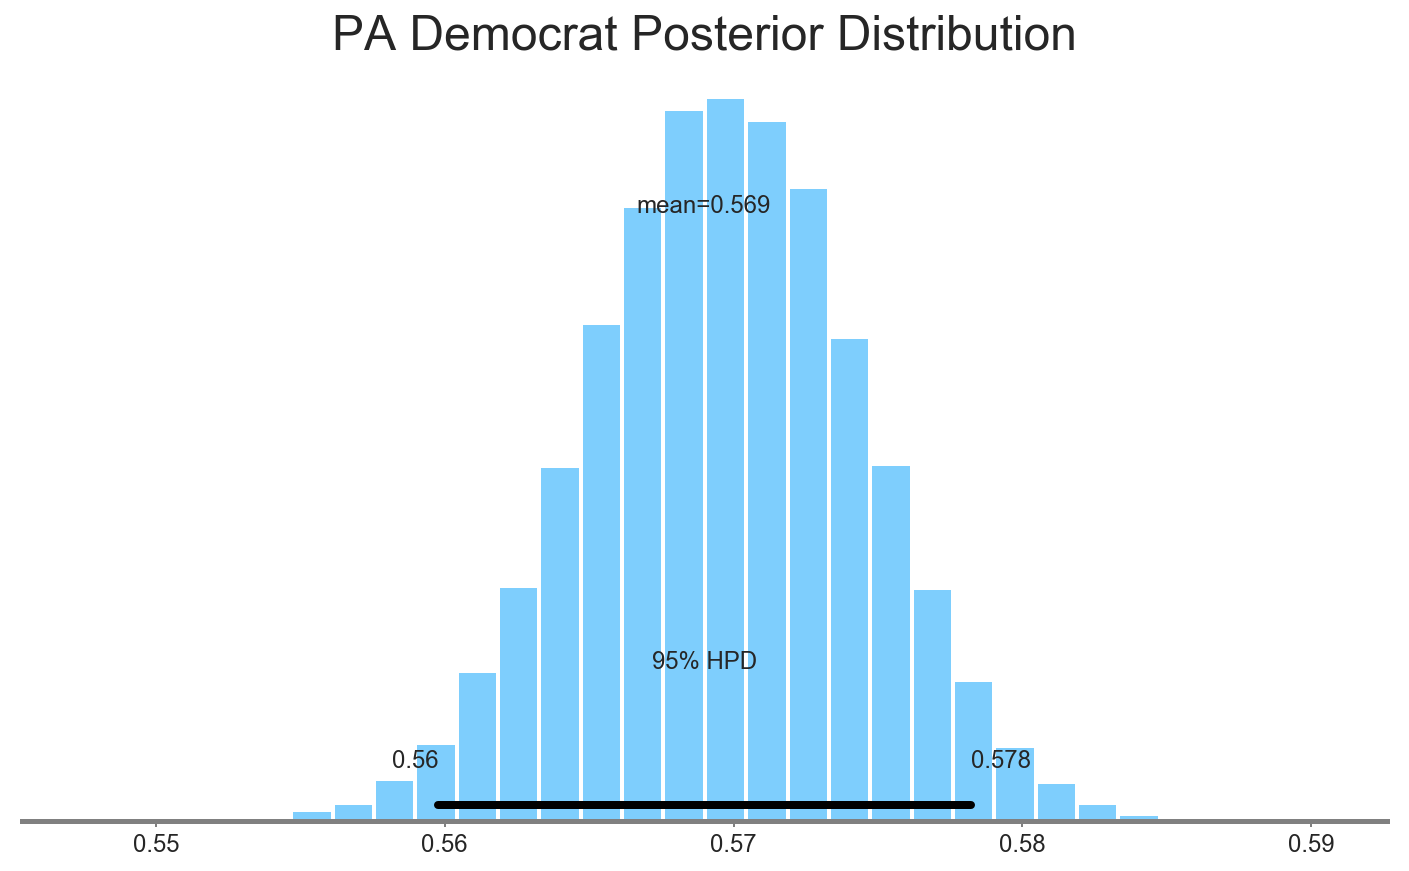

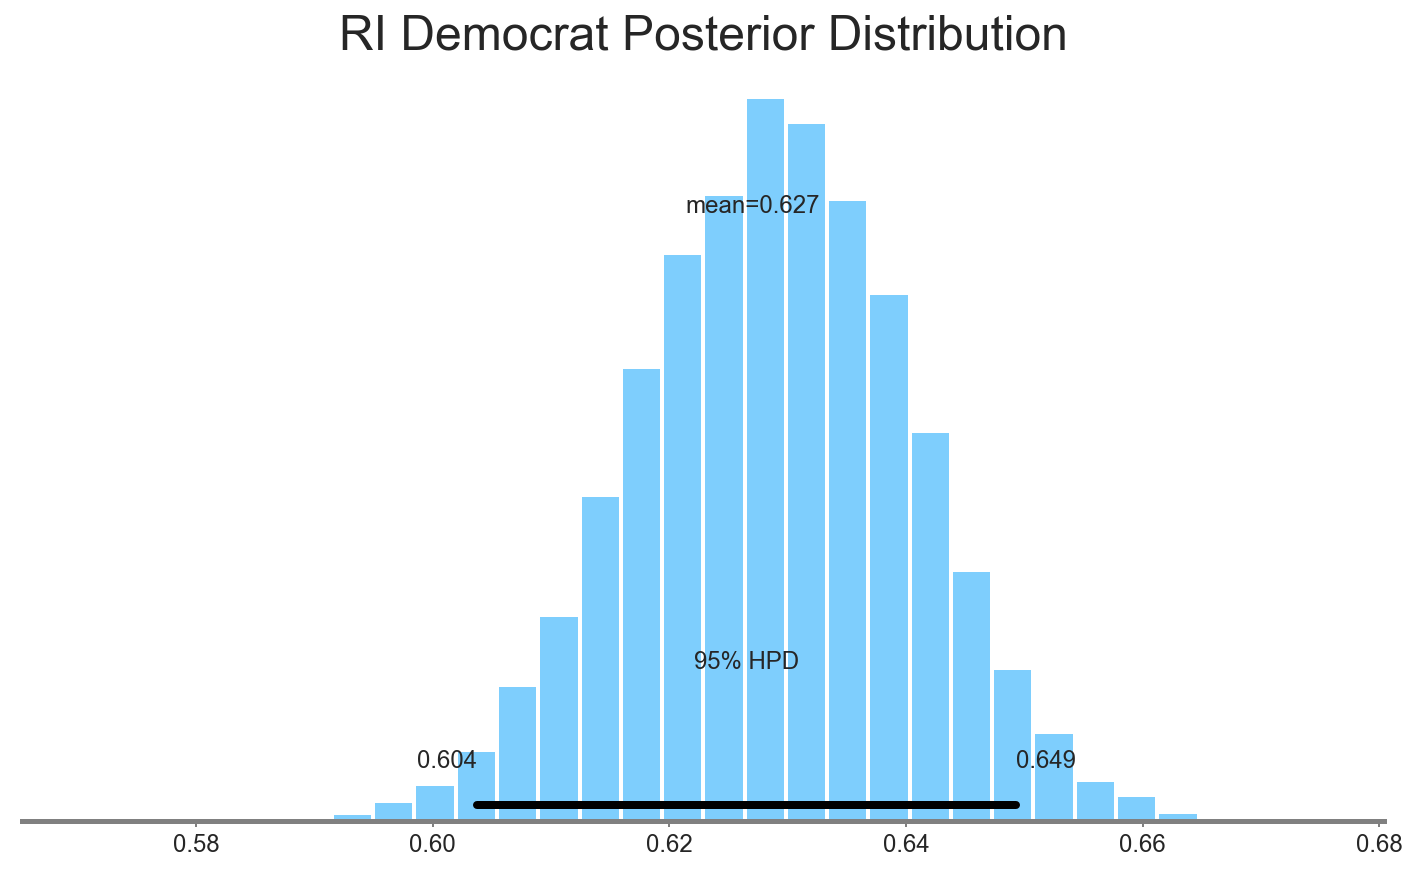

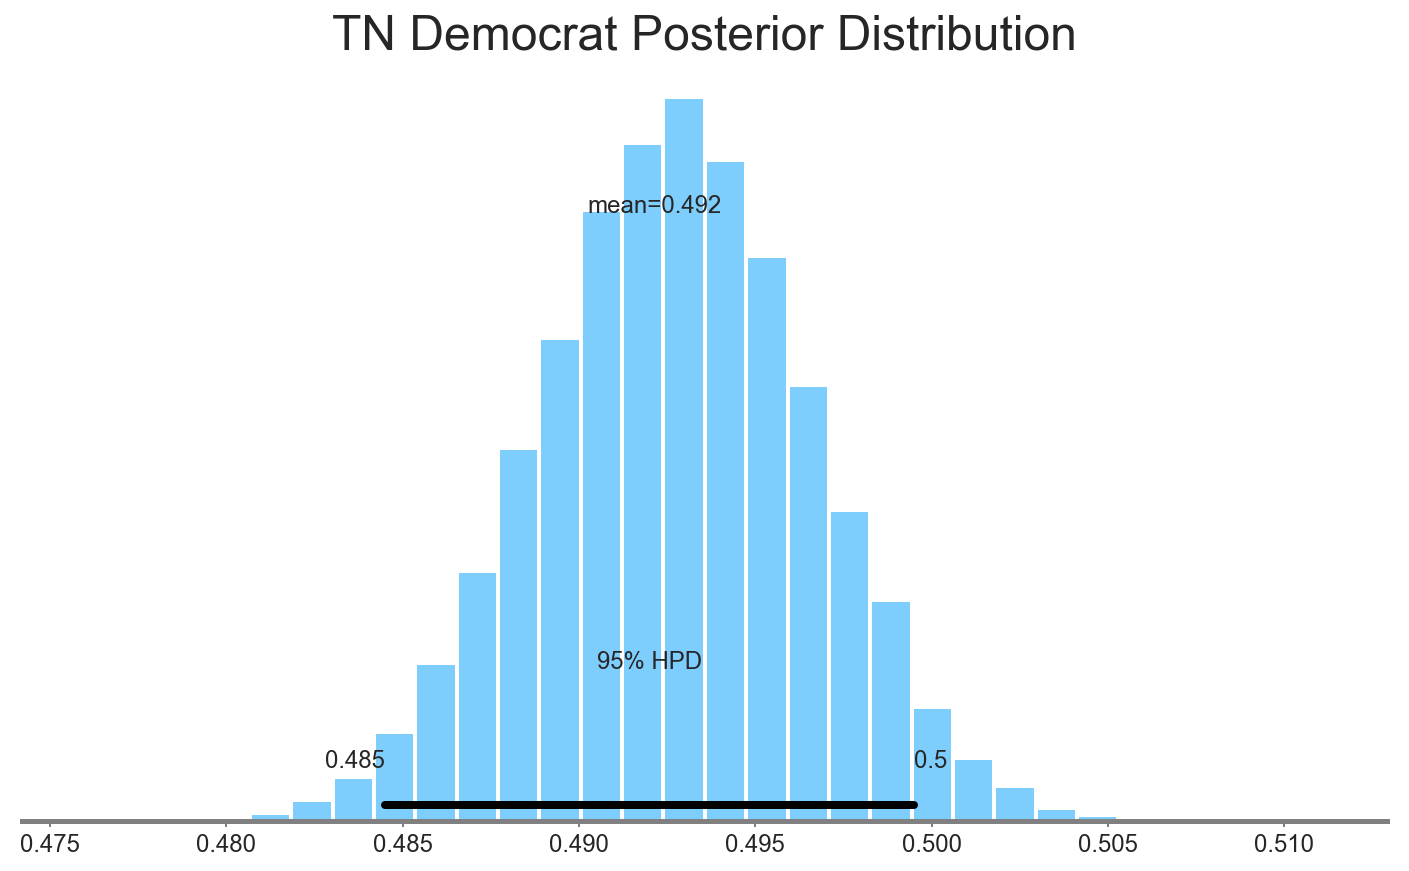

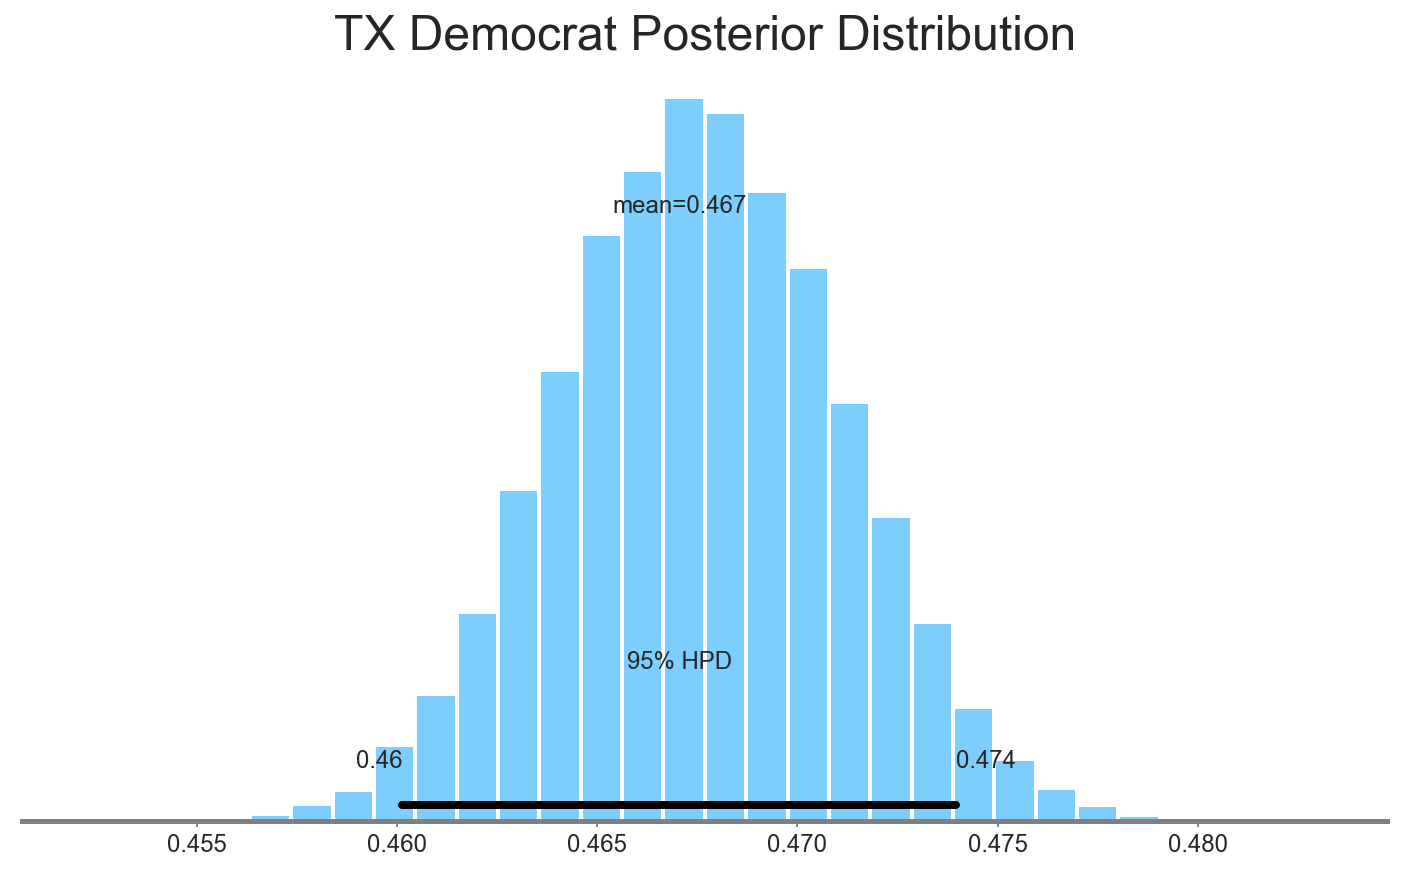

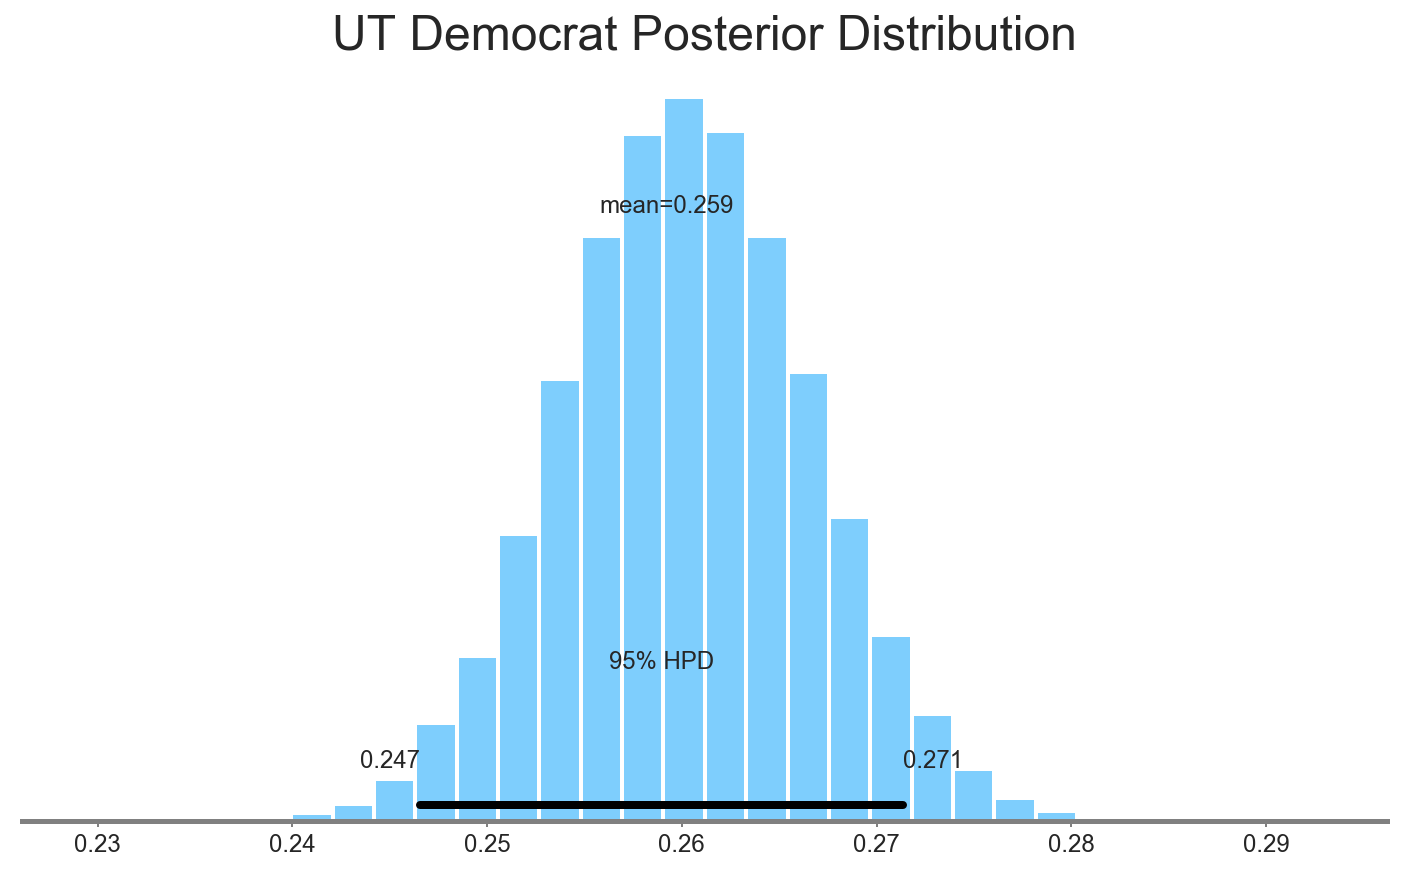

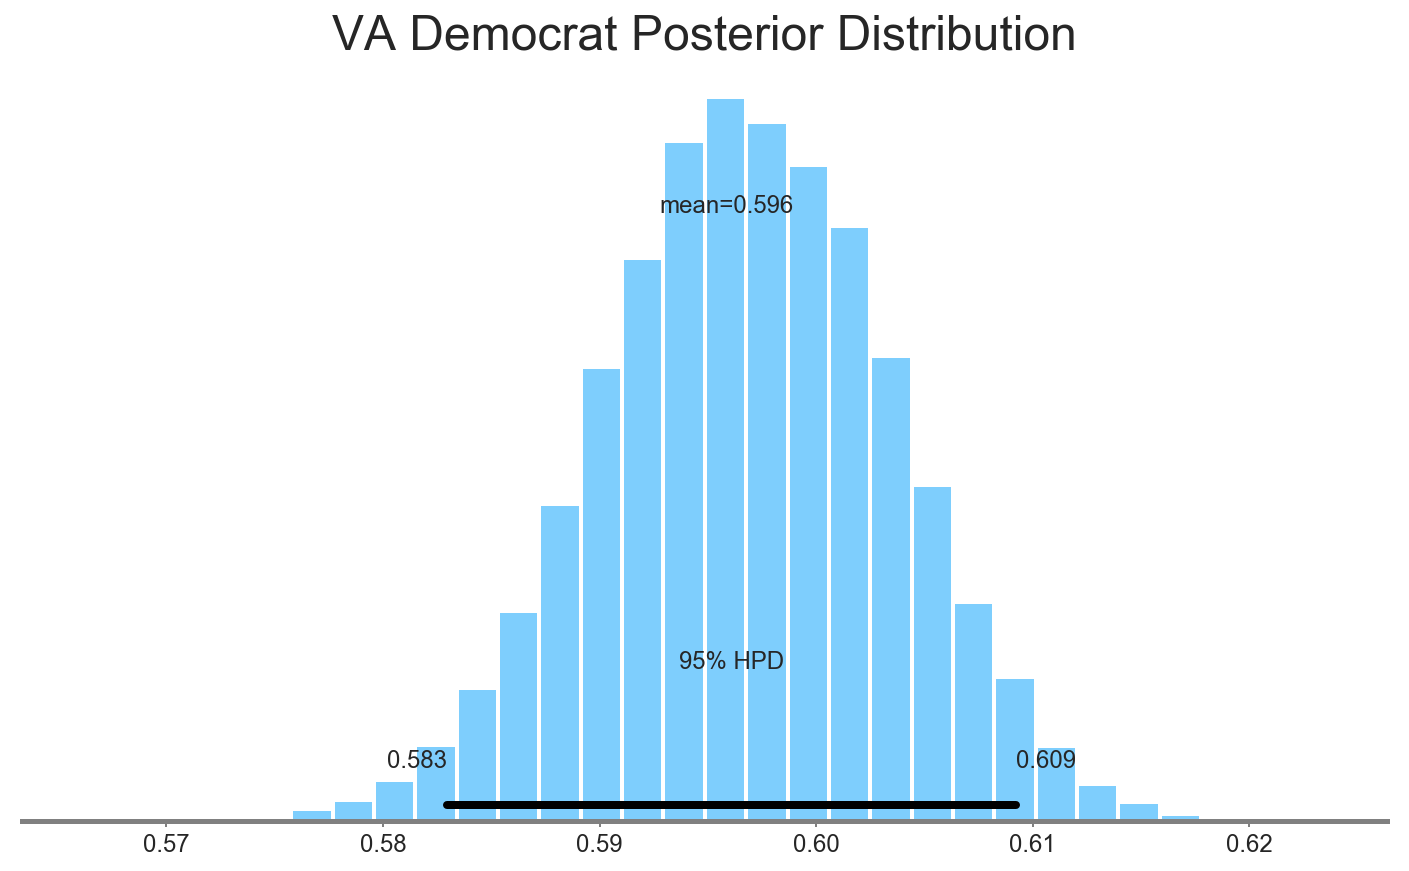

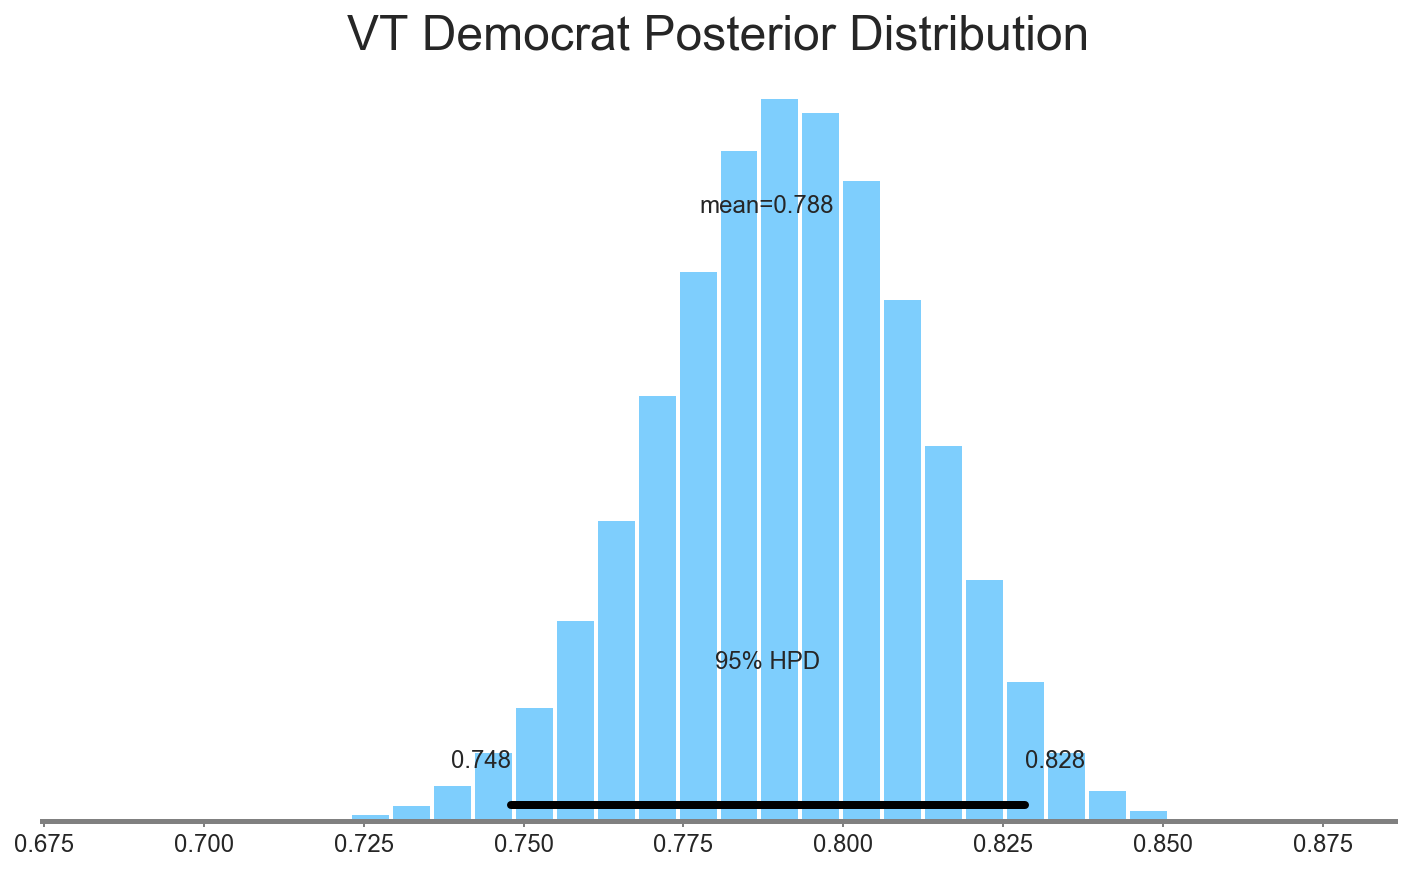

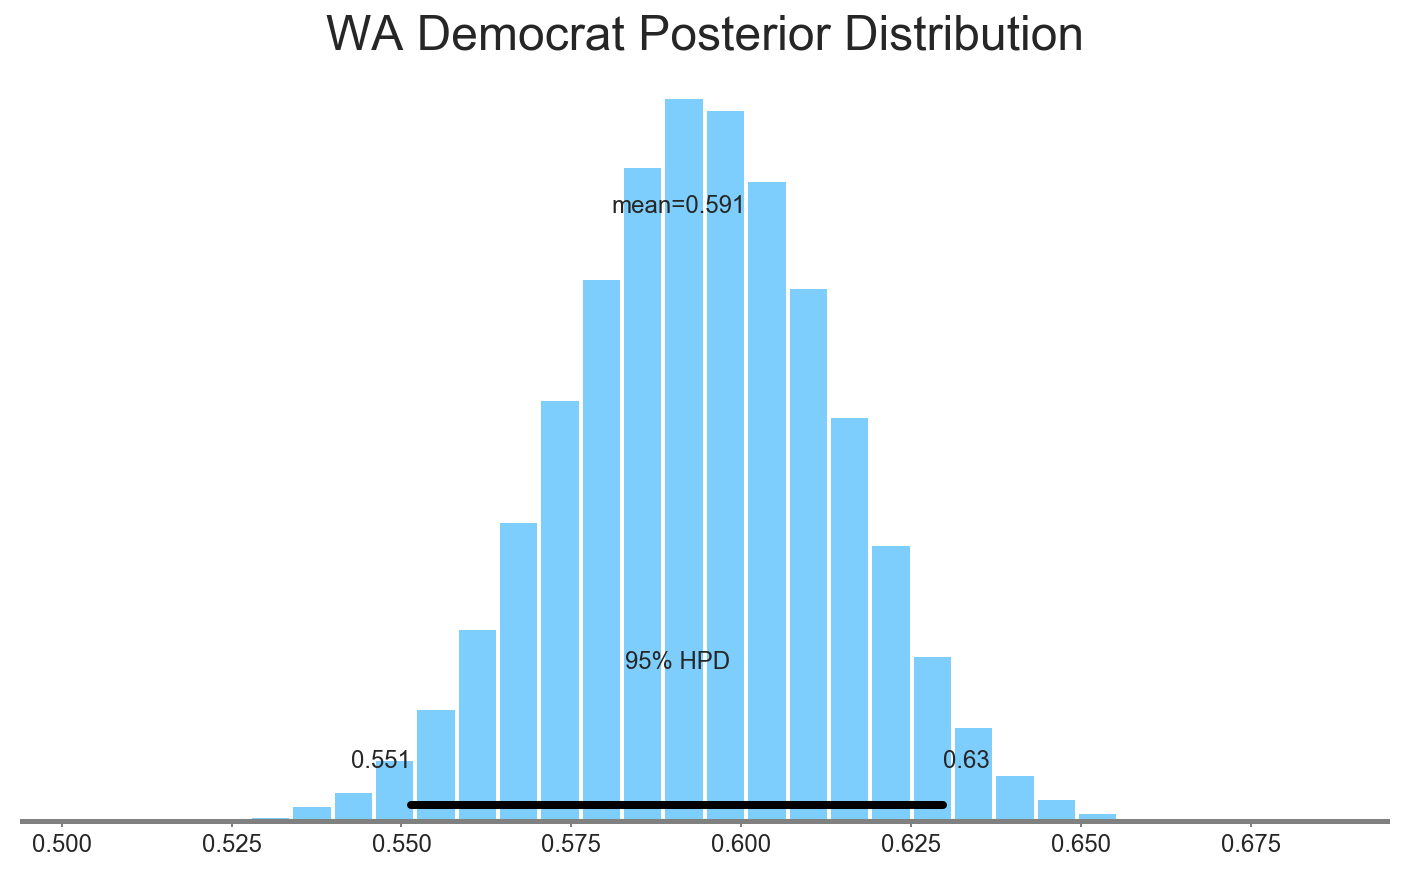

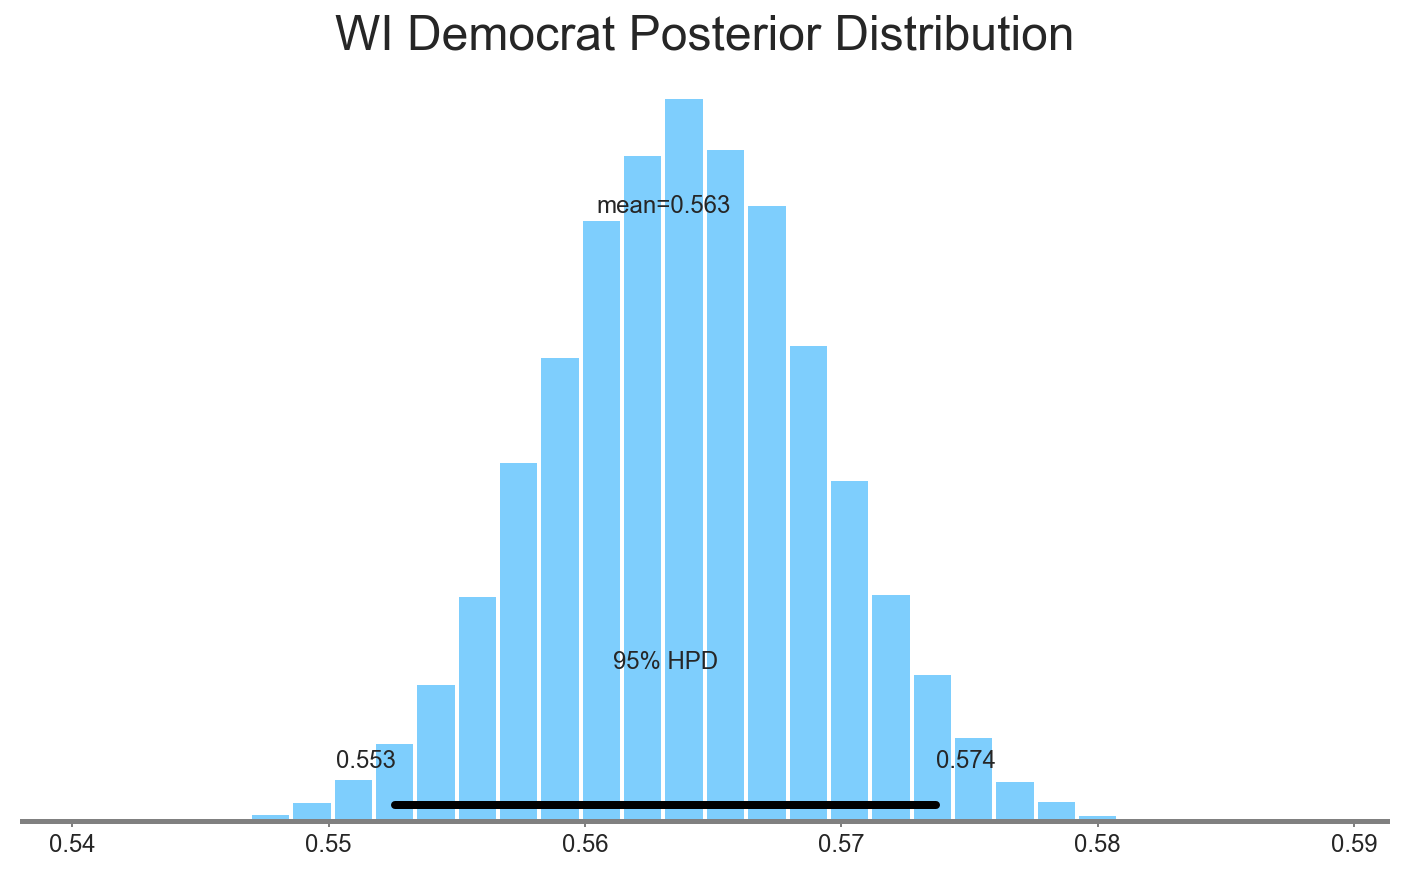

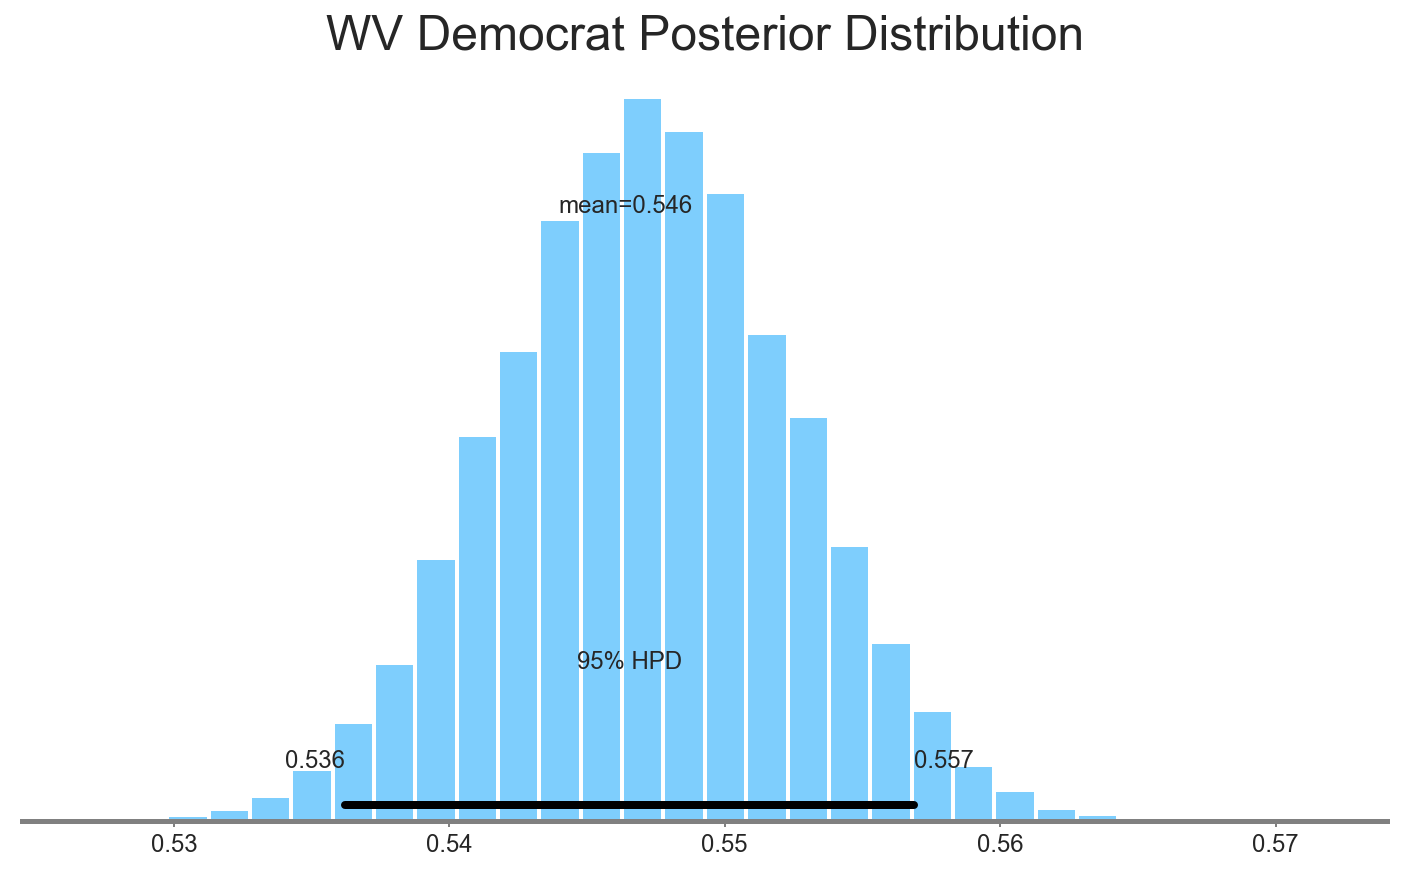

In [13]:
for ind in range(len(state_priors)):
    s = states[ind]
    pm.plot_posterior(trace_list[ind], color='#7ecefd',
                      # rope=[0.48, 0.52], 
                      point_estimate='mean', 
                      figsize=(10,6))
    plt.title(s+' Democrat Posterior Distribution')
    plt.show()